In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from skimage.transform import resize
from skimage.io import imread
from skimage import color
import os

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [3]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.float32)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0.
            elif rdn > thres:
                output[i][j] = 255.
            else:
                output[i][j] = image[i][j]
    return output

In [4]:
def augment(img_data, img_labels):
    imgs = img_data.reshape(img_data.shape[0], 3, 32, 32)
    flip_pct = 0.05 # 5% chance of flipping the image each time
    salt_pct = 0.05 # 5% chance of noise
    noise_pct = 0.15 # salt and pepper noise
    
    orig_size = len(imgs)
    for i in tqdm(range(0, orig_size)):
        # random flip UD (which will in effect do the LR flip)
        if random.random() < flip_pct:
            #print('IMFLIP: im['+str(i)+']')
            im_flip = np.expand_dims(np.flipud(imgs[i]), axis=0)
            imgs = np.vstack((imgs, im_flip))
            img_labels = np.hstack((img_labels, img_labels[i]))
        
        # random salt and pepper noise
        if random.random() < salt_pct:
            #print('IMSALT: im['+str(i)+']')
            im_salt = np.expand_dims(sp_noise(imgs[i], noise_pct), axis=0)
            imgs = np.vstack((imgs, im_salt))
            img_labels = np.hstack((img_labels, img_labels[i]))
            
    return imgs.reshape(imgs.shape[0], -1), img_labels


In [5]:
def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(imgs.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

In [6]:
def read_data(directory):
    data_file = 'aug_data.npy'
    labels_file = 'aug_labels.npy'

    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    
    if os.path.exists(data_file) and os.path.isfile(data_file) and os.path.exists(labels_file) and os.path.isfile(labels_file):
            print('Loading data from cache files {} and {}'.format(data_file, labels_file))
            data = np.load(data_file)
            labels = np.load(labels_file)
    else:
        for i in range(1, 6):
            filename = '{}/data_batch_{}'.format(directory, i)
            batch_data = unpickle(filename)
            if len(data) > 0:
                data = np.vstack((data, batch_data['data']))
                labels = np.hstack((labels, batch_data['labels']))
            else:
                data = batch_data['data']
                labels = batch_data['labels']

        data, labels = augment(data, labels)
        data = clean(data)        
        data = data.astype(np.float32)
        np.save('aug_data.npy', data)
        np.save('aug_labels.npy', labels)

    print(np.shape(data), np.shape(labels))

    return names, data, labels


In [7]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

names, data, labels = read_data('./cifar-10-batches-py')
x = tf.placeholder(tf.float32, [None, 24 * 24], name='input_x') # 5000,576
y = tf.placeholder(tf.float32, [None, len(names)], name='output_y') # 50000, 10
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Loading data from cache files aug_data.npy and aug_labels.npy
(54974, 576) (54974,)


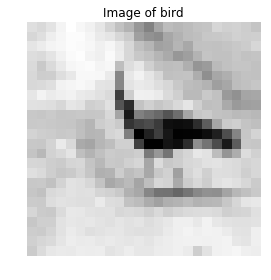

In [8]:
plt.figure()
plt.title("Image of "+str(names[labels[52004]]))
img = np.reshape(data[52004, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [9]:
conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 1, 64], mean=0, stddev=0.08)) #changed 3 to 1 in 3rd param b/c Grey
conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

In [10]:
def model(x, keep_prob):
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])
    
    # 1, 2
    conv1 = tf.nn.conv2d(x_reshaped, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full4, num_outputs=10, activation_fn=None)
    return out

In [24]:
epochs = 1000
keep_probability = 0.7
learning_rate = 0.001
model_op = model(x, keep_probability)
model_ops = tf.identity(model_op, name='logits') # Name logits Tensor, so that can be loaded from disk after training
beta = 0.1 #regularlization
weights = [conv1_filter, conv2_filter, conv3_filter, conv4_filter]
regularizer = tf.nn.l2_loss(weights[0])
for w in range(1, len(weights)):
    regularizer = regularizer + tf.nn.l2_loss(weights[w])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y))
cost = tf.reduce_mean(cost + beta * regularizer) #L2 regularization
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = len(data) // 200
    print('batch size', batch_size)
    for j in tqdm(range(0, epochs)):
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size, :]
            batch_onehot_vals = onehot_vals[i:i+batch_size, :]
            _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x:batch_data, y: batch_onehot_vals})
        print(j, accuracy_val)
  

    saver.save(sess, './cifar10-cnn-tf1n-ia-dropout-reg-dense-'+str(epochs)+'epochs.ckpt')

  0%|          | 0/3000 [00:00<?, ?it/s]

batch size 274


  0%|          | 1/3000 [00:05<4:54:48,  5.90s/it]

0 0.18965517


  0%|          | 2/3000 [00:11<4:49:42,  5.80s/it]

1 0.2413793


  0%|          | 3/3000 [00:17<4:46:59,  5.75s/it]

2 0.23563218


  0%|          | 4/3000 [00:22<4:43:57,  5.69s/it]

3 0.27586207


  0%|          | 5/3000 [00:28<4:41:39,  5.64s/it]

4 0.3275862


  0%|          | 6/3000 [00:33<4:40:28,  5.62s/it]

5 0.35632184


  0%|          | 7/3000 [00:39<4:39:52,  5.61s/it]

6 0.44827586


  0%|          | 8/3000 [00:44<4:39:20,  5.60s/it]

7 0.42528737


  0%|          | 9/3000 [00:50<4:39:00,  5.60s/it]

8 0.42528737


  0%|          | 10/3000 [00:56<4:37:55,  5.58s/it]

9 0.44827586


  0%|          | 11/3000 [01:01<4:37:19,  5.57s/it]

10 0.47126436


  0%|          | 12/3000 [01:07<4:36:26,  5.55s/it]

11 0.45402297


  0%|          | 13/3000 [01:12<4:36:08,  5.55s/it]

12 0.4827586


  0%|          | 14/3000 [01:18<4:36:21,  5.55s/it]

13 0.48850575


  0%|          | 15/3000 [01:23<4:36:05,  5.55s/it]

14 0.47126436


  1%|          | 16/3000 [01:29<4:35:36,  5.54s/it]

15 0.5344828


  1%|          | 17/3000 [01:34<4:36:19,  5.56s/it]

16 0.5344828


  1%|          | 18/3000 [01:40<4:37:18,  5.58s/it]

17 0.51724136


  1%|          | 19/3000 [01:46<4:37:39,  5.59s/it]

18 0.5574713


  1%|          | 20/3000 [01:51<4:37:11,  5.58s/it]

19 0.5632184


  1%|          | 21/3000 [01:57<4:37:01,  5.58s/it]

20 0.5632184


  1%|          | 22/3000 [02:02<4:37:08,  5.58s/it]

21 0.51724136


  1%|          | 23/3000 [02:08<4:38:14,  5.61s/it]

22 0.59195405


  1%|          | 24/3000 [02:14<4:38:53,  5.62s/it]

23 0.61494255


  1%|          | 25/3000 [02:19<4:38:39,  5.62s/it]

24 0.51724136


  1%|          | 26/3000 [02:25<4:38:01,  5.61s/it]

25 0.5804598


  1%|          | 27/3000 [02:30<4:37:38,  5.60s/it]

26 0.52873564


  1%|          | 28/3000 [02:36<4:38:18,  5.62s/it]

27 0.6091954


  1%|          | 29/3000 [02:42<4:37:15,  5.60s/it]

28 0.59770113


  1%|          | 30/3000 [02:47<4:36:58,  5.60s/it]

29 0.61494255


  1%|          | 31/3000 [02:53<4:36:05,  5.58s/it]

30 0.61494255


  1%|          | 32/3000 [02:58<4:35:20,  5.57s/it]

31 0.5862069


  1%|          | 33/3000 [03:04<4:35:20,  5.57s/it]

32 0.61494255


  1%|          | 34/3000 [03:09<4:35:58,  5.58s/it]

33 0.6091954


  1%|          | 35/3000 [03:15<4:36:30,  5.60s/it]

34 0.5689655


  1%|          | 36/3000 [03:21<4:35:59,  5.59s/it]

35 0.59195405


  1%|          | 37/3000 [03:26<4:34:54,  5.57s/it]

36 0.5804598


  1%|▏         | 38/3000 [03:32<4:34:32,  5.56s/it]

37 0.62068963


  1%|▏         | 39/3000 [03:37<4:35:02,  5.57s/it]

38 0.57471263


  1%|▏         | 40/3000 [03:43<4:34:55,  5.57s/it]

39 0.5574713


  1%|▏         | 41/3000 [03:48<4:34:47,  5.57s/it]

40 0.6321839


  1%|▏         | 42/3000 [03:54<4:34:00,  5.56s/it]

41 0.59195405


  1%|▏         | 43/3000 [04:00<4:34:30,  5.57s/it]

42 0.59195405


  1%|▏         | 44/3000 [04:05<4:35:38,  5.60s/it]

43 0.62068963


  2%|▏         | 45/3000 [04:11<4:36:30,  5.61s/it]

44 0.6034483


  2%|▏         | 46/3000 [04:17<4:36:16,  5.61s/it]

45 0.59770113


  2%|▏         | 47/3000 [04:22<4:35:41,  5.60s/it]

46 0.59195405


  2%|▏         | 48/3000 [04:28<4:35:51,  5.61s/it]

47 0.6436782


  2%|▏         | 49/3000 [04:33<4:36:29,  5.62s/it]

48 0.59195405


  2%|▏         | 50/3000 [04:39<4:37:01,  5.63s/it]

49 0.6321839


  2%|▏         | 51/3000 [04:45<4:36:24,  5.62s/it]

50 0.62068963


  2%|▏         | 52/3000 [04:50<4:34:47,  5.59s/it]

51 0.62643677


  2%|▏         | 53/3000 [04:56<4:33:47,  5.57s/it]

52 0.62643677


  2%|▏         | 54/3000 [05:01<4:33:40,  5.57s/it]

53 0.63793105


  2%|▏         | 55/3000 [05:07<4:33:29,  5.57s/it]

54 0.62068963


  2%|▏         | 56/3000 [05:12<4:33:25,  5.57s/it]

55 0.6551724


  2%|▏         | 57/3000 [05:18<4:32:40,  5.56s/it]

56 0.63793105


  2%|▏         | 58/3000 [05:23<4:32:16,  5.55s/it]

57 0.6436782


  2%|▏         | 59/3000 [05:29<4:31:41,  5.54s/it]

58 0.5632184


  2%|▏         | 60/3000 [05:35<4:31:44,  5.55s/it]

59 0.62068963


  2%|▏         | 61/3000 [05:40<4:32:57,  5.57s/it]

60 0.6551724


  2%|▏         | 62/3000 [05:46<4:33:20,  5.58s/it]

61 0.6666667


  2%|▏         | 63/3000 [05:51<4:32:43,  5.57s/it]

62 0.6551724


  2%|▏         | 64/3000 [05:57<4:33:30,  5.59s/it]

63 0.59195405


  2%|▏         | 65/3000 [06:03<4:34:28,  5.61s/it]

64 0.64942527


  2%|▏         | 66/3000 [06:08<4:33:58,  5.60s/it]

65 0.63793105


  2%|▏         | 67/3000 [06:14<4:33:03,  5.59s/it]

66 0.6551724


  2%|▏         | 68/3000 [06:19<4:32:40,  5.58s/it]

67 0.62643677


  2%|▏         | 69/3000 [06:25<4:32:07,  5.57s/it]

68 0.59195405


  2%|▏         | 70/3000 [06:30<4:32:33,  5.58s/it]

69 0.6321839


  2%|▏         | 71/3000 [06:36<4:31:56,  5.57s/it]

70 0.63793105


  2%|▏         | 72/3000 [06:42<4:31:43,  5.57s/it]

71 0.6091954


  2%|▏         | 73/3000 [06:47<4:31:52,  5.57s/it]

72 0.6551724


  2%|▏         | 74/3000 [06:53<4:31:37,  5.57s/it]

73 0.64942527


  2%|▎         | 75/3000 [06:58<4:31:55,  5.58s/it]

74 0.62068963


  3%|▎         | 76/3000 [07:04<4:32:48,  5.60s/it]

75 0.67241377


  3%|▎         | 77/3000 [07:10<4:33:05,  5.61s/it]

76 0.6321839


  3%|▎         | 78/3000 [07:15<4:33:05,  5.61s/it]

77 0.5862069


  3%|▎         | 79/3000 [07:21<4:32:30,  5.60s/it]

78 0.66091955


  3%|▎         | 80/3000 [07:26<4:32:09,  5.59s/it]

79 0.67241377


  3%|▎         | 81/3000 [07:32<4:31:41,  5.58s/it]

80 0.63793105


  3%|▎         | 82/3000 [07:37<4:30:46,  5.57s/it]

81 0.62643677


  3%|▎         | 83/3000 [07:43<4:29:51,  5.55s/it]

82 0.6781609


  3%|▎         | 84/3000 [07:48<4:29:12,  5.54s/it]

83 0.6436782


  3%|▎         | 85/3000 [07:54<4:28:42,  5.53s/it]

84 0.62068963


  3%|▎         | 86/3000 [08:00<4:28:42,  5.53s/it]

85 0.61494255


  3%|▎         | 87/3000 [08:05<4:29:10,  5.54s/it]

86 0.62068963


  3%|▎         | 88/3000 [08:11<4:28:58,  5.54s/it]

87 0.70689654


  3%|▎         | 89/3000 [08:16<4:29:30,  5.55s/it]

88 0.63793105


  3%|▎         | 90/3000 [08:22<4:29:48,  5.56s/it]

89 0.6551724


  3%|▎         | 91/3000 [08:27<4:30:24,  5.58s/it]

90 0.6896552


  3%|▎         | 92/3000 [08:33<4:30:52,  5.59s/it]

91 0.6436782


  3%|▎         | 93/3000 [08:39<4:32:06,  5.62s/it]

92 0.68390805


  3%|▎         | 94/3000 [08:44<4:31:24,  5.60s/it]

93 0.6436782


  3%|▎         | 95/3000 [08:50<4:31:17,  5.60s/it]

94 0.59770113


  3%|▎         | 96/3000 [08:55<4:30:35,  5.59s/it]

95 0.6091954


  3%|▎         | 97/3000 [09:01<4:30:38,  5.59s/it]

96 0.6321839


  3%|▎         | 98/3000 [09:07<4:30:45,  5.60s/it]

97 0.6551724


  3%|▎         | 99/3000 [09:12<4:30:11,  5.59s/it]

98 0.6781609


  3%|▎         | 100/3000 [09:18<4:29:16,  5.57s/it]

99 0.63793105


  3%|▎         | 101/3000 [09:23<4:28:42,  5.56s/it]

100 0.61494255


  3%|▎         | 102/3000 [09:29<4:29:01,  5.57s/it]

101 0.68390805


  3%|▎         | 103/3000 [09:34<4:29:06,  5.57s/it]

102 0.6666667


  3%|▎         | 104/3000 [09:40<4:29:15,  5.58s/it]

103 0.6954023


  4%|▎         | 105/3000 [09:46<4:29:23,  5.58s/it]

104 0.62643677


  4%|▎         | 106/3000 [09:51<4:29:24,  5.59s/it]

105 0.63793105


  4%|▎         | 107/3000 [09:57<4:29:39,  5.59s/it]

106 0.6666667


  4%|▎         | 108/3000 [10:02<4:29:46,  5.60s/it]

107 0.70689654


  4%|▎         | 109/3000 [10:08<4:29:04,  5.58s/it]

108 0.6896552


  4%|▎         | 110/3000 [10:14<4:28:26,  5.57s/it]

109 0.6896552


  4%|▎         | 111/3000 [10:19<4:27:53,  5.56s/it]

110 0.68390805


  4%|▎         | 112/3000 [10:25<4:28:21,  5.58s/it]

111 0.64942527


  4%|▍         | 113/3000 [10:30<4:28:32,  5.58s/it]

112 0.6666667


  4%|▍         | 114/3000 [10:36<4:28:25,  5.58s/it]

113 0.7183908


  4%|▍         | 115/3000 [10:41<4:28:05,  5.58s/it]

114 0.7356322


  4%|▍         | 116/3000 [10:47<4:27:32,  5.57s/it]

115 0.6436782


  4%|▍         | 117/3000 [10:53<4:27:28,  5.57s/it]

116 0.7126437


  4%|▍         | 118/3000 [10:58<4:27:16,  5.56s/it]

117 0.7126437


  4%|▍         | 119/3000 [11:04<4:27:41,  5.57s/it]

118 0.70689654


  4%|▍         | 120/3000 [11:09<4:27:36,  5.58s/it]

119 0.64942527


  4%|▍         | 121/3000 [11:15<4:27:01,  5.56s/it]

120 0.63793105


  4%|▍         | 122/3000 [11:20<4:26:33,  5.56s/it]

121 0.6551724


  4%|▍         | 123/3000 [11:26<4:27:36,  5.58s/it]

122 0.6666667


  4%|▍         | 124/3000 [11:32<4:27:25,  5.58s/it]

123 0.6436782


  4%|▍         | 125/3000 [11:37<4:27:26,  5.58s/it]

124 0.7183908


  4%|▍         | 126/3000 [11:43<4:27:27,  5.58s/it]

125 0.6666667


  4%|▍         | 127/3000 [11:48<4:27:25,  5.59s/it]

126 0.6954023


  4%|▍         | 128/3000 [11:54<4:28:00,  5.60s/it]

127 0.6034483


  4%|▍         | 129/3000 [12:00<4:28:40,  5.61s/it]

128 0.7183908


  4%|▍         | 130/3000 [12:05<4:29:34,  5.64s/it]

129 0.61494255


  4%|▍         | 131/3000 [12:11<4:28:05,  5.61s/it]

130 0.6781609


  4%|▍         | 132/3000 [12:16<4:27:39,  5.60s/it]

131 0.63793105


  4%|▍         | 133/3000 [12:22<4:27:35,  5.60s/it]

132 0.6896552


  4%|▍         | 134/3000 [12:28<4:27:01,  5.59s/it]

133 0.6551724


  4%|▍         | 135/3000 [12:33<4:27:04,  5.59s/it]

134 0.6436782


  5%|▍         | 136/3000 [12:39<4:26:21,  5.58s/it]

135 0.6551724


  5%|▍         | 137/3000 [12:44<4:25:40,  5.57s/it]

136 0.62643677


  5%|▍         | 138/3000 [12:50<4:25:23,  5.56s/it]

137 0.6666667


  5%|▍         | 139/3000 [12:55<4:25:35,  5.57s/it]

138 0.7183908


  5%|▍         | 140/3000 [13:01<4:25:39,  5.57s/it]

139 0.6436782


  5%|▍         | 141/3000 [13:07<4:25:44,  5.58s/it]

140 0.6954023


  5%|▍         | 142/3000 [13:12<4:25:36,  5.58s/it]

141 0.68390805


  5%|▍         | 143/3000 [13:18<4:24:55,  5.56s/it]

142 0.64942527


  5%|▍         | 144/3000 [13:23<4:25:14,  5.57s/it]

143 0.6321839


  5%|▍         | 145/3000 [13:29<4:25:55,  5.59s/it]

144 0.67241377


  5%|▍         | 146/3000 [13:35<4:25:53,  5.59s/it]

145 0.6896552


  5%|▍         | 147/3000 [13:40<4:25:05,  5.58s/it]

146 0.66091955


  5%|▍         | 148/3000 [13:46<4:24:49,  5.57s/it]

147 0.6551724


  5%|▍         | 149/3000 [13:51<4:25:21,  5.58s/it]

148 0.6551724


  5%|▌         | 150/3000 [13:57<4:25:28,  5.59s/it]

149 0.6034483


  5%|▌         | 151/3000 [14:02<4:25:14,  5.59s/it]

150 0.6781609


  5%|▌         | 152/3000 [14:08<4:24:50,  5.58s/it]

151 0.63793105


  5%|▌         | 153/3000 [14:14<4:24:24,  5.57s/it]

152 0.6551724


  5%|▌         | 154/3000 [14:19<4:24:00,  5.57s/it]

153 0.6666667


  5%|▌         | 155/3000 [14:25<4:24:16,  5.57s/it]

154 0.68390805


  5%|▌         | 156/3000 [14:30<4:23:42,  5.56s/it]

155 0.67241377


  5%|▌         | 157/3000 [14:36<4:23:37,  5.56s/it]

156 0.66091955


  5%|▌         | 158/3000 [14:41<4:23:28,  5.56s/it]

157 0.67241377


  5%|▌         | 159/3000 [14:47<4:22:52,  5.55s/it]

158 0.6781609


  5%|▌         | 160/3000 [14:52<4:22:52,  5.55s/it]

159 0.6666667


  5%|▌         | 161/3000 [14:58<4:23:21,  5.57s/it]

160 0.7011494


  5%|▌         | 162/3000 [15:04<4:22:52,  5.56s/it]

161 0.63793105


  5%|▌         | 163/3000 [15:09<4:22:25,  5.55s/it]

162 0.5862069


  5%|▌         | 164/3000 [15:15<4:22:05,  5.54s/it]

163 0.66091955


  6%|▌         | 165/3000 [15:20<4:22:45,  5.56s/it]

164 0.6781609


  6%|▌         | 166/3000 [15:26<4:23:35,  5.58s/it]

165 0.66091955


  6%|▌         | 167/3000 [15:32<4:24:35,  5.60s/it]

166 0.6954023


  6%|▌         | 168/3000 [15:37<4:23:35,  5.58s/it]

167 0.68390805


  6%|▌         | 169/3000 [15:43<4:23:25,  5.58s/it]

168 0.7011494


  6%|▌         | 170/3000 [15:48<4:23:14,  5.58s/it]

169 0.66091955


  6%|▌         | 171/3000 [15:54<4:23:20,  5.59s/it]

170 0.64942527


  6%|▌         | 172/3000 [15:59<4:22:46,  5.58s/it]

171 0.61494255


  6%|▌         | 173/3000 [16:05<4:23:27,  5.59s/it]

172 0.7126437


  6%|▌         | 174/3000 [16:11<4:22:48,  5.58s/it]

173 0.7011494


  6%|▌         | 175/3000 [16:16<4:22:26,  5.57s/it]

174 0.68390805


  6%|▌         | 176/3000 [16:22<4:22:33,  5.58s/it]

175 0.7183908


  6%|▌         | 177/3000 [16:27<4:22:38,  5.58s/it]

176 0.6666667


  6%|▌         | 178/3000 [16:33<4:22:15,  5.58s/it]

177 0.66091955


  6%|▌         | 179/3000 [16:38<4:21:39,  5.57s/it]

178 0.7241379


  6%|▌         | 180/3000 [16:44<4:21:17,  5.56s/it]

179 0.6896552


  6%|▌         | 181/3000 [16:49<4:20:53,  5.55s/it]

180 0.64942527


  6%|▌         | 182/3000 [16:55<4:20:21,  5.54s/it]

181 0.6436782


  6%|▌         | 183/3000 [17:01<4:21:19,  5.57s/it]

182 0.6954023


  6%|▌         | 184/3000 [17:06<4:21:20,  5.57s/it]

183 0.6954023


  6%|▌         | 185/3000 [17:12<4:21:07,  5.57s/it]

184 0.6896552


  6%|▌         | 186/3000 [17:17<4:21:20,  5.57s/it]

185 0.66091955


  6%|▌         | 187/3000 [17:23<4:21:45,  5.58s/it]

186 0.6666667


  6%|▋         | 188/3000 [17:29<4:21:51,  5.59s/it]

187 0.6436782


  6%|▋         | 189/3000 [17:34<4:21:09,  5.57s/it]

188 0.6666667


  6%|▋         | 190/3000 [17:40<4:20:34,  5.56s/it]

189 0.6954023


  6%|▋         | 191/3000 [17:45<4:20:19,  5.56s/it]

190 0.6666667


  6%|▋         | 192/3000 [17:51<4:20:40,  5.57s/it]

191 0.70689654


  6%|▋         | 193/3000 [17:56<4:20:57,  5.58s/it]

192 0.6666667


  6%|▋         | 194/3000 [18:02<4:20:52,  5.58s/it]

193 0.66091955


  6%|▋         | 195/3000 [18:08<4:20:33,  5.57s/it]

194 0.7356322


  7%|▋         | 196/3000 [18:13<4:20:27,  5.57s/it]

195 0.64942527


  7%|▋         | 197/3000 [18:19<4:20:46,  5.58s/it]

196 0.62068963


  7%|▋         | 198/3000 [18:24<4:21:14,  5.59s/it]

197 0.6551724


  7%|▋         | 199/3000 [18:30<4:21:15,  5.60s/it]

198 0.70689654


  7%|▋         | 200/3000 [18:35<4:20:53,  5.59s/it]

199 0.67241377


  7%|▋         | 201/3000 [18:41<4:20:18,  5.58s/it]

200 0.6666667


  7%|▋         | 202/3000 [18:47<4:19:32,  5.57s/it]

201 0.6896552


  7%|▋         | 203/3000 [18:52<4:19:47,  5.57s/it]

202 0.68390805


  7%|▋         | 204/3000 [18:58<4:20:06,  5.58s/it]

203 0.7011494


  7%|▋         | 205/3000 [19:03<4:19:29,  5.57s/it]

204 0.68390805


  7%|▋         | 206/3000 [19:09<4:18:59,  5.56s/it]

205 0.6091954


  7%|▋         | 207/3000 [19:14<4:18:48,  5.56s/it]

206 0.6781609


  7%|▋         | 208/3000 [19:20<4:18:18,  5.55s/it]

207 0.7183908


  7%|▋         | 209/3000 [19:26<4:18:51,  5.56s/it]

208 0.6781609


  7%|▋         | 210/3000 [19:31<4:18:43,  5.56s/it]

209 0.7011494


  7%|▋         | 211/3000 [19:37<4:18:21,  5.56s/it]

210 0.68390805


  7%|▋         | 212/3000 [19:42<4:19:09,  5.58s/it]

211 0.7126437


  7%|▋         | 213/3000 [19:48<4:20:05,  5.60s/it]

212 0.6896552


  7%|▋         | 214/3000 [19:54<4:20:12,  5.60s/it]

213 0.7011494


  7%|▋         | 215/3000 [19:59<4:19:16,  5.59s/it]

214 0.7011494


  7%|▋         | 216/3000 [20:05<4:18:37,  5.57s/it]

215 0.70689654


  7%|▋         | 217/3000 [20:10<4:17:49,  5.56s/it]

216 0.6954023


  7%|▋         | 218/3000 [20:16<4:17:29,  5.55s/it]

217 0.6896552


  7%|▋         | 219/3000 [20:21<4:17:41,  5.56s/it]

218 0.6666667


  7%|▋         | 220/3000 [20:27<4:17:49,  5.56s/it]

219 0.68390805


  7%|▋         | 221/3000 [20:32<4:17:46,  5.57s/it]

220 0.7183908


  7%|▋         | 222/3000 [20:38<4:18:08,  5.58s/it]

221 0.6551724


  7%|▋         | 223/3000 [20:44<4:18:22,  5.58s/it]

222 0.6551724


  7%|▋         | 224/3000 [20:49<4:19:16,  5.60s/it]

223 0.68390805


  8%|▊         | 225/3000 [20:55<4:18:35,  5.59s/it]

224 0.6896552


  8%|▊         | 226/3000 [21:00<4:18:03,  5.58s/it]

225 0.70689654


  8%|▊         | 227/3000 [21:06<4:17:50,  5.58s/it]

226 0.6896552


  8%|▊         | 228/3000 [21:12<4:18:00,  5.58s/it]

227 0.72988504


  8%|▊         | 229/3000 [21:17<4:17:49,  5.58s/it]

228 0.6034483


  8%|▊         | 230/3000 [21:23<4:17:57,  5.59s/it]

229 0.6896552


  8%|▊         | 231/3000 [21:28<4:17:13,  5.57s/it]

230 0.64942527


  8%|▊         | 232/3000 [21:34<4:17:18,  5.58s/it]

231 0.66091955


  8%|▊         | 233/3000 [21:39<4:17:53,  5.59s/it]

232 0.62643677


  8%|▊         | 234/3000 [21:45<4:18:42,  5.61s/it]

233 0.6781609


  8%|▊         | 235/3000 [21:51<4:18:14,  5.60s/it]

234 0.7183908


  8%|▊         | 236/3000 [21:56<4:19:02,  5.62s/it]

235 0.67241377


  8%|▊         | 237/3000 [22:02<4:19:01,  5.62s/it]

236 0.7011494


  8%|▊         | 238/3000 [22:08<4:18:42,  5.62s/it]

237 0.6781609


  8%|▊         | 239/3000 [22:13<4:17:49,  5.60s/it]

238 0.6954023


  8%|▊         | 240/3000 [22:19<4:16:57,  5.59s/it]

239 0.7011494


  8%|▊         | 241/3000 [22:24<4:16:18,  5.57s/it]

240 0.67241377


  8%|▊         | 242/3000 [22:30<4:15:30,  5.56s/it]

241 0.7011494


  8%|▊         | 243/3000 [22:35<4:16:19,  5.58s/it]

242 0.67241377


  8%|▊         | 244/3000 [22:41<4:16:39,  5.59s/it]

243 0.68390805


  8%|▊         | 245/3000 [22:47<4:16:15,  5.58s/it]

244 0.6896552


  8%|▊         | 246/3000 [22:52<4:16:43,  5.59s/it]

245 0.64942527


  8%|▊         | 247/3000 [22:58<4:15:29,  5.57s/it]

246 0.72988504


  8%|▊         | 248/3000 [23:03<4:14:29,  5.55s/it]

247 0.6896552


  8%|▊         | 249/3000 [23:09<4:14:25,  5.55s/it]

248 0.72988504


  8%|▊         | 250/3000 [23:14<4:14:34,  5.55s/it]

249 0.7011494


  8%|▊         | 251/3000 [23:20<4:15:07,  5.57s/it]

250 0.68390805


  8%|▊         | 252/3000 [23:25<4:14:43,  5.56s/it]

251 0.70689654


  8%|▊         | 253/3000 [23:31<4:14:25,  5.56s/it]

252 0.68390805


  8%|▊         | 254/3000 [23:37<4:14:29,  5.56s/it]

253 0.6896552


  8%|▊         | 255/3000 [23:42<4:15:53,  5.59s/it]

254 0.63793105


  9%|▊         | 256/3000 [23:48<4:15:03,  5.58s/it]

255 0.7011494


  9%|▊         | 257/3000 [23:53<4:14:14,  5.56s/it]

256 0.6954023


  9%|▊         | 258/3000 [23:59<4:13:27,  5.55s/it]

257 0.64942527


  9%|▊         | 259/3000 [24:04<4:13:13,  5.54s/it]

258 0.7011494


  9%|▊         | 260/3000 [24:10<4:13:38,  5.55s/it]

259 0.6666667


  9%|▊         | 261/3000 [24:16<4:14:14,  5.57s/it]

260 0.64942527


  9%|▊         | 262/3000 [24:21<4:14:16,  5.57s/it]

261 0.67241377


  9%|▉         | 263/3000 [24:27<4:13:37,  5.56s/it]

262 0.6436782


  9%|▉         | 264/3000 [24:32<4:13:29,  5.56s/it]

263 0.68390805


  9%|▉         | 265/3000 [24:38<4:13:46,  5.57s/it]

264 0.66091955


  9%|▉         | 266/3000 [24:43<4:13:44,  5.57s/it]

265 0.68390805


  9%|▉         | 267/3000 [24:49<4:13:45,  5.57s/it]

266 0.67241377


  9%|▉         | 268/3000 [24:55<4:13:31,  5.57s/it]

267 0.6896552


  9%|▉         | 269/3000 [25:00<4:12:53,  5.56s/it]

268 0.7241379


  9%|▉         | 270/3000 [25:06<4:14:05,  5.58s/it]

269 0.7356322


  9%|▉         | 271/3000 [25:11<4:14:28,  5.59s/it]

270 0.7011494


  9%|▉         | 272/3000 [25:17<4:15:09,  5.61s/it]

271 0.6781609


  9%|▉         | 273/3000 [25:23<4:14:38,  5.60s/it]

272 0.74712646


  9%|▉         | 274/3000 [25:28<4:14:43,  5.61s/it]

273 0.6896552


  9%|▉         | 275/3000 [25:34<4:15:03,  5.62s/it]

274 0.67241377


  9%|▉         | 276/3000 [25:40<4:16:04,  5.64s/it]

275 0.7011494


  9%|▉         | 277/3000 [25:45<4:16:38,  5.65s/it]

276 0.6896552


  9%|▉         | 278/3000 [25:51<4:15:42,  5.64s/it]

277 0.6896552


  9%|▉         | 279/3000 [25:56<4:14:39,  5.62s/it]

278 0.6896552


  9%|▉         | 280/3000 [26:02<4:14:43,  5.62s/it]

279 0.6551724


  9%|▉         | 281/3000 [26:08<4:14:34,  5.62s/it]

280 0.7011494


  9%|▉         | 282/3000 [26:13<4:13:49,  5.60s/it]

281 0.64942527


  9%|▉         | 283/3000 [26:19<4:12:40,  5.58s/it]

282 0.7183908


  9%|▉         | 284/3000 [26:24<4:12:17,  5.57s/it]

283 0.6781609


 10%|▉         | 285/3000 [26:30<4:12:02,  5.57s/it]

284 0.7183908


 10%|▉         | 286/3000 [26:35<4:11:55,  5.57s/it]

285 0.7183908


 10%|▉         | 287/3000 [26:41<4:12:41,  5.59s/it]

286 0.67241377


 10%|▉         | 288/3000 [26:47<4:12:35,  5.59s/it]

287 0.64942527


 10%|▉         | 289/3000 [26:52<4:11:56,  5.58s/it]

288 0.7011494


 10%|▉         | 290/3000 [26:58<4:11:45,  5.57s/it]

289 0.7356322


 10%|▉         | 291/3000 [27:03<4:11:53,  5.58s/it]

290 0.68390805


 10%|▉         | 292/3000 [27:09<4:12:33,  5.60s/it]

291 0.7126437


 10%|▉         | 293/3000 [27:15<4:12:41,  5.60s/it]

292 0.68390805


 10%|▉         | 294/3000 [27:20<4:11:46,  5.58s/it]

293 0.7126437


 10%|▉         | 295/3000 [27:26<4:10:53,  5.57s/it]

294 0.66091955


 10%|▉         | 296/3000 [27:31<4:10:13,  5.55s/it]

295 0.6781609


 10%|▉         | 297/3000 [27:37<4:10:06,  5.55s/it]

296 0.6666667


 10%|▉         | 298/3000 [27:42<4:10:10,  5.56s/it]

297 0.68390805


 10%|▉         | 299/3000 [27:48<4:10:03,  5.55s/it]

298 0.7643678


 10%|█         | 300/3000 [27:53<4:09:41,  5.55s/it]

299 0.6781609


 10%|█         | 301/3000 [27:59<4:09:16,  5.54s/it]

300 0.68390805


 10%|█         | 302/3000 [28:04<4:09:40,  5.55s/it]

301 0.6954023


 10%|█         | 303/3000 [28:10<4:10:48,  5.58s/it]

302 0.6954023


 10%|█         | 304/3000 [28:16<4:10:53,  5.58s/it]

303 0.67241377


 10%|█         | 305/3000 [28:21<4:10:29,  5.58s/it]

304 0.68390805


 10%|█         | 306/3000 [28:27<4:09:57,  5.57s/it]

305 0.7126437


 10%|█         | 307/3000 [28:32<4:10:40,  5.58s/it]

306 0.6954023


 10%|█         | 308/3000 [28:38<4:11:19,  5.60s/it]

307 0.72988504


 10%|█         | 309/3000 [28:44<4:10:41,  5.59s/it]

308 0.6781609


 10%|█         | 310/3000 [28:49<4:10:14,  5.58s/it]

309 0.63793105


 10%|█         | 311/3000 [28:55<4:10:08,  5.58s/it]

310 0.67241377


 10%|█         | 312/3000 [29:00<4:10:14,  5.59s/it]

311 0.6954023


 10%|█         | 313/3000 [29:06<4:11:20,  5.61s/it]

312 0.74712646


 10%|█         | 314/3000 [29:12<4:11:27,  5.62s/it]

313 0.6781609


 10%|█         | 315/3000 [29:17<4:10:37,  5.60s/it]

314 0.6896552


 11%|█         | 316/3000 [29:23<4:09:30,  5.58s/it]

315 0.75287354


 11%|█         | 317/3000 [29:28<4:09:16,  5.57s/it]

316 0.6781609


 11%|█         | 318/3000 [29:34<4:09:38,  5.58s/it]

317 0.7126437


 11%|█         | 319/3000 [29:40<4:10:06,  5.60s/it]

318 0.7126437


 11%|█         | 320/3000 [29:45<4:09:13,  5.58s/it]

319 0.6954023


 11%|█         | 321/3000 [29:51<4:09:05,  5.58s/it]

320 0.6896552


 11%|█         | 322/3000 [29:56<4:08:53,  5.58s/it]

321 0.6896552


 11%|█         | 323/3000 [30:02<4:09:24,  5.59s/it]

322 0.6954023


 11%|█         | 324/3000 [30:07<4:09:24,  5.59s/it]

323 0.68390805


 11%|█         | 325/3000 [30:13<4:09:05,  5.59s/it]

324 0.70689654


 11%|█         | 326/3000 [30:19<4:08:50,  5.58s/it]

325 0.7011494


 11%|█         | 327/3000 [30:24<4:08:58,  5.59s/it]

326 0.64942527


 11%|█         | 328/3000 [30:30<4:09:21,  5.60s/it]

327 0.7183908


 11%|█         | 329/3000 [30:35<4:09:21,  5.60s/it]

328 0.7126437


 11%|█         | 330/3000 [30:41<4:09:34,  5.61s/it]

329 0.6896552


 11%|█         | 331/3000 [30:47<4:08:55,  5.60s/it]

330 0.6954023


 11%|█         | 332/3000 [30:52<4:09:03,  5.60s/it]

331 0.6954023


 11%|█         | 333/3000 [30:58<4:09:33,  5.61s/it]

332 0.7356322


 11%|█         | 334/3000 [31:04<4:09:31,  5.62s/it]

333 0.7126437


 11%|█         | 335/3000 [31:09<4:09:00,  5.61s/it]

334 0.6436782


 11%|█         | 336/3000 [31:15<4:08:19,  5.59s/it]

335 0.7011494


 11%|█         | 337/3000 [31:20<4:07:28,  5.58s/it]

336 0.6666667


 11%|█▏        | 338/3000 [31:26<4:07:39,  5.58s/it]

337 0.6954023


 11%|█▏        | 339/3000 [31:31<4:08:08,  5.60s/it]

338 0.6896552


 11%|█▏        | 340/3000 [31:37<4:08:35,  5.61s/it]

339 0.7011494


 11%|█▏        | 341/3000 [31:43<4:07:35,  5.59s/it]

340 0.70689654


 11%|█▏        | 342/3000 [31:48<4:06:49,  5.57s/it]

341 0.6896552


 11%|█▏        | 343/3000 [31:54<4:07:02,  5.58s/it]

342 0.6781609


 11%|█▏        | 344/3000 [31:59<4:07:42,  5.60s/it]

343 0.7126437


 12%|█▏        | 345/3000 [32:05<4:07:12,  5.59s/it]

344 0.6436782


 12%|█▏        | 346/3000 [32:10<4:06:15,  5.57s/it]

345 0.64942527


 12%|█▏        | 347/3000 [32:16<4:05:50,  5.56s/it]

346 0.72988504


 12%|█▏        | 348/3000 [32:22<4:05:42,  5.56s/it]

347 0.6436782


 12%|█▏        | 349/3000 [32:27<4:05:25,  5.55s/it]

348 0.7126437


 12%|█▏        | 350/3000 [32:33<4:05:22,  5.56s/it]

349 0.67241377


 12%|█▏        | 351/3000 [32:38<4:05:14,  5.55s/it]

350 0.7126437


 12%|█▏        | 352/3000 [32:44<4:04:57,  5.55s/it]

351 0.66091955


 12%|█▏        | 353/3000 [32:49<4:04:27,  5.54s/it]

352 0.68390805


 12%|█▏        | 354/3000 [32:55<4:04:44,  5.55s/it]

353 0.7241379


 12%|█▏        | 355/3000 [33:00<4:05:51,  5.58s/it]

354 0.6954023


 12%|█▏        | 356/3000 [33:06<4:06:23,  5.59s/it]

355 0.7126437


 12%|█▏        | 357/3000 [33:12<4:05:59,  5.58s/it]

356 0.7241379


 12%|█▏        | 358/3000 [33:17<4:06:09,  5.59s/it]

357 0.6781609


 12%|█▏        | 359/3000 [33:23<4:06:57,  5.61s/it]

358 0.77011496


 12%|█▏        | 360/3000 [33:29<4:06:34,  5.60s/it]

359 0.6781609


 12%|█▏        | 361/3000 [33:34<4:06:40,  5.61s/it]

360 0.6896552


 12%|█▏        | 362/3000 [33:40<4:05:50,  5.59s/it]

361 0.6436782


 12%|█▏        | 363/3000 [33:45<4:05:28,  5.59s/it]

362 0.7011494


 12%|█▏        | 364/3000 [33:51<4:05:59,  5.60s/it]

363 0.7011494


 12%|█▏        | 365/3000 [33:57<4:06:27,  5.61s/it]

364 0.6896552


 12%|█▏        | 366/3000 [34:02<4:06:38,  5.62s/it]

365 0.6896552


 12%|█▏        | 367/3000 [34:08<4:05:44,  5.60s/it]

366 0.7356322


 12%|█▏        | 368/3000 [34:13<4:04:48,  5.58s/it]

367 0.7126437


 12%|█▏        | 369/3000 [34:19<4:04:46,  5.58s/it]

368 0.7356322


 12%|█▏        | 370/3000 [34:24<4:05:15,  5.60s/it]

369 0.70689654


 12%|█▏        | 371/3000 [34:30<4:05:40,  5.61s/it]

370 0.68390805


 12%|█▏        | 372/3000 [34:36<4:05:10,  5.60s/it]

371 0.6551724


 12%|█▏        | 373/3000 [34:41<4:04:11,  5.58s/it]

372 0.6954023


 12%|█▏        | 374/3000 [34:47<4:03:44,  5.57s/it]

373 0.7183908


 12%|█▎        | 375/3000 [34:52<4:03:39,  5.57s/it]

374 0.6781609


 13%|█▎        | 376/3000 [34:58<4:03:46,  5.57s/it]

375 0.6666667


 13%|█▎        | 377/3000 [35:04<4:04:14,  5.59s/it]

376 0.68390805


 13%|█▎        | 378/3000 [35:09<4:03:24,  5.57s/it]

377 0.6781609


 13%|█▎        | 379/3000 [35:15<4:02:30,  5.55s/it]

378 0.68390805


 13%|█▎        | 380/3000 [35:20<4:02:38,  5.56s/it]

379 0.68390805


 13%|█▎        | 381/3000 [35:26<4:02:26,  5.55s/it]

380 0.70689654


 13%|█▎        | 382/3000 [35:31<4:02:41,  5.56s/it]

381 0.68390805


 13%|█▎        | 383/3000 [35:37<4:02:49,  5.57s/it]

382 0.64942527


 13%|█▎        | 384/3000 [35:42<4:03:25,  5.58s/it]

383 0.68390805


 13%|█▎        | 385/3000 [35:48<4:04:08,  5.60s/it]

384 0.7126437


 13%|█▎        | 386/3000 [35:54<4:04:36,  5.61s/it]

385 0.6781609


 13%|█▎        | 387/3000 [35:59<4:04:19,  5.61s/it]

386 0.7241379


 13%|█▎        | 388/3000 [36:05<4:03:37,  5.60s/it]

387 0.6954023


 13%|█▎        | 389/3000 [36:10<4:02:53,  5.58s/it]

388 0.67241377


 13%|█▎        | 390/3000 [36:16<4:02:44,  5.58s/it]

389 0.70689654


 13%|█▎        | 391/3000 [36:22<4:03:01,  5.59s/it]

390 0.6551724


 13%|█▎        | 392/3000 [36:27<4:03:09,  5.59s/it]

391 0.6436782


 13%|█▎        | 393/3000 [36:33<4:02:59,  5.59s/it]

392 0.6896552


 13%|█▎        | 394/3000 [36:38<4:02:10,  5.58s/it]

393 0.67241377


 13%|█▎        | 395/3000 [36:44<4:01:39,  5.57s/it]

394 0.7183908


 13%|█▎        | 396/3000 [36:50<4:01:53,  5.57s/it]

395 0.6896552


 13%|█▎        | 397/3000 [36:55<4:01:29,  5.57s/it]

396 0.70689654


 13%|█▎        | 398/3000 [37:01<4:01:16,  5.56s/it]

397 0.6666667


 13%|█▎        | 399/3000 [37:06<4:01:12,  5.56s/it]

398 0.66091955


 13%|█▎        | 400/3000 [37:12<4:00:59,  5.56s/it]

399 0.7183908


 13%|█▎        | 401/3000 [37:17<4:01:20,  5.57s/it]

400 0.6436782


 13%|█▎        | 402/3000 [37:23<4:01:40,  5.58s/it]

401 0.6551724


 13%|█▎        | 403/3000 [37:29<4:02:02,  5.59s/it]

402 0.68390805


 13%|█▎        | 404/3000 [37:34<4:01:09,  5.57s/it]

403 0.66091955


 14%|█▎        | 405/3000 [37:40<4:00:31,  5.56s/it]

404 0.6781609


 14%|█▎        | 406/3000 [37:45<4:00:55,  5.57s/it]

405 0.7011494


 14%|█▎        | 407/3000 [37:51<4:01:16,  5.58s/it]

406 0.6781609


 14%|█▎        | 408/3000 [37:56<4:02:01,  5.60s/it]

407 0.6896552


 14%|█▎        | 409/3000 [38:02<4:01:14,  5.59s/it]

408 0.6954023


 14%|█▎        | 410/3000 [38:08<4:01:03,  5.58s/it]

409 0.6436782


 14%|█▎        | 411/3000 [38:13<4:00:45,  5.58s/it]

410 0.7011494


 14%|█▎        | 412/3000 [38:19<4:00:53,  5.58s/it]

411 0.6896552


 14%|█▍        | 413/3000 [38:24<4:01:26,  5.60s/it]

412 0.6666667


 14%|█▍        | 414/3000 [38:30<4:01:26,  5.60s/it]

413 0.7126437


 14%|█▍        | 415/3000 [38:36<4:00:41,  5.59s/it]

414 0.7183908


 14%|█▍        | 416/3000 [38:41<4:00:04,  5.57s/it]

415 0.7413793


 14%|█▍        | 417/3000 [38:47<3:59:58,  5.57s/it]

416 0.6954023


 14%|█▍        | 418/3000 [38:52<3:59:46,  5.57s/it]

417 0.64942527


 14%|█▍        | 419/3000 [38:58<3:59:43,  5.57s/it]

418 0.7126437


 14%|█▍        | 420/3000 [39:03<3:59:35,  5.57s/it]

419 0.67241377


 14%|█▍        | 421/3000 [39:09<3:58:56,  5.56s/it]

420 0.68390805


 14%|█▍        | 422/3000 [39:14<3:58:36,  5.55s/it]

421 0.7183908


 14%|█▍        | 423/3000 [39:20<3:58:55,  5.56s/it]

422 0.7183908


 14%|█▍        | 424/3000 [39:26<3:59:54,  5.59s/it]

423 0.64942527


 14%|█▍        | 425/3000 [39:31<3:59:28,  5.58s/it]

424 0.6896552


 14%|█▍        | 426/3000 [39:37<3:59:52,  5.59s/it]

425 0.6954023


 14%|█▍        | 427/3000 [39:42<3:59:49,  5.59s/it]

426 0.74712646


 14%|█▍        | 428/3000 [39:48<4:00:09,  5.60s/it]

427 0.72988504


 14%|█▍        | 429/3000 [39:54<4:00:50,  5.62s/it]

428 0.64942527


 14%|█▍        | 430/3000 [39:59<4:00:15,  5.61s/it]

429 0.66091955


 14%|█▍        | 431/3000 [40:05<3:59:41,  5.60s/it]

430 0.7126437


 14%|█▍        | 432/3000 [40:10<3:58:47,  5.58s/it]

431 0.7413793


 14%|█▍        | 433/3000 [40:16<3:58:26,  5.57s/it]

432 0.7126437


 14%|█▍        | 434/3000 [40:22<3:58:25,  5.57s/it]

433 0.68390805


 14%|█▍        | 435/3000 [40:27<3:58:26,  5.58s/it]

434 0.6954023


 15%|█▍        | 436/3000 [40:33<3:58:05,  5.57s/it]

435 0.7126437


 15%|█▍        | 437/3000 [40:38<3:58:10,  5.58s/it]

436 0.72988504


 15%|█▍        | 438/3000 [40:44<3:59:15,  5.60s/it]

437 0.7356322


 15%|█▍        | 439/3000 [40:50<3:59:39,  5.61s/it]

438 0.6781609


 15%|█▍        | 440/3000 [40:55<3:59:36,  5.62s/it]

439 0.7183908


 15%|█▍        | 441/3000 [41:01<3:58:58,  5.60s/it]

440 0.66091955


 15%|█▍        | 442/3000 [41:06<3:59:18,  5.61s/it]

441 0.67241377


 15%|█▍        | 443/3000 [41:12<4:00:31,  5.64s/it]

442 0.7126437


 15%|█▍        | 444/3000 [41:18<4:00:18,  5.64s/it]

443 0.7356322


 15%|█▍        | 445/3000 [41:23<4:00:15,  5.64s/it]

444 0.7183908


 15%|█▍        | 446/3000 [41:29<3:59:37,  5.63s/it]

445 0.7183908


 15%|█▍        | 447/3000 [41:35<3:58:52,  5.61s/it]

446 0.67241377


 15%|█▍        | 448/3000 [41:40<3:59:19,  5.63s/it]

447 0.68390805


 15%|█▍        | 449/3000 [41:46<3:59:36,  5.64s/it]

448 0.6896552


 15%|█▌        | 450/3000 [41:52<3:59:04,  5.63s/it]

449 0.6954023


 15%|█▌        | 451/3000 [41:57<3:57:48,  5.60s/it]

450 0.7183908


 15%|█▌        | 452/3000 [42:03<3:57:13,  5.59s/it]

451 0.63793105


 15%|█▌        | 453/3000 [42:08<3:56:50,  5.58s/it]

452 0.64942527


 15%|█▌        | 454/3000 [42:14<3:57:37,  5.60s/it]

453 0.6896552


 15%|█▌        | 455/3000 [42:19<3:58:09,  5.61s/it]

454 0.7183908


 15%|█▌        | 456/3000 [42:25<3:57:36,  5.60s/it]

455 0.70689654


 15%|█▌        | 457/3000 [42:31<3:56:50,  5.59s/it]

456 0.68390805


 15%|█▌        | 458/3000 [42:36<3:56:15,  5.58s/it]

457 0.64942527


 15%|█▌        | 459/3000 [42:42<3:56:20,  5.58s/it]

458 0.62643677


 15%|█▌        | 460/3000 [42:47<3:56:31,  5.59s/it]

459 0.61494255


 15%|█▌        | 461/3000 [42:53<3:56:53,  5.60s/it]

460 0.6436782


 15%|█▌        | 462/3000 [42:59<3:56:37,  5.59s/it]

461 0.6954023


 15%|█▌        | 463/3000 [43:04<3:55:57,  5.58s/it]

462 0.70689654


 15%|█▌        | 464/3000 [43:10<3:56:52,  5.60s/it]

463 0.70689654


 16%|█▌        | 465/3000 [43:15<3:57:09,  5.61s/it]

464 0.6954023


 16%|█▌        | 466/3000 [43:21<3:56:54,  5.61s/it]

465 0.6781609


 16%|█▌        | 467/3000 [43:27<3:56:08,  5.59s/it]

466 0.67241377


 16%|█▌        | 468/3000 [43:32<3:55:58,  5.59s/it]

467 0.6551724


 16%|█▌        | 469/3000 [43:38<3:56:20,  5.60s/it]

468 0.67241377


 16%|█▌        | 470/3000 [43:43<3:56:58,  5.62s/it]

469 0.6781609


 16%|█▌        | 471/3000 [43:49<3:57:26,  5.63s/it]

470 0.6551724


 16%|█▌        | 472/3000 [43:55<3:56:46,  5.62s/it]

471 0.7126437


 16%|█▌        | 473/3000 [44:00<3:56:16,  5.61s/it]

472 0.67241377


 16%|█▌        | 474/3000 [44:06<3:56:23,  5.61s/it]

473 0.7241379


 16%|█▌        | 475/3000 [44:12<3:57:08,  5.63s/it]

474 0.6666667


 16%|█▌        | 476/3000 [44:17<3:57:26,  5.64s/it]

475 0.72988504


 16%|█▌        | 477/3000 [44:23<3:56:10,  5.62s/it]

476 0.67241377


 16%|█▌        | 478/3000 [44:28<3:55:18,  5.60s/it]

477 0.62643677


 16%|█▌        | 479/3000 [44:34<3:54:41,  5.59s/it]

478 0.7586207


 16%|█▌        | 480/3000 [44:40<3:55:38,  5.61s/it]

479 0.6954023


 16%|█▌        | 481/3000 [44:45<3:55:53,  5.62s/it]

480 0.6551724


 16%|█▌        | 482/3000 [44:51<3:55:29,  5.61s/it]

481 0.68390805


 16%|█▌        | 483/3000 [44:56<3:54:17,  5.59s/it]

482 0.7011494


 16%|█▌        | 484/3000 [45:02<3:55:01,  5.60s/it]

483 0.7183908


 16%|█▌        | 485/3000 [45:08<3:56:41,  5.65s/it]

484 0.7126437


 16%|█▌        | 486/3000 [45:13<3:56:41,  5.65s/it]

485 0.7011494


 16%|█▌        | 487/3000 [45:19<3:55:59,  5.63s/it]

486 0.68390805


 16%|█▋        | 488/3000 [45:25<3:54:51,  5.61s/it]

487 0.7241379


 16%|█▋        | 489/3000 [45:30<3:54:00,  5.59s/it]

488 0.6781609


 16%|█▋        | 490/3000 [45:36<3:54:31,  5.61s/it]

489 0.7356322


 16%|█▋        | 491/3000 [45:41<3:54:45,  5.61s/it]

490 0.7011494


 16%|█▋        | 492/3000 [45:47<3:55:09,  5.63s/it]

491 0.63793105


 16%|█▋        | 493/3000 [45:53<3:53:58,  5.60s/it]

492 0.7011494


 16%|█▋        | 494/3000 [45:58<3:53:22,  5.59s/it]

493 0.6896552


 16%|█▋        | 495/3000 [46:04<3:53:41,  5.60s/it]

494 0.6781609


 17%|█▋        | 496/3000 [46:09<3:53:46,  5.60s/it]

495 0.66091955


 17%|█▋        | 497/3000 [46:15<3:53:52,  5.61s/it]

496 0.67241377


 17%|█▋        | 498/3000 [46:21<3:54:09,  5.62s/it]

497 0.7126437


 17%|█▋        | 499/3000 [46:26<3:55:15,  5.64s/it]

498 0.7356322


 17%|█▋        | 500/3000 [46:32<3:55:28,  5.65s/it]

499 0.70689654


 17%|█▋        | 501/3000 [46:38<3:55:19,  5.65s/it]

500 0.7126437


 17%|█▋        | 502/3000 [46:43<3:55:24,  5.65s/it]

501 0.7011494


 17%|█▋        | 503/3000 [46:49<3:55:19,  5.65s/it]

502 0.72988504


 17%|█▋        | 504/3000 [46:55<3:55:11,  5.65s/it]

503 0.75287354


 17%|█▋        | 505/3000 [47:00<3:54:28,  5.64s/it]

504 0.7011494


 17%|█▋        | 506/3000 [47:06<3:55:31,  5.67s/it]

505 0.7126437


 17%|█▋        | 507/3000 [47:12<3:55:29,  5.67s/it]

506 0.64942527


 17%|█▋        | 508/3000 [47:17<3:54:14,  5.64s/it]

507 0.66091955


 17%|█▋        | 509/3000 [47:23<3:53:05,  5.61s/it]

508 0.6954023


 17%|█▋        | 510/3000 [47:28<3:52:48,  5.61s/it]

509 0.66091955


 17%|█▋        | 511/3000 [47:34<3:53:05,  5.62s/it]

510 0.6896552


 17%|█▋        | 512/3000 [47:40<3:53:48,  5.64s/it]

511 0.7126437


 17%|█▋        | 513/3000 [47:45<3:52:55,  5.62s/it]

512 0.67241377


 17%|█▋        | 514/3000 [47:51<3:52:02,  5.60s/it]

513 0.6551724


 17%|█▋        | 515/3000 [47:56<3:51:35,  5.59s/it]

514 0.72988504


 17%|█▋        | 516/3000 [48:02<3:51:46,  5.60s/it]

515 0.7183908


 17%|█▋        | 517/3000 [48:08<3:52:06,  5.61s/it]

516 0.68390805


 17%|█▋        | 518/3000 [48:13<3:51:20,  5.59s/it]

517 0.66091955


 17%|█▋        | 519/3000 [48:19<3:50:36,  5.58s/it]

518 0.68390805


 17%|█▋        | 520/3000 [48:24<3:50:29,  5.58s/it]

519 0.67241377


 17%|█▋        | 521/3000 [48:30<3:49:59,  5.57s/it]

520 0.6954023


 17%|█▋        | 522/3000 [48:35<3:49:53,  5.57s/it]

521 0.67241377


 17%|█▋        | 523/3000 [48:41<3:50:55,  5.59s/it]

522 0.6321839


 17%|█▋        | 524/3000 [48:47<3:50:42,  5.59s/it]

523 0.67241377


 18%|█▊        | 525/3000 [48:52<3:50:56,  5.60s/it]

524 0.7183908


 18%|█▊        | 526/3000 [48:58<3:51:36,  5.62s/it]

525 0.6551724


 18%|█▊        | 527/3000 [49:04<3:52:04,  5.63s/it]

526 0.6781609


 18%|█▊        | 528/3000 [49:09<3:52:28,  5.64s/it]

527 0.6896552


 18%|█▊        | 529/3000 [49:15<3:51:42,  5.63s/it]

528 0.7126437


 18%|█▊        | 530/3000 [49:20<3:50:48,  5.61s/it]

529 0.6954023


 18%|█▊        | 531/3000 [49:26<3:49:44,  5.58s/it]

530 0.70689654


 18%|█▊        | 532/3000 [49:32<3:49:55,  5.59s/it]

531 0.66091955


 18%|█▊        | 533/3000 [49:37<3:50:46,  5.61s/it]

532 0.6954023


 18%|█▊        | 534/3000 [49:43<3:49:38,  5.59s/it]

533 0.68390805


 18%|█▊        | 535/3000 [49:48<3:49:11,  5.58s/it]

534 0.7011494


 18%|█▊        | 536/3000 [49:54<3:48:29,  5.56s/it]

535 0.6954023


 18%|█▊        | 537/3000 [49:59<3:48:23,  5.56s/it]

536 0.70689654


 18%|█▊        | 538/3000 [50:05<3:48:48,  5.58s/it]

537 0.7011494


 18%|█▊        | 539/3000 [50:11<3:49:01,  5.58s/it]

538 0.68390805


 18%|█▊        | 540/3000 [50:16<3:48:36,  5.58s/it]

539 0.7126437


 18%|█▊        | 541/3000 [50:22<3:48:33,  5.58s/it]

540 0.68390805


 18%|█▊        | 542/3000 [50:27<3:48:54,  5.59s/it]

541 0.6954023


 18%|█▊        | 543/3000 [50:33<3:49:14,  5.60s/it]

542 0.7356322


 18%|█▊        | 544/3000 [50:39<3:49:08,  5.60s/it]

543 0.70689654


 18%|█▊        | 545/3000 [50:44<3:47:48,  5.57s/it]

544 0.67241377


 18%|█▊        | 546/3000 [50:50<3:48:09,  5.58s/it]

545 0.67241377


 18%|█▊        | 547/3000 [50:55<3:48:58,  5.60s/it]

546 0.6896552


 18%|█▊        | 548/3000 [51:01<3:50:00,  5.63s/it]

547 0.7356322


 18%|█▊        | 549/3000 [51:07<3:50:37,  5.65s/it]

548 0.6954023


 18%|█▊        | 550/3000 [51:12<3:51:44,  5.68s/it]

549 0.67241377


 18%|█▊        | 551/3000 [51:18<3:51:38,  5.68s/it]

550 0.7183908


 18%|█▊        | 552/3000 [51:24<3:50:59,  5.66s/it]

551 0.7241379


 18%|█▊        | 553/3000 [51:29<3:50:15,  5.65s/it]

552 0.6436782


 18%|█▊        | 554/3000 [51:35<3:50:14,  5.65s/it]

553 0.6954023


 18%|█▊        | 555/3000 [51:41<3:48:39,  5.61s/it]

554 0.63793105


 19%|█▊        | 556/3000 [51:46<3:47:41,  5.59s/it]

555 0.6896552


 19%|█▊        | 557/3000 [51:52<3:47:18,  5.58s/it]

556 0.6551724


 19%|█▊        | 558/3000 [51:57<3:47:28,  5.59s/it]

557 0.67241377


 19%|█▊        | 559/3000 [52:03<3:46:59,  5.58s/it]

558 0.6954023


 19%|█▊        | 560/3000 [52:08<3:46:48,  5.58s/it]

559 0.6551724


 19%|█▊        | 561/3000 [52:14<3:46:01,  5.56s/it]

560 0.68390805


 19%|█▊        | 562/3000 [52:19<3:45:35,  5.55s/it]

561 0.68390805


 19%|█▉        | 563/3000 [52:25<3:45:36,  5.55s/it]

562 0.6896552


 19%|█▉        | 564/3000 [52:31<3:45:47,  5.56s/it]

563 0.7241379


 19%|█▉        | 565/3000 [52:36<3:46:41,  5.59s/it]

564 0.67241377


 19%|█▉        | 566/3000 [52:42<3:46:58,  5.60s/it]

565 0.66091955


 19%|█▉        | 567/3000 [52:47<3:46:50,  5.59s/it]

566 0.7126437


 19%|█▉        | 568/3000 [52:53<3:47:23,  5.61s/it]

567 0.7356322


 19%|█▉        | 569/3000 [52:59<3:47:52,  5.62s/it]

568 0.7241379


 19%|█▉        | 570/3000 [53:04<3:47:59,  5.63s/it]

569 0.7183908


 19%|█▉        | 571/3000 [53:10<3:47:36,  5.62s/it]

570 0.6954023


 19%|█▉        | 572/3000 [53:16<3:47:51,  5.63s/it]

571 0.72988504


 19%|█▉        | 573/3000 [53:21<3:48:13,  5.64s/it]

572 0.6896552


 19%|█▉        | 574/3000 [53:27<3:47:46,  5.63s/it]

573 0.6551724


 19%|█▉        | 575/3000 [53:32<3:47:23,  5.63s/it]

574 0.6551724


 19%|█▉        | 576/3000 [53:38<3:47:25,  5.63s/it]

575 0.7241379


 19%|█▉        | 577/3000 [53:44<3:47:08,  5.62s/it]

576 0.6781609


 19%|█▉        | 578/3000 [53:49<3:47:12,  5.63s/it]

577 0.7011494


 19%|█▉        | 579/3000 [53:55<3:47:18,  5.63s/it]

578 0.6781609


 19%|█▉        | 580/3000 [54:01<3:47:19,  5.64s/it]

579 0.7011494


 19%|█▉        | 581/3000 [54:06<3:46:28,  5.62s/it]

580 0.6666667


 19%|█▉        | 582/3000 [54:12<3:45:23,  5.59s/it]

581 0.6436782


 19%|█▉        | 583/3000 [54:17<3:45:06,  5.59s/it]

582 0.6091954


 19%|█▉        | 584/3000 [54:23<3:45:45,  5.61s/it]

583 0.6954023


 20%|█▉        | 585/3000 [54:29<3:46:19,  5.62s/it]

584 0.6954023


 20%|█▉        | 586/3000 [54:34<3:46:19,  5.63s/it]

585 0.7011494


 20%|█▉        | 587/3000 [54:40<3:45:43,  5.61s/it]

586 0.7183908


 20%|█▉        | 588/3000 [54:45<3:45:22,  5.61s/it]

587 0.6954023


 20%|█▉        | 589/3000 [54:51<3:45:42,  5.62s/it]

588 0.6954023


 20%|█▉        | 590/3000 [54:57<3:45:45,  5.62s/it]

589 0.6954023


 20%|█▉        | 591/3000 [55:02<3:45:41,  5.62s/it]

590 0.62643677


 20%|█▉        | 592/3000 [55:08<3:44:42,  5.60s/it]

591 0.6781609


 20%|█▉        | 593/3000 [55:13<3:44:26,  5.59s/it]

592 0.7126437


 20%|█▉        | 594/3000 [55:19<3:44:23,  5.60s/it]

593 0.7586207


 20%|█▉        | 595/3000 [55:25<3:44:28,  5.60s/it]

594 0.67241377


 20%|█▉        | 596/3000 [55:30<3:45:06,  5.62s/it]

595 0.7011494


 20%|█▉        | 597/3000 [55:36<3:45:01,  5.62s/it]

596 0.72988504


 20%|█▉        | 598/3000 [55:42<3:44:40,  5.61s/it]

597 0.6666667


 20%|█▉        | 599/3000 [55:47<3:44:36,  5.61s/it]

598 0.74712646


 20%|██        | 600/3000 [55:53<3:44:15,  5.61s/it]

599 0.6896552


 20%|██        | 601/3000 [55:58<3:44:45,  5.62s/it]

600 0.6551724


 20%|██        | 602/3000 [56:04<3:44:55,  5.63s/it]

601 0.7126437


 20%|██        | 603/3000 [56:10<3:44:35,  5.62s/it]

602 0.6781609


 20%|██        | 604/3000 [56:15<3:44:52,  5.63s/it]

603 0.6781609


 20%|██        | 605/3000 [56:21<3:45:49,  5.66s/it]

604 0.67241377


 20%|██        | 606/3000 [56:27<3:45:42,  5.66s/it]

605 0.68390805


 20%|██        | 607/3000 [56:32<3:45:30,  5.65s/it]

606 0.6781609


 20%|██        | 608/3000 [56:38<3:44:43,  5.64s/it]

607 0.68390805


 20%|██        | 609/3000 [56:44<3:43:32,  5.61s/it]

608 0.66091955


 20%|██        | 610/3000 [56:49<3:42:58,  5.60s/it]

609 0.7183908


 20%|██        | 611/3000 [56:55<3:42:37,  5.59s/it]

610 0.7241379


 20%|██        | 612/3000 [57:00<3:41:51,  5.57s/it]

611 0.7126437


 20%|██        | 613/3000 [57:06<3:40:55,  5.55s/it]

612 0.70689654


 20%|██        | 614/3000 [57:11<3:40:35,  5.55s/it]

613 0.7011494


 20%|██        | 615/3000 [57:17<3:40:48,  5.55s/it]

614 0.72988504


 21%|██        | 616/3000 [57:22<3:40:50,  5.56s/it]

615 0.6666667


 21%|██        | 617/3000 [57:28<3:40:53,  5.56s/it]

616 0.7241379


 21%|██        | 618/3000 [57:33<3:40:33,  5.56s/it]

617 0.6666667


 21%|██        | 619/3000 [57:39<3:41:11,  5.57s/it]

618 0.6954023


 21%|██        | 620/3000 [57:45<3:41:25,  5.58s/it]

619 0.66091955


 21%|██        | 621/3000 [57:50<3:42:06,  5.60s/it]

620 0.7413793


 21%|██        | 622/3000 [57:56<3:42:35,  5.62s/it]

621 0.7241379


 21%|██        | 623/3000 [58:02<3:41:40,  5.60s/it]

622 0.67241377


 21%|██        | 624/3000 [58:07<3:41:13,  5.59s/it]

623 0.6781609


 21%|██        | 625/3000 [58:13<3:41:24,  5.59s/it]

624 0.7413793


 21%|██        | 626/3000 [58:18<3:42:08,  5.61s/it]

625 0.6954023


 21%|██        | 627/3000 [58:24<3:42:05,  5.62s/it]

626 0.6781609


 21%|██        | 628/3000 [58:30<3:41:53,  5.61s/it]

627 0.7241379


 21%|██        | 629/3000 [58:35<3:42:06,  5.62s/it]

628 0.7011494


 21%|██        | 630/3000 [58:41<3:41:38,  5.61s/it]

629 0.7011494


 21%|██        | 631/3000 [58:46<3:42:02,  5.62s/it]

630 0.6896552


 21%|██        | 632/3000 [58:52<3:42:29,  5.64s/it]

631 0.70689654


 21%|██        | 633/3000 [58:58<3:42:12,  5.63s/it]

632 0.7011494


 21%|██        | 634/3000 [59:03<3:41:00,  5.60s/it]

633 0.7356322


 21%|██        | 635/3000 [59:09<3:40:26,  5.59s/it]

634 0.7126437


 21%|██        | 636/3000 [59:15<3:40:39,  5.60s/it]

635 0.6666667


 21%|██        | 637/3000 [59:20<3:42:11,  5.64s/it]

636 0.67241377


 21%|██▏       | 638/3000 [59:26<3:42:34,  5.65s/it]

637 0.67241377


 21%|██▏       | 639/3000 [59:32<3:42:00,  5.64s/it]

638 0.6781609


 21%|██▏       | 640/3000 [59:37<3:41:31,  5.63s/it]

639 0.7356322


 21%|██▏       | 641/3000 [59:43<3:40:58,  5.62s/it]

640 0.6896552


 21%|██▏       | 642/3000 [59:48<3:40:00,  5.60s/it]

641 0.6781609


 21%|██▏       | 643/3000 [59:54<3:40:36,  5.62s/it]

642 0.67241377


 21%|██▏       | 644/3000 [1:00:00<3:40:14,  5.61s/it]

643 0.6896552


 22%|██▏       | 645/3000 [1:00:05<3:39:51,  5.60s/it]

644 0.63793105


 22%|██▏       | 646/3000 [1:00:11<3:40:28,  5.62s/it]

645 0.6954023


 22%|██▏       | 647/3000 [1:00:16<3:40:31,  5.62s/it]

646 0.7126437


 22%|██▏       | 648/3000 [1:00:22<3:40:15,  5.62s/it]

647 0.67241377


 22%|██▏       | 649/3000 [1:00:28<3:39:52,  5.61s/it]

648 0.6954023


 22%|██▏       | 650/3000 [1:00:33<3:39:31,  5.60s/it]

649 0.68390805


 22%|██▏       | 651/3000 [1:00:39<3:39:51,  5.62s/it]

650 0.68390805


 22%|██▏       | 652/3000 [1:00:44<3:39:59,  5.62s/it]

651 0.6321839


 22%|██▏       | 653/3000 [1:00:50<3:39:58,  5.62s/it]

652 0.7183908


 22%|██▏       | 654/3000 [1:00:56<3:40:08,  5.63s/it]

653 0.68390805


 22%|██▏       | 655/3000 [1:01:01<3:39:32,  5.62s/it]

654 0.7356322


 22%|██▏       | 656/3000 [1:01:07<3:39:34,  5.62s/it]

655 0.7356322


 22%|██▏       | 657/3000 [1:01:13<3:39:10,  5.61s/it]

656 0.6436782


 22%|██▏       | 658/3000 [1:01:18<3:38:51,  5.61s/it]

657 0.7241379


 22%|██▏       | 659/3000 [1:01:24<3:38:55,  5.61s/it]

658 0.6436782


 22%|██▏       | 660/3000 [1:01:29<3:38:35,  5.60s/it]

659 0.7011494


 22%|██▏       | 661/3000 [1:01:35<3:38:36,  5.61s/it]

660 0.7241379


 22%|██▏       | 662/3000 [1:01:41<3:39:17,  5.63s/it]

661 0.6896552


 22%|██▏       | 663/3000 [1:01:46<3:39:26,  5.63s/it]

662 0.66091955


 22%|██▏       | 664/3000 [1:01:52<3:39:14,  5.63s/it]

663 0.72988504


 22%|██▏       | 665/3000 [1:01:58<3:39:39,  5.64s/it]

664 0.67241377


 22%|██▏       | 666/3000 [1:02:03<3:40:10,  5.66s/it]

665 0.7011494


 22%|██▏       | 667/3000 [1:02:09<3:39:47,  5.65s/it]

666 0.68390805


 22%|██▏       | 668/3000 [1:02:15<3:39:55,  5.66s/it]

667 0.7126437


 22%|██▏       | 669/3000 [1:02:20<3:40:09,  5.67s/it]

668 0.6781609


 22%|██▏       | 670/3000 [1:02:26<3:39:23,  5.65s/it]

669 0.7011494


 22%|██▏       | 671/3000 [1:02:31<3:38:33,  5.63s/it]

670 0.70689654


 22%|██▏       | 672/3000 [1:02:37<3:38:10,  5.62s/it]

671 0.67241377


 22%|██▏       | 673/3000 [1:02:43<3:38:38,  5.64s/it]

672 0.6896552


 22%|██▏       | 674/3000 [1:02:48<3:38:49,  5.64s/it]

673 0.6666667


 22%|██▎       | 675/3000 [1:02:54<3:38:12,  5.63s/it]

674 0.6954023


 23%|██▎       | 676/3000 [1:03:00<3:37:45,  5.62s/it]

675 0.62643677


 23%|██▎       | 677/3000 [1:03:05<3:37:45,  5.62s/it]

676 0.7241379


 23%|██▎       | 678/3000 [1:03:11<3:37:51,  5.63s/it]

677 0.7126437


 23%|██▎       | 679/3000 [1:03:17<3:37:38,  5.63s/it]

678 0.6666667


 23%|██▎       | 680/3000 [1:03:22<3:36:37,  5.60s/it]

679 0.6666667


 23%|██▎       | 681/3000 [1:03:28<3:36:13,  5.59s/it]

680 0.6321839


 23%|██▎       | 682/3000 [1:03:33<3:36:32,  5.61s/it]

681 0.7241379


 23%|██▎       | 683/3000 [1:03:39<3:37:06,  5.62s/it]

682 0.66091955


 23%|██▎       | 684/3000 [1:03:45<3:37:11,  5.63s/it]

683 0.68390805


 23%|██▎       | 685/3000 [1:03:50<3:36:35,  5.61s/it]

684 0.6551724


 23%|██▎       | 686/3000 [1:03:56<3:35:41,  5.59s/it]

685 0.68390805


 23%|██▎       | 687/3000 [1:04:01<3:35:12,  5.58s/it]

686 0.7011494


 23%|██▎       | 688/3000 [1:04:07<3:34:31,  5.57s/it]

687 0.74712646


 23%|██▎       | 689/3000 [1:04:12<3:35:02,  5.58s/it]

688 0.7011494


 23%|██▎       | 690/3000 [1:04:18<3:34:42,  5.58s/it]

689 0.6781609


 23%|██▎       | 691/3000 [1:04:24<3:34:26,  5.57s/it]

690 0.7413793


 23%|██▎       | 692/3000 [1:04:29<3:34:24,  5.57s/it]

691 0.70689654


 23%|██▎       | 693/3000 [1:04:35<3:34:37,  5.58s/it]

692 0.72988504


 23%|██▎       | 694/3000 [1:04:40<3:34:59,  5.59s/it]

693 0.64942527


 23%|██▎       | 695/3000 [1:04:46<3:35:11,  5.60s/it]

694 0.7183908


 23%|██▎       | 696/3000 [1:04:52<3:34:46,  5.59s/it]

695 0.6954023


 23%|██▎       | 697/3000 [1:04:57<3:34:38,  5.59s/it]

696 0.6896552


 23%|██▎       | 698/3000 [1:05:03<3:34:15,  5.58s/it]

697 0.7586207


 23%|██▎       | 699/3000 [1:05:08<3:33:35,  5.57s/it]

698 0.74712646


 23%|██▎       | 700/3000 [1:05:14<3:34:10,  5.59s/it]

699 0.6666667


 23%|██▎       | 701/3000 [1:05:19<3:34:29,  5.60s/it]

700 0.7241379


 23%|██▎       | 702/3000 [1:05:25<3:34:04,  5.59s/it]

701 0.68390805


 23%|██▎       | 703/3000 [1:05:31<3:34:09,  5.59s/it]

702 0.7011494


 23%|██▎       | 704/3000 [1:05:36<3:34:05,  5.59s/it]

703 0.7241379


 24%|██▎       | 705/3000 [1:05:42<3:34:05,  5.60s/it]

704 0.6954023


 24%|██▎       | 706/3000 [1:05:47<3:33:38,  5.59s/it]

705 0.6954023


 24%|██▎       | 707/3000 [1:05:53<3:33:07,  5.58s/it]

706 0.7126437


 24%|██▎       | 708/3000 [1:05:59<3:33:27,  5.59s/it]

707 0.7183908


 24%|██▎       | 709/3000 [1:06:04<3:33:18,  5.59s/it]

708 0.7241379


 24%|██▎       | 710/3000 [1:06:10<3:32:50,  5.58s/it]

709 0.7183908


 24%|██▎       | 711/3000 [1:06:15<3:32:13,  5.56s/it]

710 0.6954023


 24%|██▎       | 712/3000 [1:06:21<3:32:05,  5.56s/it]

711 0.7241379


 24%|██▍       | 713/3000 [1:06:26<3:32:01,  5.56s/it]

712 0.7356322


 24%|██▍       | 714/3000 [1:06:32<3:31:51,  5.56s/it]

713 0.6954023


 24%|██▍       | 715/3000 [1:06:38<3:32:11,  5.57s/it]

714 0.7356322


 24%|██▍       | 716/3000 [1:06:43<3:31:45,  5.56s/it]

715 0.66091955


 24%|██▍       | 717/3000 [1:06:49<3:31:42,  5.56s/it]

716 0.68390805


 24%|██▍       | 718/3000 [1:06:54<3:31:34,  5.56s/it]

717 0.7011494


 24%|██▍       | 719/3000 [1:07:00<3:32:39,  5.59s/it]

718 0.7241379


 24%|██▍       | 720/3000 [1:07:06<3:33:39,  5.62s/it]

719 0.6896552


 24%|██▍       | 721/3000 [1:07:11<3:33:16,  5.61s/it]

720 0.64942527


 24%|██▍       | 722/3000 [1:07:17<3:32:31,  5.60s/it]

721 0.6781609


 24%|██▍       | 723/3000 [1:07:22<3:33:24,  5.62s/it]

722 0.6781609


 24%|██▍       | 724/3000 [1:07:28<3:32:59,  5.61s/it]

723 0.68390805


 24%|██▍       | 725/3000 [1:07:34<3:32:50,  5.61s/it]

724 0.7586207


 24%|██▍       | 726/3000 [1:07:39<3:33:04,  5.62s/it]

725 0.7356322


 24%|██▍       | 727/3000 [1:07:45<3:33:02,  5.62s/it]

726 0.6436782


 24%|██▍       | 728/3000 [1:07:50<3:32:23,  5.61s/it]

727 0.68390805


 24%|██▍       | 729/3000 [1:07:56<3:32:08,  5.60s/it]

728 0.6781609


 24%|██▍       | 730/3000 [1:08:02<3:31:42,  5.60s/it]

729 0.72988504


 24%|██▍       | 731/3000 [1:08:07<3:31:37,  5.60s/it]

730 0.6781609


 24%|██▍       | 732/3000 [1:08:13<3:31:16,  5.59s/it]

731 0.7356322


 24%|██▍       | 733/3000 [1:08:18<3:31:02,  5.59s/it]

732 0.7183908


 24%|██▍       | 734/3000 [1:08:24<3:30:37,  5.58s/it]

733 0.6954023


 24%|██▍       | 735/3000 [1:08:30<3:30:51,  5.59s/it]

734 0.6666667


 25%|██▍       | 736/3000 [1:08:35<3:31:12,  5.60s/it]

735 0.6666667


 25%|██▍       | 737/3000 [1:08:41<3:31:36,  5.61s/it]

736 0.7356322


 25%|██▍       | 738/3000 [1:08:46<3:31:16,  5.60s/it]

737 0.6896552


 25%|██▍       | 739/3000 [1:08:52<3:31:43,  5.62s/it]

738 0.66091955


 25%|██▍       | 740/3000 [1:08:58<3:32:03,  5.63s/it]

739 0.68390805


 25%|██▍       | 741/3000 [1:09:03<3:32:04,  5.63s/it]

740 0.6436782


 25%|██▍       | 742/3000 [1:09:09<3:32:09,  5.64s/it]

741 0.7011494


 25%|██▍       | 743/3000 [1:09:15<3:31:24,  5.62s/it]

742 0.7183908


 25%|██▍       | 744/3000 [1:09:20<3:31:07,  5.62s/it]

743 0.7586207


 25%|██▍       | 745/3000 [1:09:26<3:30:32,  5.60s/it]

744 0.7126437


 25%|██▍       | 746/3000 [1:09:31<3:30:09,  5.59s/it]

745 0.7011494


 25%|██▍       | 747/3000 [1:09:37<3:30:09,  5.60s/it]

746 0.7126437


 25%|██▍       | 748/3000 [1:09:42<3:29:49,  5.59s/it]

747 0.6551724


 25%|██▍       | 749/3000 [1:09:48<3:29:45,  5.59s/it]

748 0.67241377


 25%|██▌       | 750/3000 [1:09:54<3:30:00,  5.60s/it]

749 0.7011494


 25%|██▌       | 751/3000 [1:09:59<3:30:25,  5.61s/it]

750 0.74712646


 25%|██▌       | 752/3000 [1:10:05<3:30:33,  5.62s/it]

751 0.68390805


 25%|██▌       | 753/3000 [1:10:11<3:29:54,  5.61s/it]

752 0.6666667


 25%|██▌       | 754/3000 [1:10:16<3:29:02,  5.58s/it]

753 0.74712646


 25%|██▌       | 755/3000 [1:10:22<3:28:45,  5.58s/it]

754 0.66091955


 25%|██▌       | 756/3000 [1:10:27<3:28:27,  5.57s/it]

755 0.6954023


 25%|██▌       | 757/3000 [1:10:33<3:28:29,  5.58s/it]

756 0.6954023


 25%|██▌       | 758/3000 [1:10:38<3:28:35,  5.58s/it]

757 0.6781609


 25%|██▌       | 759/3000 [1:10:44<3:28:19,  5.58s/it]

758 0.7356322


 25%|██▌       | 760/3000 [1:10:50<3:28:00,  5.57s/it]

759 0.7183908


 25%|██▌       | 761/3000 [1:10:55<3:28:19,  5.58s/it]

760 0.6896552


 25%|██▌       | 762/3000 [1:11:01<3:28:29,  5.59s/it]

761 0.6896552


 25%|██▌       | 763/3000 [1:11:06<3:28:55,  5.60s/it]

762 0.74712646


 25%|██▌       | 764/3000 [1:11:12<3:28:54,  5.61s/it]

763 0.7183908


 26%|██▌       | 765/3000 [1:11:18<3:28:19,  5.59s/it]

764 0.68390805


 26%|██▌       | 766/3000 [1:11:23<3:28:51,  5.61s/it]

765 0.7356322


 26%|██▌       | 767/3000 [1:11:29<3:28:23,  5.60s/it]

766 0.74712646


 26%|██▌       | 768/3000 [1:11:34<3:28:43,  5.61s/it]

767 0.7413793


 26%|██▌       | 769/3000 [1:11:40<3:27:54,  5.59s/it]

768 0.6896552


 26%|██▌       | 770/3000 [1:11:46<3:27:54,  5.59s/it]

769 0.6781609


 26%|██▌       | 771/3000 [1:11:51<3:28:32,  5.61s/it]

770 0.77011496


 26%|██▌       | 772/3000 [1:11:57<3:28:02,  5.60s/it]

771 0.6781609


 26%|██▌       | 773/3000 [1:12:02<3:28:03,  5.61s/it]

772 0.70689654


 26%|██▌       | 774/3000 [1:12:08<3:27:59,  5.61s/it]

773 0.7413793


 26%|██▌       | 775/3000 [1:12:14<3:27:57,  5.61s/it]

774 0.67241377


 26%|██▌       | 776/3000 [1:12:19<3:28:04,  5.61s/it]

775 0.7011494


 26%|██▌       | 777/3000 [1:12:25<3:28:34,  5.63s/it]

776 0.7356322


 26%|██▌       | 778/3000 [1:12:31<3:29:23,  5.65s/it]

777 0.66091955


 26%|██▌       | 779/3000 [1:12:36<3:29:23,  5.66s/it]

778 0.63793105


 26%|██▌       | 780/3000 [1:12:42<3:28:42,  5.64s/it]

779 0.7183908


 26%|██▌       | 781/3000 [1:12:47<3:27:58,  5.62s/it]

780 0.6781609


 26%|██▌       | 782/3000 [1:12:53<3:27:32,  5.61s/it]

781 0.7126437


 26%|██▌       | 783/3000 [1:12:59<3:27:37,  5.62s/it]

782 0.68390805


 26%|██▌       | 784/3000 [1:13:04<3:26:55,  5.60s/it]

783 0.6896552


 26%|██▌       | 785/3000 [1:13:10<3:26:15,  5.59s/it]

784 0.70689654


 26%|██▌       | 786/3000 [1:13:15<3:25:42,  5.57s/it]

785 0.6954023


 26%|██▌       | 787/3000 [1:13:21<3:25:49,  5.58s/it]

786 0.67241377


 26%|██▋       | 788/3000 [1:13:27<3:25:58,  5.59s/it]

787 0.7241379


 26%|██▋       | 789/3000 [1:13:32<3:25:55,  5.59s/it]

788 0.6896552


 26%|██▋       | 790/3000 [1:13:38<3:25:36,  5.58s/it]

789 0.6954023


 26%|██▋       | 791/3000 [1:13:43<3:25:05,  5.57s/it]

790 0.66091955


 26%|██▋       | 792/3000 [1:13:49<3:25:29,  5.58s/it]

791 0.70689654


 26%|██▋       | 793/3000 [1:13:54<3:25:19,  5.58s/it]

792 0.70689654


 26%|██▋       | 794/3000 [1:14:00<3:25:30,  5.59s/it]

793 0.6666667


 26%|██▋       | 795/3000 [1:14:06<3:25:30,  5.59s/it]

794 0.7356322


 27%|██▋       | 796/3000 [1:14:11<3:25:56,  5.61s/it]

795 0.6781609


 27%|██▋       | 797/3000 [1:14:17<3:26:00,  5.61s/it]

796 0.68390805


 27%|██▋       | 798/3000 [1:14:22<3:25:49,  5.61s/it]

797 0.6954023


 27%|██▋       | 799/3000 [1:14:28<3:25:38,  5.61s/it]

798 0.68390805


 27%|██▋       | 800/3000 [1:14:34<3:24:39,  5.58s/it]

799 0.6954023


 27%|██▋       | 801/3000 [1:14:39<3:24:10,  5.57s/it]

800 0.7011494


 27%|██▋       | 802/3000 [1:14:45<3:23:59,  5.57s/it]

801 0.72988504


 27%|██▋       | 803/3000 [1:14:50<3:24:54,  5.60s/it]

802 0.6666667


 27%|██▋       | 804/3000 [1:14:56<3:25:24,  5.61s/it]

803 0.70689654


 27%|██▋       | 805/3000 [1:15:02<3:24:44,  5.60s/it]

804 0.7356322


 27%|██▋       | 806/3000 [1:15:07<3:24:09,  5.58s/it]

805 0.6551724


 27%|██▋       | 807/3000 [1:15:13<3:23:33,  5.57s/it]

806 0.70689654


 27%|██▋       | 808/3000 [1:15:18<3:24:03,  5.59s/it]

807 0.7011494


 27%|██▋       | 809/3000 [1:15:24<3:23:59,  5.59s/it]

808 0.7126437


 27%|██▋       | 810/3000 [1:15:30<3:24:26,  5.60s/it]

809 0.6551724


 27%|██▋       | 811/3000 [1:15:35<3:24:51,  5.61s/it]

810 0.68390805


 27%|██▋       | 812/3000 [1:15:41<3:24:44,  5.61s/it]

811 0.67241377


 27%|██▋       | 813/3000 [1:15:46<3:24:44,  5.62s/it]

812 0.6954023


 27%|██▋       | 814/3000 [1:15:52<3:24:25,  5.61s/it]

813 0.70689654


 27%|██▋       | 815/3000 [1:15:58<3:24:43,  5.62s/it]

814 0.7183908


 27%|██▋       | 816/3000 [1:16:03<3:24:06,  5.61s/it]

815 0.68390805


 27%|██▋       | 817/3000 [1:16:09<3:23:38,  5.60s/it]

816 0.67241377


 27%|██▋       | 818/3000 [1:16:14<3:24:05,  5.61s/it]

817 0.7356322


 27%|██▋       | 819/3000 [1:16:20<3:24:18,  5.62s/it]

818 0.6321839


 27%|██▋       | 820/3000 [1:16:26<3:24:21,  5.62s/it]

819 0.6666667


 27%|██▋       | 821/3000 [1:16:31<3:23:58,  5.62s/it]

820 0.68390805


 27%|██▋       | 822/3000 [1:16:37<3:24:08,  5.62s/it]

821 0.6954023


 27%|██▋       | 823/3000 [1:16:43<3:24:25,  5.63s/it]

822 0.68390805


 27%|██▋       | 824/3000 [1:16:48<3:24:29,  5.64s/it]

823 0.6954023


 28%|██▊       | 825/3000 [1:16:54<3:24:25,  5.64s/it]

824 0.70689654


 28%|██▊       | 826/3000 [1:16:59<3:23:33,  5.62s/it]

825 0.7356322


 28%|██▊       | 827/3000 [1:17:05<3:23:00,  5.61s/it]

826 0.7241379


 28%|██▊       | 828/3000 [1:17:11<3:22:47,  5.60s/it]

827 0.7011494


 28%|██▊       | 829/3000 [1:17:16<3:22:24,  5.59s/it]

828 0.6954023


 28%|██▊       | 830/3000 [1:17:22<3:22:11,  5.59s/it]

829 0.7126437


 28%|██▊       | 831/3000 [1:17:27<3:21:34,  5.58s/it]

830 0.6781609


 28%|██▊       | 832/3000 [1:17:33<3:21:17,  5.57s/it]

831 0.7126437


 28%|██▊       | 833/3000 [1:17:38<3:21:10,  5.57s/it]

832 0.74712646


 28%|██▊       | 834/3000 [1:17:44<3:21:52,  5.59s/it]

833 0.68390805


 28%|██▊       | 835/3000 [1:17:50<3:22:45,  5.62s/it]

834 0.7126437


 28%|██▊       | 836/3000 [1:17:55<3:22:33,  5.62s/it]

835 0.6954023


 28%|██▊       | 837/3000 [1:18:01<3:22:36,  5.62s/it]

836 0.6781609


 28%|██▊       | 838/3000 [1:18:07<3:22:18,  5.61s/it]

837 0.7356322


 28%|██▊       | 839/3000 [1:18:12<3:22:26,  5.62s/it]

838 0.6896552


 28%|██▊       | 840/3000 [1:18:18<3:22:26,  5.62s/it]

839 0.6896552


 28%|██▊       | 841/3000 [1:18:23<3:21:38,  5.60s/it]

840 0.66091955


 28%|██▊       | 842/3000 [1:18:29<3:20:58,  5.59s/it]

841 0.7586207


 28%|██▊       | 843/3000 [1:18:35<3:20:30,  5.58s/it]

842 0.6781609


 28%|██▊       | 844/3000 [1:18:40<3:20:11,  5.57s/it]

843 0.72988504


 28%|██▊       | 845/3000 [1:18:46<3:19:54,  5.57s/it]

844 0.7126437


 28%|██▊       | 846/3000 [1:18:51<3:20:01,  5.57s/it]

845 0.7183908


 28%|██▊       | 847/3000 [1:18:57<3:19:37,  5.56s/it]

846 0.7241379


 28%|██▊       | 848/3000 [1:19:02<3:19:18,  5.56s/it]

847 0.7241379


 28%|██▊       | 849/3000 [1:19:08<3:19:29,  5.56s/it]

848 0.72988504


 28%|██▊       | 850/3000 [1:19:13<3:19:17,  5.56s/it]

849 0.64942527


 28%|██▊       | 851/3000 [1:19:19<3:19:43,  5.58s/it]

850 0.6896552


 28%|██▊       | 852/3000 [1:19:25<3:19:18,  5.57s/it]

851 0.77011496


 28%|██▊       | 853/3000 [1:19:30<3:18:52,  5.56s/it]

852 0.7643678


 28%|██▊       | 854/3000 [1:19:36<3:19:16,  5.57s/it]

853 0.6954023


 28%|██▊       | 855/3000 [1:19:42<3:20:43,  5.61s/it]

854 0.7356322


 29%|██▊       | 856/3000 [1:19:47<3:21:11,  5.63s/it]

855 0.74712646


 29%|██▊       | 857/3000 [1:19:53<3:21:59,  5.66s/it]

856 0.7011494


 29%|██▊       | 858/3000 [1:19:58<3:21:10,  5.64s/it]

857 0.70689654


 29%|██▊       | 859/3000 [1:20:04<3:20:36,  5.62s/it]

858 0.7241379


 29%|██▊       | 860/3000 [1:20:10<3:20:02,  5.61s/it]

859 0.7011494


 29%|██▊       | 861/3000 [1:20:15<3:20:05,  5.61s/it]

860 0.6954023


 29%|██▊       | 862/3000 [1:20:21<3:19:58,  5.61s/it]

861 0.7126437


 29%|██▉       | 863/3000 [1:20:26<3:19:09,  5.59s/it]

862 0.7586207


 29%|██▉       | 864/3000 [1:20:32<3:19:08,  5.59s/it]

863 0.6551724


 29%|██▉       | 865/3000 [1:20:38<3:19:14,  5.60s/it]

864 0.70689654


 29%|██▉       | 866/3000 [1:20:43<3:19:29,  5.61s/it]

865 0.6781609


 29%|██▉       | 867/3000 [1:20:49<3:19:33,  5.61s/it]

866 0.72988504


 29%|██▉       | 868/3000 [1:20:54<3:18:53,  5.60s/it]

867 0.6666667


 29%|██▉       | 869/3000 [1:21:00<3:18:16,  5.58s/it]

868 0.7126437


 29%|██▉       | 870/3000 [1:21:06<3:17:58,  5.58s/it]

869 0.74712646


 29%|██▉       | 871/3000 [1:21:11<3:17:51,  5.58s/it]

870 0.7126437


 29%|██▉       | 872/3000 [1:21:17<3:18:06,  5.59s/it]

871 0.6896552


 29%|██▉       | 873/3000 [1:21:22<3:17:39,  5.58s/it]

872 0.7183908


 29%|██▉       | 874/3000 [1:21:28<3:17:26,  5.57s/it]

873 0.7011494


 29%|██▉       | 875/3000 [1:21:33<3:17:39,  5.58s/it]

874 0.70689654


 29%|██▉       | 876/3000 [1:21:39<3:18:04,  5.60s/it]

875 0.6896552


 29%|██▉       | 877/3000 [1:21:45<3:18:54,  5.62s/it]

876 0.67241377


 29%|██▉       | 878/3000 [1:21:50<3:18:21,  5.61s/it]

877 0.66091955


 29%|██▉       | 879/3000 [1:21:56<3:17:34,  5.59s/it]

878 0.70689654


 29%|██▉       | 880/3000 [1:22:01<3:17:17,  5.58s/it]

879 0.68390805


 29%|██▉       | 881/3000 [1:22:07<3:17:31,  5.59s/it]

880 0.7126437


 29%|██▉       | 882/3000 [1:22:13<3:17:14,  5.59s/it]

881 0.6781609


 29%|██▉       | 883/3000 [1:22:18<3:17:28,  5.60s/it]

882 0.7011494


 29%|██▉       | 884/3000 [1:22:24<3:16:44,  5.58s/it]

883 0.64942527


 30%|██▉       | 885/3000 [1:22:29<3:16:09,  5.56s/it]

884 0.74712646


 30%|██▉       | 886/3000 [1:22:35<3:16:35,  5.58s/it]

885 0.68390805


 30%|██▉       | 887/3000 [1:22:41<3:16:30,  5.58s/it]

886 0.72988504


 30%|██▉       | 888/3000 [1:22:46<3:16:35,  5.58s/it]

887 0.77011496


 30%|██▉       | 889/3000 [1:22:52<3:16:03,  5.57s/it]

888 0.6896552


 30%|██▉       | 890/3000 [1:22:57<3:15:56,  5.57s/it]

889 0.7126437


 30%|██▉       | 891/3000 [1:23:03<3:16:06,  5.58s/it]

890 0.70689654


 30%|██▉       | 892/3000 [1:23:08<3:16:18,  5.59s/it]

891 0.68390805


 30%|██▉       | 893/3000 [1:23:14<3:16:53,  5.61s/it]

892 0.7183908


 30%|██▉       | 894/3000 [1:23:20<3:16:20,  5.59s/it]

893 0.6666667


 30%|██▉       | 895/3000 [1:23:25<3:15:56,  5.58s/it]

894 0.6896552


 30%|██▉       | 896/3000 [1:23:31<3:16:01,  5.59s/it]

895 0.6954023


 30%|██▉       | 897/3000 [1:23:36<3:16:10,  5.60s/it]

896 0.72988504


 30%|██▉       | 898/3000 [1:23:42<3:16:23,  5.61s/it]

897 0.72988504


 30%|██▉       | 899/3000 [1:23:48<3:15:58,  5.60s/it]

898 0.6781609


 30%|███       | 900/3000 [1:23:53<3:15:36,  5.59s/it]

899 0.66091955


 30%|███       | 901/3000 [1:23:59<3:15:12,  5.58s/it]

900 0.6781609


 30%|███       | 902/3000 [1:24:04<3:15:18,  5.59s/it]

901 0.7356322


 30%|███       | 903/3000 [1:24:10<3:15:09,  5.58s/it]

902 0.7183908


 30%|███       | 904/3000 [1:24:16<3:14:53,  5.58s/it]

903 0.6896552


 30%|███       | 905/3000 [1:24:21<3:14:30,  5.57s/it]

904 0.7241379


 30%|███       | 906/3000 [1:24:27<3:14:06,  5.56s/it]

905 0.6781609


 30%|███       | 907/3000 [1:24:32<3:14:00,  5.56s/it]

906 0.7011494


 30%|███       | 908/3000 [1:24:38<3:14:28,  5.58s/it]

907 0.72988504


 30%|███       | 909/3000 [1:24:43<3:14:48,  5.59s/it]

908 0.6896552


 30%|███       | 910/3000 [1:24:49<3:14:28,  5.58s/it]

909 0.70689654


 30%|███       | 911/3000 [1:24:55<3:14:10,  5.58s/it]

910 0.7011494


 30%|███       | 912/3000 [1:25:00<3:14:01,  5.58s/it]

911 0.72988504


 30%|███       | 913/3000 [1:25:06<3:14:36,  5.59s/it]

912 0.7126437


 30%|███       | 914/3000 [1:25:11<3:14:26,  5.59s/it]

913 0.7183908


 30%|███       | 915/3000 [1:25:17<3:14:18,  5.59s/it]

914 0.7413793


 31%|███       | 916/3000 [1:25:23<3:14:39,  5.60s/it]

915 0.6954023


 31%|███       | 917/3000 [1:25:28<3:14:00,  5.59s/it]

916 0.6781609


 31%|███       | 918/3000 [1:25:34<3:13:44,  5.58s/it]

917 0.7241379


 31%|███       | 919/3000 [1:25:39<3:13:35,  5.58s/it]

918 0.6896552


 31%|███       | 920/3000 [1:25:45<3:13:26,  5.58s/it]

919 0.6954023


 31%|███       | 921/3000 [1:25:50<3:13:21,  5.58s/it]

920 0.66091955


 31%|███       | 922/3000 [1:25:56<3:13:23,  5.58s/it]

921 0.7126437


 31%|███       | 923/3000 [1:26:02<3:13:46,  5.60s/it]

922 0.6896552


 31%|███       | 924/3000 [1:26:07<3:13:45,  5.60s/it]

923 0.6954023


 31%|███       | 925/3000 [1:26:13<3:13:39,  5.60s/it]

924 0.6321839


 31%|███       | 926/3000 [1:26:18<3:13:36,  5.60s/it]

925 0.6954023


 31%|███       | 927/3000 [1:26:24<3:13:36,  5.60s/it]

926 0.6896552


 31%|███       | 928/3000 [1:26:30<3:13:38,  5.61s/it]

927 0.72988504


 31%|███       | 929/3000 [1:26:35<3:13:08,  5.60s/it]

928 0.7241379


 31%|███       | 930/3000 [1:26:41<3:12:49,  5.59s/it]

929 0.7241379


 31%|███       | 931/3000 [1:26:46<3:12:21,  5.58s/it]

930 0.70689654


 31%|███       | 932/3000 [1:26:52<3:12:20,  5.58s/it]

931 0.68390805


 31%|███       | 933/3000 [1:26:58<3:12:21,  5.58s/it]

932 0.6896552


 31%|███       | 934/3000 [1:27:03<3:12:24,  5.59s/it]

933 0.7011494


 31%|███       | 935/3000 [1:27:09<3:12:11,  5.58s/it]

934 0.7126437


 31%|███       | 936/3000 [1:27:14<3:11:46,  5.57s/it]

935 0.66091955


 31%|███       | 937/3000 [1:27:20<3:11:35,  5.57s/it]

936 0.7011494


 31%|███▏      | 938/3000 [1:27:25<3:11:18,  5.57s/it]

937 0.6896552


 31%|███▏      | 939/3000 [1:27:31<3:11:14,  5.57s/it]

938 0.6551724


 31%|███▏      | 940/3000 [1:27:37<3:12:13,  5.60s/it]

939 0.68390805


 31%|███▏      | 941/3000 [1:27:42<3:12:00,  5.60s/it]

940 0.7011494


 31%|███▏      | 942/3000 [1:27:48<3:11:49,  5.59s/it]

941 0.7126437


 31%|███▏      | 943/3000 [1:27:53<3:11:47,  5.59s/it]

942 0.74712646


 31%|███▏      | 944/3000 [1:27:59<3:12:15,  5.61s/it]

943 0.6781609


 32%|███▏      | 945/3000 [1:28:05<3:12:20,  5.62s/it]

944 0.7356322


 32%|███▏      | 946/3000 [1:28:10<3:11:59,  5.61s/it]

945 0.7126437


 32%|███▏      | 947/3000 [1:28:16<3:11:32,  5.60s/it]

946 0.67241377


 32%|███▏      | 948/3000 [1:28:21<3:11:08,  5.59s/it]

947 0.7356322


 32%|███▏      | 949/3000 [1:28:27<3:10:45,  5.58s/it]

948 0.7241379


 32%|███▏      | 950/3000 [1:28:33<3:10:43,  5.58s/it]

949 0.70689654


 32%|███▏      | 951/3000 [1:28:38<3:10:41,  5.58s/it]

950 0.72988504


 32%|███▏      | 952/3000 [1:28:44<3:10:20,  5.58s/it]

951 0.7413793


 32%|███▏      | 953/3000 [1:28:49<3:10:37,  5.59s/it]

952 0.67241377


 32%|███▏      | 954/3000 [1:28:55<3:10:57,  5.60s/it]

953 0.7241379


 32%|███▏      | 955/3000 [1:29:01<3:10:59,  5.60s/it]

954 0.66091955


 32%|███▏      | 956/3000 [1:29:06<3:11:04,  5.61s/it]

955 0.68390805


 32%|███▏      | 957/3000 [1:29:12<3:10:20,  5.59s/it]

956 0.68390805


 32%|███▏      | 958/3000 [1:29:17<3:10:17,  5.59s/it]

957 0.6781609


 32%|███▏      | 959/3000 [1:29:23<3:10:49,  5.61s/it]

958 0.66091955


 32%|███▏      | 960/3000 [1:29:29<3:11:19,  5.63s/it]

959 0.68390805


 32%|███▏      | 961/3000 [1:29:34<3:11:33,  5.64s/it]

960 0.74712646


 32%|███▏      | 962/3000 [1:29:40<3:11:10,  5.63s/it]

961 0.6896552


 32%|███▏      | 963/3000 [1:29:46<3:10:43,  5.62s/it]

962 0.6954023


 32%|███▏      | 964/3000 [1:29:51<3:10:39,  5.62s/it]

963 0.67241377


 32%|███▏      | 965/3000 [1:29:57<3:10:20,  5.61s/it]

964 0.70689654


 32%|███▏      | 966/3000 [1:30:02<3:10:07,  5.61s/it]

965 0.68390805


 32%|███▏      | 967/3000 [1:30:08<3:09:30,  5.59s/it]

966 0.74712646


 32%|███▏      | 968/3000 [1:30:13<3:09:06,  5.58s/it]

967 0.70689654


 32%|███▏      | 969/3000 [1:30:19<3:08:59,  5.58s/it]

968 0.7356322


 32%|███▏      | 970/3000 [1:30:25<3:08:32,  5.57s/it]

969 0.70689654


 32%|███▏      | 971/3000 [1:30:30<3:07:58,  5.56s/it]

970 0.7126437


 32%|███▏      | 972/3000 [1:30:36<3:07:59,  5.56s/it]

971 0.68390805


 32%|███▏      | 973/3000 [1:30:41<3:07:34,  5.55s/it]

972 0.7011494


 32%|███▏      | 974/3000 [1:30:47<3:07:22,  5.55s/it]

973 0.7241379


 32%|███▎      | 975/3000 [1:30:52<3:07:26,  5.55s/it]

974 0.72988504


 33%|███▎      | 976/3000 [1:30:58<3:07:26,  5.56s/it]

975 0.7126437


 33%|███▎      | 977/3000 [1:31:03<3:07:47,  5.57s/it]

976 0.74712646


 33%|███▎      | 978/3000 [1:31:09<3:07:28,  5.56s/it]

977 0.67241377


 33%|███▎      | 979/3000 [1:31:15<3:07:32,  5.57s/it]

978 0.7126437


 33%|███▎      | 980/3000 [1:31:20<3:07:55,  5.58s/it]

979 0.7126437


 33%|███▎      | 981/3000 [1:31:26<3:08:09,  5.59s/it]

980 0.6954023


 33%|███▎      | 982/3000 [1:31:31<3:07:46,  5.58s/it]

981 0.70689654


 33%|███▎      | 983/3000 [1:31:37<3:07:19,  5.57s/it]

982 0.6954023


 33%|███▎      | 984/3000 [1:31:42<3:06:59,  5.57s/it]

983 0.70689654


 33%|███▎      | 985/3000 [1:31:48<3:06:52,  5.56s/it]

984 0.6954023


 33%|███▎      | 986/3000 [1:31:54<3:07:08,  5.58s/it]

985 0.7413793


 33%|███▎      | 987/3000 [1:31:59<3:06:43,  5.57s/it]

986 0.6954023


 33%|███▎      | 988/3000 [1:32:05<3:06:19,  5.56s/it]

987 0.6896552


 33%|███▎      | 989/3000 [1:32:10<3:06:24,  5.56s/it]

988 0.6551724


 33%|███▎      | 990/3000 [1:32:16<3:05:57,  5.55s/it]

989 0.7011494


 33%|███▎      | 991/3000 [1:32:21<3:06:10,  5.56s/it]

990 0.7126437


 33%|███▎      | 992/3000 [1:32:27<3:06:34,  5.58s/it]

991 0.6896552


 33%|███▎      | 993/3000 [1:32:33<3:06:26,  5.57s/it]

992 0.72988504


 33%|███▎      | 994/3000 [1:32:38<3:05:55,  5.56s/it]

993 0.6666667


 33%|███▎      | 995/3000 [1:32:44<3:05:41,  5.56s/it]

994 0.7011494


 33%|███▎      | 996/3000 [1:32:49<3:06:05,  5.57s/it]

995 0.70689654


 33%|███▎      | 997/3000 [1:32:55<3:06:27,  5.59s/it]

996 0.6954023


 33%|███▎      | 998/3000 [1:33:01<3:06:40,  5.59s/it]

997 0.6551724


 33%|███▎      | 999/3000 [1:33:06<3:06:24,  5.59s/it]

998 0.72988504


 33%|███▎      | 1000/3000 [1:33:12<3:06:14,  5.59s/it]

999 0.7183908


 33%|███▎      | 1001/3000 [1:33:17<3:05:59,  5.58s/it]

1000 0.7126437


 33%|███▎      | 1002/3000 [1:33:23<3:05:52,  5.58s/it]

1001 0.7126437


 33%|███▎      | 1003/3000 [1:33:28<3:05:24,  5.57s/it]

1002 0.70689654


 33%|███▎      | 1004/3000 [1:33:34<3:05:16,  5.57s/it]

1003 0.7241379


 34%|███▎      | 1005/3000 [1:33:40<3:05:47,  5.59s/it]

1004 0.7241379


 34%|███▎      | 1006/3000 [1:33:45<3:05:53,  5.59s/it]

1005 0.70689654


 34%|███▎      | 1007/3000 [1:33:51<3:05:47,  5.59s/it]

1006 0.7183908


 34%|███▎      | 1008/3000 [1:33:56<3:05:14,  5.58s/it]

1007 0.7413793


 34%|███▎      | 1009/3000 [1:34:02<3:04:49,  5.57s/it]

1008 0.74712646


 34%|███▎      | 1010/3000 [1:34:07<3:04:36,  5.57s/it]

1009 0.7183908


 34%|███▎      | 1011/3000 [1:34:13<3:04:19,  5.56s/it]

1010 0.66091955


 34%|███▎      | 1012/3000 [1:34:19<3:04:16,  5.56s/it]

1011 0.67241377


 34%|███▍      | 1013/3000 [1:34:24<3:04:26,  5.57s/it]

1012 0.66091955


 34%|███▍      | 1014/3000 [1:34:30<3:04:27,  5.57s/it]

1013 0.7586207


 34%|███▍      | 1015/3000 [1:34:35<3:03:58,  5.56s/it]

1014 0.6781609


 34%|███▍      | 1016/3000 [1:34:41<3:04:27,  5.58s/it]

1015 0.7356322


 34%|███▍      | 1017/3000 [1:34:46<3:04:38,  5.59s/it]

1016 0.7126437


 34%|███▍      | 1018/3000 [1:34:52<3:05:24,  5.61s/it]

1017 0.66091955


 34%|███▍      | 1019/3000 [1:34:58<3:05:20,  5.61s/it]

1018 0.6666667


 34%|███▍      | 1020/3000 [1:35:03<3:04:42,  5.60s/it]

1019 0.7586207


 34%|███▍      | 1021/3000 [1:35:09<3:04:33,  5.60s/it]

1020 0.6781609


 34%|███▍      | 1022/3000 [1:35:15<3:04:43,  5.60s/it]

1021 0.70689654


 34%|███▍      | 1023/3000 [1:35:20<3:04:44,  5.61s/it]

1022 0.64942527


 34%|███▍      | 1024/3000 [1:35:26<3:04:57,  5.62s/it]

1023 0.7011494


 34%|███▍      | 1025/3000 [1:35:31<3:04:05,  5.59s/it]

1024 0.6896552


 34%|███▍      | 1026/3000 [1:35:37<3:03:47,  5.59s/it]

1025 0.7011494


 34%|███▍      | 1027/3000 [1:35:42<3:03:19,  5.58s/it]

1026 0.7643678


 34%|███▍      | 1028/3000 [1:35:48<3:03:15,  5.58s/it]

1027 0.7126437


 34%|███▍      | 1029/3000 [1:35:54<3:03:38,  5.59s/it]

1028 0.7183908


 34%|███▍      | 1030/3000 [1:35:59<3:03:46,  5.60s/it]

1029 0.70689654


 34%|███▍      | 1031/3000 [1:36:05<3:03:46,  5.60s/it]

1030 0.72988504


 34%|███▍      | 1032/3000 [1:36:10<3:03:38,  5.60s/it]

1031 0.6666667


 34%|███▍      | 1033/3000 [1:36:16<3:03:50,  5.61s/it]

1032 0.7183908


 34%|███▍      | 1034/3000 [1:36:22<3:04:11,  5.62s/it]

1033 0.6954023


 34%|███▍      | 1035/3000 [1:36:27<3:04:17,  5.63s/it]

1034 0.63793105


 35%|███▍      | 1036/3000 [1:36:33<3:03:18,  5.60s/it]

1035 0.7126437


 35%|███▍      | 1037/3000 [1:36:38<3:02:28,  5.58s/it]

1036 0.7413793


 35%|███▍      | 1038/3000 [1:36:44<3:02:37,  5.59s/it]

1037 0.6551724


 35%|███▍      | 1039/3000 [1:36:50<3:02:45,  5.59s/it]

1038 0.7126437


 35%|███▍      | 1040/3000 [1:36:55<3:03:07,  5.61s/it]

1039 0.7183908


 35%|███▍      | 1041/3000 [1:37:01<3:03:03,  5.61s/it]

1040 0.6666667


 35%|███▍      | 1042/3000 [1:37:06<3:02:42,  5.60s/it]

1041 0.7241379


 35%|███▍      | 1043/3000 [1:37:12<3:02:39,  5.60s/it]

1042 0.68390805


 35%|███▍      | 1044/3000 [1:37:18<3:02:42,  5.60s/it]

1043 0.7126437


 35%|███▍      | 1045/3000 [1:37:23<3:02:18,  5.60s/it]

1044 0.7183908


 35%|███▍      | 1046/3000 [1:37:29<3:01:46,  5.58s/it]

1045 0.6781609


 35%|███▍      | 1047/3000 [1:37:34<3:01:34,  5.58s/it]

1046 0.7011494


 35%|███▍      | 1048/3000 [1:37:40<3:01:31,  5.58s/it]

1047 0.7241379


 35%|███▍      | 1049/3000 [1:37:46<3:01:34,  5.58s/it]

1048 0.74712646


 35%|███▌      | 1050/3000 [1:37:51<3:01:41,  5.59s/it]

1049 0.72988504


 35%|███▌      | 1051/3000 [1:37:57<3:01:26,  5.59s/it]

1050 0.6781609


 35%|███▌      | 1052/3000 [1:38:02<3:01:31,  5.59s/it]

1051 0.7011494


 35%|███▌      | 1053/3000 [1:38:08<3:01:14,  5.59s/it]

1052 0.66091955


 35%|███▌      | 1054/3000 [1:38:14<3:01:42,  5.60s/it]

1053 0.72988504


 35%|███▌      | 1055/3000 [1:38:19<3:01:50,  5.61s/it]

1054 0.6954023


 35%|███▌      | 1056/3000 [1:38:25<3:01:57,  5.62s/it]

1055 0.6436782


 35%|███▌      | 1057/3000 [1:38:30<3:01:34,  5.61s/it]

1056 0.72988504


 35%|███▌      | 1058/3000 [1:38:36<3:01:37,  5.61s/it]

1057 0.7241379


 35%|███▌      | 1059/3000 [1:38:42<3:01:22,  5.61s/it]

1058 0.7356322


 35%|███▌      | 1060/3000 [1:38:47<3:01:27,  5.61s/it]

1059 0.70689654


 35%|███▌      | 1061/3000 [1:38:53<3:01:13,  5.61s/it]

1060 0.7011494


 35%|███▌      | 1062/3000 [1:38:58<3:00:42,  5.59s/it]

1061 0.7126437


 35%|███▌      | 1063/3000 [1:39:04<3:00:20,  5.59s/it]

1062 0.7241379


 35%|███▌      | 1064/3000 [1:39:10<3:00:30,  5.59s/it]

1063 0.7413793


 36%|███▌      | 1065/3000 [1:39:15<3:00:27,  5.60s/it]

1064 0.6896552


 36%|███▌      | 1066/3000 [1:39:21<3:00:34,  5.60s/it]

1065 0.7356322


 36%|███▌      | 1067/3000 [1:39:26<2:59:55,  5.58s/it]

1066 0.7126437


 36%|███▌      | 1068/3000 [1:39:32<2:59:59,  5.59s/it]

1067 0.7241379


 36%|███▌      | 1069/3000 [1:39:38<2:59:45,  5.59s/it]

1068 0.72988504


 36%|███▌      | 1070/3000 [1:39:43<3:00:26,  5.61s/it]

1069 0.7126437


 36%|███▌      | 1071/3000 [1:39:49<3:00:20,  5.61s/it]

1070 0.6781609


 36%|███▌      | 1072/3000 [1:39:54<2:59:56,  5.60s/it]

1071 0.6666667


 36%|███▌      | 1073/3000 [1:40:00<2:59:54,  5.60s/it]

1072 0.7126437


 36%|███▌      | 1074/3000 [1:40:06<3:00:16,  5.62s/it]

1073 0.7643678


 36%|███▌      | 1075/3000 [1:40:11<3:00:44,  5.63s/it]

1074 0.6666667


 36%|███▌      | 1076/3000 [1:40:17<3:00:51,  5.64s/it]

1075 0.70689654


 36%|███▌      | 1077/3000 [1:40:23<3:00:43,  5.64s/it]

1076 0.7011494


 36%|███▌      | 1078/3000 [1:40:28<3:00:34,  5.64s/it]

1077 0.70689654


 36%|███▌      | 1079/3000 [1:40:34<3:00:44,  5.65s/it]

1078 0.70689654


 36%|███▌      | 1080/3000 [1:40:40<3:00:42,  5.65s/it]

1079 0.66091955


 36%|███▌      | 1081/3000 [1:40:45<3:00:51,  5.65s/it]

1080 0.70689654


 36%|███▌      | 1082/3000 [1:40:51<3:00:15,  5.64s/it]

1081 0.7126437


 36%|███▌      | 1083/3000 [1:40:56<2:59:43,  5.63s/it]

1082 0.7413793


 36%|███▌      | 1084/3000 [1:41:02<2:59:57,  5.64s/it]

1083 0.7183908


 36%|███▌      | 1085/3000 [1:41:08<3:00:17,  5.65s/it]

1084 0.7586207


 36%|███▌      | 1086/3000 [1:41:13<2:59:43,  5.63s/it]

1085 0.6436782


 36%|███▌      | 1087/3000 [1:41:19<2:59:10,  5.62s/it]

1086 0.72988504


 36%|███▋      | 1088/3000 [1:41:25<2:58:48,  5.61s/it]

1087 0.74712646


 36%|███▋      | 1089/3000 [1:41:30<2:58:32,  5.61s/it]

1088 0.70689654


 36%|███▋      | 1090/3000 [1:41:36<2:58:23,  5.60s/it]

1089 0.68390805


 36%|███▋      | 1091/3000 [1:41:41<2:58:50,  5.62s/it]

1090 0.6954023


 36%|███▋      | 1092/3000 [1:41:47<2:59:00,  5.63s/it]

1091 0.6666667


 36%|███▋      | 1093/3000 [1:41:53<2:58:43,  5.62s/it]

1092 0.66091955


 36%|███▋      | 1094/3000 [1:41:58<2:57:46,  5.60s/it]

1093 0.72988504


 36%|███▋      | 1095/3000 [1:42:04<2:57:20,  5.59s/it]

1094 0.7126437


 37%|███▋      | 1096/3000 [1:42:09<2:57:25,  5.59s/it]

1095 0.68390805


 37%|███▋      | 1097/3000 [1:42:15<2:57:16,  5.59s/it]

1096 0.7011494


 37%|███▋      | 1098/3000 [1:42:20<2:56:55,  5.58s/it]

1097 0.6896552


 37%|███▋      | 1099/3000 [1:42:26<2:56:38,  5.58s/it]

1098 0.7126437


 37%|███▋      | 1100/3000 [1:42:32<2:56:54,  5.59s/it]

1099 0.7126437


 37%|███▋      | 1101/3000 [1:42:37<2:56:54,  5.59s/it]

1100 0.7241379


 37%|███▋      | 1102/3000 [1:42:43<2:56:56,  5.59s/it]

1101 0.6666667


 37%|███▋      | 1103/3000 [1:42:48<2:56:49,  5.59s/it]

1102 0.7413793


 37%|███▋      | 1104/3000 [1:42:54<2:56:36,  5.59s/it]

1103 0.6954023


 37%|███▋      | 1105/3000 [1:43:00<2:56:04,  5.57s/it]

1104 0.6954023


 37%|███▋      | 1106/3000 [1:43:05<2:56:27,  5.59s/it]

1105 0.75287354


 37%|███▋      | 1107/3000 [1:43:11<2:56:14,  5.59s/it]

1106 0.6954023


 37%|███▋      | 1108/3000 [1:43:16<2:55:55,  5.58s/it]

1107 0.6551724


 37%|███▋      | 1109/3000 [1:43:22<2:56:05,  5.59s/it]

1108 0.66091955


 37%|███▋      | 1110/3000 [1:43:28<2:55:56,  5.59s/it]

1109 0.6954023


 37%|███▋      | 1111/3000 [1:43:33<2:56:25,  5.60s/it]

1110 0.70689654


 37%|███▋      | 1112/3000 [1:43:39<2:56:27,  5.61s/it]

1111 0.68390805


 37%|███▋      | 1113/3000 [1:43:44<2:56:24,  5.61s/it]

1112 0.6896552


 37%|███▋      | 1114/3000 [1:43:50<2:55:59,  5.60s/it]

1113 0.7126437


 37%|███▋      | 1115/3000 [1:43:56<2:55:30,  5.59s/it]

1114 0.7126437


 37%|███▋      | 1116/3000 [1:44:01<2:55:14,  5.58s/it]

1115 0.6954023


 37%|███▋      | 1117/3000 [1:44:07<2:56:07,  5.61s/it]

1116 0.6896552


 37%|███▋      | 1118/3000 [1:44:13<2:57:22,  5.66s/it]

1117 0.7643678


 37%|███▋      | 1119/3000 [1:44:18<2:57:18,  5.66s/it]

1118 0.7011494


 37%|███▋      | 1120/3000 [1:44:24<2:56:33,  5.64s/it]

1119 0.7183908


 37%|███▋      | 1121/3000 [1:44:29<2:56:27,  5.63s/it]

1120 0.74712646


 37%|███▋      | 1122/3000 [1:44:35<2:56:04,  5.63s/it]

1121 0.7241379


 37%|███▋      | 1123/3000 [1:44:41<2:55:40,  5.62s/it]

1122 0.7413793


 37%|███▋      | 1124/3000 [1:44:46<2:55:06,  5.60s/it]

1123 0.70689654


 38%|███▊      | 1125/3000 [1:44:52<2:54:46,  5.59s/it]

1124 0.72988504


 38%|███▊      | 1126/3000 [1:44:57<2:54:31,  5.59s/it]

1125 0.7413793


 38%|███▊      | 1127/3000 [1:45:03<2:54:07,  5.58s/it]

1126 0.6896552


 38%|███▊      | 1128/3000 [1:45:09<2:54:31,  5.59s/it]

1127 0.6954023


 38%|███▊      | 1129/3000 [1:45:14<2:54:48,  5.61s/it]

1128 0.67241377


 38%|███▊      | 1130/3000 [1:45:20<2:54:25,  5.60s/it]

1129 0.7011494


 38%|███▊      | 1131/3000 [1:45:25<2:54:12,  5.59s/it]

1130 0.72988504


 38%|███▊      | 1132/3000 [1:45:31<2:54:10,  5.59s/it]

1131 0.7126437


 38%|███▊      | 1133/3000 [1:45:37<2:54:14,  5.60s/it]

1132 0.6896552


 38%|███▊      | 1134/3000 [1:45:42<2:54:24,  5.61s/it]

1133 0.68390805


 38%|███▊      | 1135/3000 [1:45:48<2:54:25,  5.61s/it]

1134 0.7011494


 38%|███▊      | 1136/3000 [1:45:53<2:54:15,  5.61s/it]

1135 0.6551724


 38%|███▊      | 1137/3000 [1:45:59<2:54:11,  5.61s/it]

1136 0.7356322


 38%|███▊      | 1138/3000 [1:46:05<2:53:38,  5.60s/it]

1137 0.7413793


 38%|███▊      | 1139/3000 [1:46:10<2:53:22,  5.59s/it]

1138 0.6781609


 38%|███▊      | 1140/3000 [1:46:16<2:53:13,  5.59s/it]

1139 0.6551724


 38%|███▊      | 1141/3000 [1:46:21<2:53:03,  5.59s/it]

1140 0.7241379


 38%|███▊      | 1142/3000 [1:46:27<2:53:00,  5.59s/it]

1141 0.6896552


 38%|███▊      | 1143/3000 [1:46:32<2:53:03,  5.59s/it]

1142 0.7241379


 38%|███▊      | 1144/3000 [1:46:38<2:53:09,  5.60s/it]

1143 0.6666667


 38%|███▊      | 1145/3000 [1:46:44<2:52:50,  5.59s/it]

1144 0.67241377


 38%|███▊      | 1146/3000 [1:46:49<2:52:37,  5.59s/it]

1145 0.68390805


 38%|███▊      | 1147/3000 [1:46:55<2:52:13,  5.58s/it]

1146 0.7241379


 38%|███▊      | 1148/3000 [1:47:00<2:52:21,  5.58s/it]

1147 0.7011494


 38%|███▊      | 1149/3000 [1:47:06<2:52:37,  5.60s/it]

1148 0.7241379


 38%|███▊      | 1150/3000 [1:47:12<2:52:18,  5.59s/it]

1149 0.7126437


 38%|███▊      | 1151/3000 [1:47:17<2:52:08,  5.59s/it]

1150 0.7643678


 38%|███▊      | 1152/3000 [1:47:23<2:52:07,  5.59s/it]

1151 0.7183908


 38%|███▊      | 1153/3000 [1:47:28<2:52:25,  5.60s/it]

1152 0.7126437


 38%|███▊      | 1154/3000 [1:47:34<2:53:31,  5.64s/it]

1153 0.6954023


 38%|███▊      | 1155/3000 [1:47:40<2:53:57,  5.66s/it]

1154 0.7241379


 39%|███▊      | 1156/3000 [1:47:45<2:53:26,  5.64s/it]

1155 0.7011494


 39%|███▊      | 1157/3000 [1:47:51<2:52:47,  5.63s/it]

1156 0.68390805


 39%|███▊      | 1158/3000 [1:47:57<2:51:57,  5.60s/it]

1157 0.7011494


 39%|███▊      | 1159/3000 [1:48:02<2:51:29,  5.59s/it]

1158 0.77011496


 39%|███▊      | 1160/3000 [1:48:08<2:51:26,  5.59s/it]

1159 0.7356322


 39%|███▊      | 1161/3000 [1:48:13<2:51:07,  5.58s/it]

1160 0.68390805


 39%|███▊      | 1162/3000 [1:48:19<2:50:53,  5.58s/it]

1161 0.7183908


 39%|███▉      | 1163/3000 [1:48:24<2:50:47,  5.58s/it]

1162 0.6896552


 39%|███▉      | 1164/3000 [1:48:30<2:50:44,  5.58s/it]

1163 0.6666667


 39%|███▉      | 1165/3000 [1:48:36<2:50:23,  5.57s/it]

1164 0.6781609


 39%|███▉      | 1166/3000 [1:48:41<2:50:24,  5.58s/it]

1165 0.7241379


 39%|███▉      | 1167/3000 [1:48:47<2:50:24,  5.58s/it]

1166 0.70689654


 39%|███▉      | 1168/3000 [1:48:52<2:50:17,  5.58s/it]

1167 0.7011494


 39%|███▉      | 1169/3000 [1:48:58<2:50:21,  5.58s/it]

1168 0.6781609


 39%|███▉      | 1170/3000 [1:49:03<2:50:27,  5.59s/it]

1169 0.7356322


 39%|███▉      | 1171/3000 [1:49:09<2:50:27,  5.59s/it]

1170 0.6781609


 39%|███▉      | 1172/3000 [1:49:15<2:50:17,  5.59s/it]

1171 0.6666667


 39%|███▉      | 1173/3000 [1:49:20<2:49:52,  5.58s/it]

1172 0.74712646


 39%|███▉      | 1174/3000 [1:49:26<2:49:35,  5.57s/it]

1173 0.68390805


 39%|███▉      | 1175/3000 [1:49:31<2:49:35,  5.58s/it]

1174 0.7183908


 39%|███▉      | 1176/3000 [1:49:37<2:49:43,  5.58s/it]

1175 0.7183908


 39%|███▉      | 1177/3000 [1:49:43<2:49:40,  5.58s/it]

1176 0.6896552


 39%|███▉      | 1178/3000 [1:49:48<2:49:31,  5.58s/it]

1177 0.7011494


 39%|███▉      | 1179/3000 [1:49:54<2:49:35,  5.59s/it]

1178 0.70689654


 39%|███▉      | 1180/3000 [1:49:59<2:49:43,  5.60s/it]

1179 0.7183908


 39%|███▉      | 1181/3000 [1:50:05<2:49:45,  5.60s/it]

1180 0.7413793


 39%|███▉      | 1182/3000 [1:50:11<2:49:39,  5.60s/it]

1181 0.7413793


 39%|███▉      | 1183/3000 [1:50:16<2:49:28,  5.60s/it]

1182 0.72988504


 39%|███▉      | 1184/3000 [1:50:22<2:49:34,  5.60s/it]

1183 0.68390805


 40%|███▉      | 1185/3000 [1:50:27<2:49:18,  5.60s/it]

1184 0.7126437


 40%|███▉      | 1186/3000 [1:50:33<2:48:59,  5.59s/it]

1185 0.72988504


 40%|███▉      | 1187/3000 [1:50:38<2:48:42,  5.58s/it]

1186 0.68390805


 40%|███▉      | 1188/3000 [1:50:44<2:48:15,  5.57s/it]

1187 0.6896552


 40%|███▉      | 1189/3000 [1:50:50<2:48:13,  5.57s/it]

1188 0.7011494


 40%|███▉      | 1190/3000 [1:50:55<2:48:51,  5.60s/it]

1189 0.66091955


 40%|███▉      | 1191/3000 [1:51:01<2:48:59,  5.60s/it]

1190 0.6954023


 40%|███▉      | 1192/3000 [1:51:06<2:48:50,  5.60s/it]

1191 0.7011494


 40%|███▉      | 1193/3000 [1:51:12<2:48:26,  5.59s/it]

1192 0.7241379


 40%|███▉      | 1194/3000 [1:51:18<2:48:07,  5.59s/it]

1193 0.6954023


 40%|███▉      | 1195/3000 [1:51:23<2:48:17,  5.59s/it]

1194 0.7413793


 40%|███▉      | 1196/3000 [1:51:29<2:48:38,  5.61s/it]

1195 0.67241377


 40%|███▉      | 1197/3000 [1:51:35<2:48:47,  5.62s/it]

1196 0.6666667


 40%|███▉      | 1198/3000 [1:51:40<2:48:24,  5.61s/it]

1197 0.6896552


 40%|███▉      | 1199/3000 [1:51:46<2:48:08,  5.60s/it]

1198 0.6954023


 40%|████      | 1200/3000 [1:51:51<2:47:51,  5.60s/it]

1199 0.70689654


 40%|████      | 1201/3000 [1:51:57<2:48:00,  5.60s/it]

1200 0.64942527


 40%|████      | 1202/3000 [1:52:02<2:47:31,  5.59s/it]

1201 0.7126437


 40%|████      | 1203/3000 [1:52:08<2:47:06,  5.58s/it]

1202 0.7356322


 40%|████      | 1204/3000 [1:52:14<2:46:52,  5.57s/it]

1203 0.6781609


 40%|████      | 1205/3000 [1:52:19<2:47:12,  5.59s/it]

1204 0.68390805


 40%|████      | 1206/3000 [1:52:25<2:47:37,  5.61s/it]

1205 0.68390805


 40%|████      | 1207/3000 [1:52:30<2:47:25,  5.60s/it]

1206 0.7126437


 40%|████      | 1208/3000 [1:52:36<2:47:14,  5.60s/it]

1207 0.6954023


 40%|████      | 1209/3000 [1:52:42<2:47:00,  5.60s/it]

1208 0.72988504


 40%|████      | 1210/3000 [1:52:47<2:47:02,  5.60s/it]

1209 0.6896552


 40%|████      | 1211/3000 [1:52:53<2:47:17,  5.61s/it]

1210 0.7011494


 40%|████      | 1212/3000 [1:52:58<2:47:03,  5.61s/it]

1211 0.7183908


 40%|████      | 1213/3000 [1:53:04<2:46:37,  5.59s/it]

1212 0.6896552


 40%|████      | 1214/3000 [1:53:10<2:46:08,  5.58s/it]

1213 0.7241379


 40%|████      | 1215/3000 [1:53:15<2:46:03,  5.58s/it]

1214 0.7126437


 41%|████      | 1216/3000 [1:53:21<2:46:08,  5.59s/it]

1215 0.6954023


 41%|████      | 1217/3000 [1:53:26<2:46:11,  5.59s/it]

1216 0.7183908


 41%|████      | 1218/3000 [1:53:32<2:46:23,  5.60s/it]

1217 0.7241379


 41%|████      | 1219/3000 [1:53:38<2:46:06,  5.60s/it]

1218 0.68390805


 41%|████      | 1220/3000 [1:53:43<2:46:13,  5.60s/it]

1219 0.67241377


 41%|████      | 1221/3000 [1:53:49<2:46:34,  5.62s/it]

1220 0.67241377


 41%|████      | 1222/3000 [1:53:55<2:46:52,  5.63s/it]

1221 0.6896552


 41%|████      | 1223/3000 [1:54:00<2:46:53,  5.63s/it]

1222 0.74712646


 41%|████      | 1224/3000 [1:54:06<2:46:29,  5.62s/it]

1223 0.6954023


 41%|████      | 1225/3000 [1:54:11<2:45:57,  5.61s/it]

1224 0.74712646


 41%|████      | 1226/3000 [1:54:17<2:45:30,  5.60s/it]

1225 0.70689654


 41%|████      | 1227/3000 [1:54:22<2:45:27,  5.60s/it]

1226 0.7183908


 41%|████      | 1228/3000 [1:54:28<2:45:46,  5.61s/it]

1227 0.68390805


 41%|████      | 1229/3000 [1:54:34<2:45:09,  5.60s/it]

1228 0.67241377


 41%|████      | 1230/3000 [1:54:39<2:45:04,  5.60s/it]

1229 0.7758621


 41%|████      | 1231/3000 [1:54:45<2:45:06,  5.60s/it]

1230 0.74712646


 41%|████      | 1232/3000 [1:54:50<2:44:53,  5.60s/it]

1231 0.66091955


 41%|████      | 1233/3000 [1:54:56<2:44:57,  5.60s/it]

1232 0.68390805


 41%|████      | 1234/3000 [1:55:02<2:44:57,  5.60s/it]

1233 0.64942527


 41%|████      | 1235/3000 [1:55:07<2:44:47,  5.60s/it]

1234 0.7011494


 41%|████      | 1236/3000 [1:55:13<2:44:25,  5.59s/it]

1235 0.7356322


 41%|████      | 1237/3000 [1:55:18<2:44:27,  5.60s/it]

1236 0.6896552


 41%|████▏     | 1238/3000 [1:55:24<2:44:10,  5.59s/it]

1237 0.6781609


 41%|████▏     | 1239/3000 [1:55:30<2:43:31,  5.57s/it]

1238 0.7586207


 41%|████▏     | 1240/3000 [1:55:35<2:43:41,  5.58s/it]

1239 0.6896552


 41%|████▏     | 1241/3000 [1:55:41<2:44:02,  5.60s/it]

1240 0.6954023


 41%|████▏     | 1242/3000 [1:55:47<2:44:47,  5.62s/it]

1241 0.6954023


 41%|████▏     | 1243/3000 [1:55:52<2:45:08,  5.64s/it]

1242 0.6954023


 41%|████▏     | 1244/3000 [1:55:58<2:44:57,  5.64s/it]

1243 0.7011494


 42%|████▏     | 1245/3000 [1:56:03<2:44:18,  5.62s/it]

1244 0.67241377


 42%|████▏     | 1246/3000 [1:56:09<2:43:58,  5.61s/it]

1245 0.68390805


 42%|████▏     | 1247/3000 [1:56:15<2:44:10,  5.62s/it]

1246 0.6436782


 42%|████▏     | 1248/3000 [1:56:20<2:44:17,  5.63s/it]

1247 0.68390805


 42%|████▏     | 1249/3000 [1:56:26<2:43:54,  5.62s/it]

1248 0.7241379


 42%|████▏     | 1250/3000 [1:56:31<2:43:21,  5.60s/it]

1249 0.7011494


 42%|████▏     | 1251/3000 [1:56:37<2:42:51,  5.59s/it]

1250 0.6896552


 42%|████▏     | 1252/3000 [1:56:43<2:42:38,  5.58s/it]

1251 0.70689654


 42%|████▏     | 1253/3000 [1:56:48<2:42:21,  5.58s/it]

1252 0.7126437


 42%|████▏     | 1254/3000 [1:56:54<2:42:10,  5.57s/it]

1253 0.7241379


 42%|████▏     | 1255/3000 [1:56:59<2:41:37,  5.56s/it]

1254 0.7413793


 42%|████▏     | 1256/3000 [1:57:05<2:41:34,  5.56s/it]

1255 0.7011494


 42%|████▏     | 1257/3000 [1:57:10<2:41:32,  5.56s/it]

1256 0.72988504


 42%|████▏     | 1258/3000 [1:57:16<2:41:42,  5.57s/it]

1257 0.6896552


 42%|████▏     | 1259/3000 [1:57:22<2:41:54,  5.58s/it]

1258 0.7183908


 42%|████▏     | 1260/3000 [1:57:27<2:41:43,  5.58s/it]

1259 0.7183908


 42%|████▏     | 1261/3000 [1:57:33<2:41:21,  5.57s/it]

1260 0.68390805


 42%|████▏     | 1262/3000 [1:57:38<2:41:16,  5.57s/it]

1261 0.6896552


 42%|████▏     | 1263/3000 [1:57:44<2:41:26,  5.58s/it]

1262 0.6896552


 42%|████▏     | 1264/3000 [1:57:49<2:41:39,  5.59s/it]

1263 0.7586207


 42%|████▏     | 1265/3000 [1:57:55<2:41:10,  5.57s/it]

1264 0.7586207


 42%|████▏     | 1266/3000 [1:58:01<2:40:53,  5.57s/it]

1265 0.6954023


 42%|████▏     | 1267/3000 [1:58:06<2:40:30,  5.56s/it]

1266 0.74712646


 42%|████▏     | 1268/3000 [1:58:12<2:40:43,  5.57s/it]

1267 0.75287354


 42%|████▏     | 1269/3000 [1:58:17<2:40:29,  5.56s/it]

1268 0.7183908


 42%|████▏     | 1270/3000 [1:58:23<2:40:43,  5.57s/it]

1269 0.7643678


 42%|████▏     | 1271/3000 [1:58:28<2:40:04,  5.55s/it]

1270 0.70689654


 42%|████▏     | 1272/3000 [1:58:34<2:39:36,  5.54s/it]

1271 0.74712646


 42%|████▏     | 1273/3000 [1:58:39<2:39:49,  5.55s/it]

1272 0.67241377


 42%|████▏     | 1274/3000 [1:58:45<2:40:09,  5.57s/it]

1273 0.70689654


 42%|████▎     | 1275/3000 [1:58:51<2:40:09,  5.57s/it]

1274 0.72988504


 43%|████▎     | 1276/3000 [1:58:56<2:40:00,  5.57s/it]

1275 0.66091955


 43%|████▎     | 1277/3000 [1:59:02<2:39:33,  5.56s/it]

1276 0.68390805


 43%|████▎     | 1278/3000 [1:59:07<2:39:43,  5.57s/it]

1277 0.7011494


 43%|████▎     | 1279/3000 [1:59:13<2:40:11,  5.59s/it]

1278 0.7183908


 43%|████▎     | 1280/3000 [1:59:19<2:40:31,  5.60s/it]

1279 0.7011494


 43%|████▎     | 1281/3000 [1:59:24<2:40:24,  5.60s/it]

1280 0.7183908


 43%|████▎     | 1282/3000 [1:59:30<2:40:22,  5.60s/it]

1281 0.68390805


 43%|████▎     | 1283/3000 [1:59:35<2:40:44,  5.62s/it]

1282 0.7183908


 43%|████▎     | 1284/3000 [1:59:41<2:40:41,  5.62s/it]

1283 0.7241379


 43%|████▎     | 1285/3000 [1:59:47<2:40:19,  5.61s/it]

1284 0.7356322


 43%|████▎     | 1286/3000 [1:59:52<2:39:53,  5.60s/it]

1285 0.68390805


 43%|████▎     | 1287/3000 [1:59:58<2:39:40,  5.59s/it]

1286 0.72988504


 43%|████▎     | 1288/3000 [2:00:03<2:39:27,  5.59s/it]

1287 0.6896552


 43%|████▎     | 1289/3000 [2:00:09<2:39:26,  5.59s/it]

1288 0.6954023


 43%|████▎     | 1290/3000 [2:00:14<2:39:19,  5.59s/it]

1289 0.6954023


 43%|████▎     | 1291/3000 [2:00:20<2:39:18,  5.59s/it]

1290 0.7126437


 43%|████▎     | 1292/3000 [2:00:26<2:39:05,  5.59s/it]

1291 0.70689654


 43%|████▎     | 1293/3000 [2:00:31<2:39:12,  5.60s/it]

1292 0.7356322


 43%|████▎     | 1294/3000 [2:00:37<2:39:49,  5.62s/it]

1293 0.70689654


 43%|████▎     | 1295/3000 [2:00:43<2:40:05,  5.63s/it]

1294 0.72988504


 43%|████▎     | 1296/3000 [2:00:48<2:40:27,  5.65s/it]

1295 0.6954023


 43%|████▎     | 1297/3000 [2:00:54<2:39:58,  5.64s/it]

1296 0.7183908


 43%|████▎     | 1298/3000 [2:01:00<2:39:53,  5.64s/it]

1297 0.7011494


 43%|████▎     | 1299/3000 [2:01:05<2:39:18,  5.62s/it]

1298 0.67241377


 43%|████▎     | 1300/3000 [2:01:11<2:39:03,  5.61s/it]

1299 0.74712646


 43%|████▎     | 1301/3000 [2:01:16<2:39:24,  5.63s/it]

1300 0.6436782


 43%|████▎     | 1302/3000 [2:01:22<2:39:14,  5.63s/it]

1301 0.7241379


 43%|████▎     | 1303/3000 [2:01:28<2:38:46,  5.61s/it]

1302 0.67241377


 43%|████▎     | 1304/3000 [2:01:33<2:37:58,  5.59s/it]

1303 0.7241379


 44%|████▎     | 1305/3000 [2:01:39<2:37:29,  5.57s/it]

1304 0.6954023


 44%|████▎     | 1306/3000 [2:01:44<2:37:21,  5.57s/it]

1305 0.77011496


 44%|████▎     | 1307/3000 [2:01:50<2:37:14,  5.57s/it]

1306 0.6896552


 44%|████▎     | 1308/3000 [2:01:55<2:36:49,  5.56s/it]

1307 0.7241379


 44%|████▎     | 1309/3000 [2:02:01<2:36:36,  5.56s/it]

1308 0.7241379


 44%|████▎     | 1310/3000 [2:02:07<2:37:04,  5.58s/it]

1309 0.7011494


 44%|████▎     | 1311/3000 [2:02:12<2:36:54,  5.57s/it]

1310 0.7183908


 44%|████▎     | 1312/3000 [2:02:18<2:36:56,  5.58s/it]

1311 0.6954023


 44%|████▍     | 1313/3000 [2:02:23<2:36:43,  5.57s/it]

1312 0.70689654


 44%|████▍     | 1314/3000 [2:02:29<2:36:42,  5.58s/it]

1313 0.6896552


 44%|████▍     | 1315/3000 [2:02:34<2:36:47,  5.58s/it]

1314 0.7356322


 44%|████▍     | 1316/3000 [2:02:40<2:36:46,  5.59s/it]

1315 0.70689654


 44%|████▍     | 1317/3000 [2:02:46<2:36:28,  5.58s/it]

1316 0.7183908


 44%|████▍     | 1318/3000 [2:02:51<2:36:18,  5.58s/it]

1317 0.7126437


 44%|████▍     | 1319/3000 [2:02:57<2:36:15,  5.58s/it]

1318 0.6551724


 44%|████▍     | 1320/3000 [2:03:02<2:36:06,  5.58s/it]

1319 0.7241379


 44%|████▍     | 1321/3000 [2:03:08<2:36:36,  5.60s/it]

1320 0.7011494


 44%|████▍     | 1322/3000 [2:03:14<2:36:41,  5.60s/it]

1321 0.7356322


 44%|████▍     | 1323/3000 [2:03:19<2:36:07,  5.59s/it]

1322 0.6666667


 44%|████▍     | 1324/3000 [2:03:25<2:35:59,  5.58s/it]

1323 0.68390805


 44%|████▍     | 1325/3000 [2:03:30<2:35:57,  5.59s/it]

1324 0.7413793


 44%|████▍     | 1326/3000 [2:03:36<2:36:09,  5.60s/it]

1325 0.6896552


 44%|████▍     | 1327/3000 [2:03:42<2:36:41,  5.62s/it]

1326 0.70689654


 44%|████▍     | 1328/3000 [2:03:47<2:36:11,  5.60s/it]

1327 0.7126437


 44%|████▍     | 1329/3000 [2:03:53<2:35:53,  5.60s/it]

1328 0.68390805


 44%|████▍     | 1330/3000 [2:03:58<2:35:31,  5.59s/it]

1329 0.6896552


 44%|████▍     | 1331/3000 [2:04:04<2:35:39,  5.60s/it]

1330 0.7356322


 44%|████▍     | 1332/3000 [2:04:10<2:35:52,  5.61s/it]

1331 0.7126437


 44%|████▍     | 1333/3000 [2:04:15<2:35:27,  5.60s/it]

1332 0.6954023


 44%|████▍     | 1334/3000 [2:04:21<2:35:18,  5.59s/it]

1333 0.75287354


 44%|████▍     | 1335/3000 [2:04:26<2:34:55,  5.58s/it]

1334 0.6896552


 45%|████▍     | 1336/3000 [2:04:32<2:35:15,  5.60s/it]

1335 0.7356322


 45%|████▍     | 1337/3000 [2:04:38<2:35:51,  5.62s/it]

1336 0.67241377


 45%|████▍     | 1338/3000 [2:04:43<2:36:05,  5.64s/it]

1337 0.7183908


 45%|████▍     | 1339/3000 [2:04:49<2:35:47,  5.63s/it]

1338 0.70689654


 45%|████▍     | 1340/3000 [2:04:54<2:35:44,  5.63s/it]

1339 0.72988504


 45%|████▍     | 1341/3000 [2:05:00<2:35:45,  5.63s/it]

1340 0.70689654


 45%|████▍     | 1342/3000 [2:05:06<2:35:27,  5.63s/it]

1341 0.6954023


 45%|████▍     | 1343/3000 [2:05:11<2:35:04,  5.62s/it]

1342 0.67241377


 45%|████▍     | 1344/3000 [2:05:17<2:35:14,  5.62s/it]

1343 0.7241379


 45%|████▍     | 1345/3000 [2:05:23<2:35:10,  5.63s/it]

1344 0.64942527


 45%|████▍     | 1346/3000 [2:05:28<2:34:41,  5.61s/it]

1345 0.7126437


 45%|████▍     | 1347/3000 [2:05:34<2:34:19,  5.60s/it]

1346 0.7241379


 45%|████▍     | 1348/3000 [2:05:39<2:34:14,  5.60s/it]

1347 0.74712646


 45%|████▍     | 1349/3000 [2:05:45<2:33:57,  5.59s/it]

1348 0.7356322


 45%|████▌     | 1350/3000 [2:05:50<2:33:38,  5.59s/it]

1349 0.7183908


 45%|████▌     | 1351/3000 [2:05:56<2:33:25,  5.58s/it]

1350 0.7586207


 45%|████▌     | 1352/3000 [2:06:02<2:33:27,  5.59s/it]

1351 0.7126437


 45%|████▌     | 1353/3000 [2:06:07<2:33:26,  5.59s/it]

1352 0.68390805


 45%|████▌     | 1354/3000 [2:06:13<2:33:17,  5.59s/it]

1353 0.7241379


 45%|████▌     | 1355/3000 [2:06:18<2:33:07,  5.59s/it]

1354 0.70689654


 45%|████▌     | 1356/3000 [2:06:24<2:33:48,  5.61s/it]

1355 0.70689654


 45%|████▌     | 1357/3000 [2:06:30<2:34:11,  5.63s/it]

1356 0.6954023


 45%|████▌     | 1358/3000 [2:06:35<2:33:52,  5.62s/it]

1357 0.6896552


 45%|████▌     | 1359/3000 [2:06:41<2:33:41,  5.62s/it]

1358 0.68390805


 45%|████▌     | 1360/3000 [2:06:47<2:33:21,  5.61s/it]

1359 0.7011494


 45%|████▌     | 1361/3000 [2:06:52<2:33:04,  5.60s/it]

1360 0.72988504


 45%|████▌     | 1362/3000 [2:06:58<2:33:30,  5.62s/it]

1361 0.7126437


 45%|████▌     | 1363/3000 [2:07:04<2:34:10,  5.65s/it]

1362 0.7011494


 45%|████▌     | 1364/3000 [2:07:09<2:34:06,  5.65s/it]

1363 0.7356322


 46%|████▌     | 1365/3000 [2:07:15<2:33:31,  5.63s/it]

1364 0.6896552


 46%|████▌     | 1366/3000 [2:07:20<2:33:38,  5.64s/it]

1365 0.7183908


 46%|████▌     | 1367/3000 [2:07:26<2:33:28,  5.64s/it]

1366 0.7356322


 46%|████▌     | 1368/3000 [2:07:32<2:33:15,  5.63s/it]

1367 0.6896552


 46%|████▌     | 1369/3000 [2:07:37<2:33:24,  5.64s/it]

1368 0.6781609


 46%|████▌     | 1370/3000 [2:07:43<2:32:46,  5.62s/it]

1369 0.7356322


 46%|████▌     | 1371/3000 [2:07:49<2:32:44,  5.63s/it]

1370 0.7586207


 46%|████▌     | 1372/3000 [2:07:54<2:32:44,  5.63s/it]

1371 0.75287354


 46%|████▌     | 1373/3000 [2:08:00<2:33:07,  5.65s/it]

1372 0.74712646


 46%|████▌     | 1374/3000 [2:08:06<2:33:03,  5.65s/it]

1373 0.7356322


 46%|████▌     | 1375/3000 [2:08:11<2:32:06,  5.62s/it]

1374 0.7011494


 46%|████▌     | 1376/3000 [2:08:17<2:31:35,  5.60s/it]

1375 0.72988504


 46%|████▌     | 1377/3000 [2:08:22<2:31:23,  5.60s/it]

1376 0.64942527


 46%|████▌     | 1378/3000 [2:08:28<2:31:24,  5.60s/it]

1377 0.6436782


 46%|████▌     | 1379/3000 [2:08:33<2:31:11,  5.60s/it]

1378 0.7183908


 46%|████▌     | 1380/3000 [2:08:39<2:31:05,  5.60s/it]

1379 0.72988504


 46%|████▌     | 1381/3000 [2:08:45<2:30:41,  5.58s/it]

1380 0.74712646


 46%|████▌     | 1382/3000 [2:08:50<2:30:20,  5.57s/it]

1381 0.72988504


 46%|████▌     | 1383/3000 [2:08:56<2:30:43,  5.59s/it]

1382 0.70689654


 46%|████▌     | 1384/3000 [2:09:01<2:30:46,  5.60s/it]

1383 0.6666667


 46%|████▌     | 1385/3000 [2:09:07<2:30:43,  5.60s/it]

1384 0.7011494


 46%|████▌     | 1386/3000 [2:09:13<2:30:17,  5.59s/it]

1385 0.7011494


 46%|████▌     | 1387/3000 [2:09:18<2:30:09,  5.59s/it]

1386 0.77011496


 46%|████▋     | 1388/3000 [2:09:24<2:30:17,  5.59s/it]

1387 0.7183908


 46%|████▋     | 1389/3000 [2:09:29<2:30:52,  5.62s/it]

1388 0.7356322


 46%|████▋     | 1390/3000 [2:09:35<2:31:58,  5.66s/it]

1389 0.6781609


 46%|████▋     | 1391/3000 [2:09:41<2:31:21,  5.64s/it]

1390 0.6954023


 46%|████▋     | 1392/3000 [2:09:46<2:30:54,  5.63s/it]

1391 0.7011494


 46%|████▋     | 1393/3000 [2:09:52<2:30:57,  5.64s/it]

1392 0.7183908


 46%|████▋     | 1394/3000 [2:09:58<2:30:30,  5.62s/it]

1393 0.7413793


 46%|████▋     | 1395/3000 [2:10:03<2:30:31,  5.63s/it]

1394 0.7356322


 47%|████▋     | 1396/3000 [2:10:09<2:29:33,  5.59s/it]

1395 0.7413793


 47%|████▋     | 1397/3000 [2:10:14<2:28:54,  5.57s/it]

1396 0.6666667


 47%|████▋     | 1398/3000 [2:10:20<2:29:05,  5.58s/it]

1397 0.6781609


 47%|████▋     | 1399/3000 [2:10:26<2:29:36,  5.61s/it]

1398 0.7356322


 47%|████▋     | 1400/3000 [2:10:31<2:29:43,  5.61s/it]

1399 0.70689654


 47%|████▋     | 1401/3000 [2:10:37<2:29:07,  5.60s/it]

1400 0.7011494


 47%|████▋     | 1402/3000 [2:10:42<2:29:15,  5.60s/it]

1401 0.7413793


 47%|████▋     | 1403/3000 [2:10:48<2:29:01,  5.60s/it]

1402 0.7126437


 47%|████▋     | 1404/3000 [2:10:54<2:29:14,  5.61s/it]

1403 0.7241379


 47%|████▋     | 1405/3000 [2:10:59<2:29:40,  5.63s/it]

1404 0.7586207


 47%|████▋     | 1406/3000 [2:11:05<2:29:37,  5.63s/it]

1405 0.7011494


 47%|████▋     | 1407/3000 [2:11:10<2:28:44,  5.60s/it]

1406 0.70689654


 47%|████▋     | 1408/3000 [2:11:16<2:28:44,  5.61s/it]

1407 0.66091955


 47%|████▋     | 1409/3000 [2:11:22<2:28:47,  5.61s/it]

1408 0.6896552


 47%|████▋     | 1410/3000 [2:11:27<2:28:26,  5.60s/it]

1409 0.70689654


 47%|████▋     | 1411/3000 [2:11:33<2:28:15,  5.60s/it]

1410 0.7356322


 47%|████▋     | 1412/3000 [2:11:38<2:27:47,  5.58s/it]

1411 0.7183908


 47%|████▋     | 1413/3000 [2:11:44<2:27:12,  5.57s/it]

1412 0.68390805


 47%|████▋     | 1414/3000 [2:11:50<2:27:48,  5.59s/it]

1413 0.6954023


 47%|████▋     | 1415/3000 [2:11:55<2:28:14,  5.61s/it]

1414 0.7126437


 47%|████▋     | 1416/3000 [2:12:01<2:28:08,  5.61s/it]

1415 0.6666667


 47%|████▋     | 1417/3000 [2:12:06<2:27:34,  5.59s/it]

1416 0.70689654


 47%|████▋     | 1418/3000 [2:12:12<2:27:04,  5.58s/it]

1417 0.75287354


 47%|████▋     | 1419/3000 [2:12:18<2:27:05,  5.58s/it]

1418 0.7126437


 47%|████▋     | 1420/3000 [2:12:23<2:26:46,  5.57s/it]

1419 0.6954023


 47%|████▋     | 1421/3000 [2:12:29<2:27:03,  5.59s/it]

1420 0.72988504


 47%|████▋     | 1422/3000 [2:12:34<2:26:32,  5.57s/it]

1421 0.6666667


 47%|████▋     | 1423/3000 [2:12:40<2:26:22,  5.57s/it]

1422 0.6666667


 47%|████▋     | 1424/3000 [2:12:45<2:26:33,  5.58s/it]

1423 0.68390805


 48%|████▊     | 1425/3000 [2:12:51<2:26:48,  5.59s/it]

1424 0.74712646


 48%|████▊     | 1426/3000 [2:12:57<2:27:24,  5.62s/it]

1425 0.7241379


 48%|████▊     | 1427/3000 [2:13:02<2:27:19,  5.62s/it]

1426 0.7356322


 48%|████▊     | 1428/3000 [2:13:08<2:27:09,  5.62s/it]

1427 0.7126437


 48%|████▊     | 1429/3000 [2:13:14<2:26:50,  5.61s/it]

1428 0.7241379


 48%|████▊     | 1430/3000 [2:13:19<2:27:07,  5.62s/it]

1429 0.7356322


 48%|████▊     | 1431/3000 [2:13:25<2:27:46,  5.65s/it]

1430 0.62068963


 48%|████▊     | 1432/3000 [2:13:31<2:27:57,  5.66s/it]

1431 0.7356322


 48%|████▊     | 1433/3000 [2:13:36<2:27:58,  5.67s/it]

1432 0.6781609


 48%|████▊     | 1434/3000 [2:13:42<2:27:45,  5.66s/it]

1433 0.6954023


 48%|████▊     | 1435/3000 [2:13:48<2:27:54,  5.67s/it]

1434 0.67241377


 48%|████▊     | 1436/3000 [2:13:53<2:27:59,  5.68s/it]

1435 0.70689654


 48%|████▊     | 1437/3000 [2:13:59<2:27:37,  5.67s/it]

1436 0.74712646


 48%|████▊     | 1438/3000 [2:14:05<2:27:02,  5.65s/it]

1437 0.7183908


 48%|████▊     | 1439/3000 [2:14:10<2:27:00,  5.65s/it]

1438 0.7011494


 48%|████▊     | 1440/3000 [2:14:16<2:27:01,  5.65s/it]

1439 0.6666667


 48%|████▊     | 1441/3000 [2:14:22<2:26:40,  5.64s/it]

1440 0.72988504


 48%|████▊     | 1442/3000 [2:14:27<2:26:10,  5.63s/it]

1441 0.70689654


 48%|████▊     | 1443/3000 [2:14:33<2:25:26,  5.60s/it]

1442 0.67241377


 48%|████▊     | 1444/3000 [2:14:38<2:25:21,  5.61s/it]

1443 0.70689654


 48%|████▊     | 1445/3000 [2:14:44<2:26:02,  5.63s/it]

1444 0.7643678


 48%|████▊     | 1446/3000 [2:14:50<2:26:18,  5.65s/it]

1445 0.7241379


 48%|████▊     | 1447/3000 [2:14:55<2:25:36,  5.63s/it]

1446 0.6666667


 48%|████▊     | 1448/3000 [2:15:01<2:24:54,  5.60s/it]

1447 0.7011494


 48%|████▊     | 1449/3000 [2:15:06<2:24:21,  5.58s/it]

1448 0.7356322


 48%|████▊     | 1450/3000 [2:15:12<2:24:26,  5.59s/it]

1449 0.6781609


 48%|████▊     | 1451/3000 [2:15:18<2:24:24,  5.59s/it]

1450 0.6781609


 48%|████▊     | 1452/3000 [2:15:23<2:24:26,  5.60s/it]

1451 0.6954023


 48%|████▊     | 1453/3000 [2:15:29<2:23:58,  5.58s/it]

1452 0.7356322


 48%|████▊     | 1454/3000 [2:15:34<2:23:43,  5.58s/it]

1453 0.64942527


 48%|████▊     | 1455/3000 [2:15:40<2:23:51,  5.59s/it]

1454 0.7241379


 49%|████▊     | 1456/3000 [2:15:45<2:23:55,  5.59s/it]

1455 0.72988504


 49%|████▊     | 1457/3000 [2:15:51<2:23:51,  5.59s/it]

1456 0.6896552


 49%|████▊     | 1458/3000 [2:15:57<2:23:35,  5.59s/it]

1457 0.75287354


 49%|████▊     | 1459/3000 [2:16:02<2:23:47,  5.60s/it]

1458 0.75287354


 49%|████▊     | 1460/3000 [2:16:08<2:24:26,  5.63s/it]

1459 0.72988504


 49%|████▊     | 1461/3000 [2:16:14<2:24:09,  5.62s/it]

1460 0.7413793


 49%|████▊     | 1462/3000 [2:16:19<2:24:05,  5.62s/it]

1461 0.6954023


 49%|████▉     | 1463/3000 [2:16:25<2:23:49,  5.61s/it]

1462 0.7241379


 49%|████▉     | 1464/3000 [2:16:30<2:23:24,  5.60s/it]

1463 0.7356322


 49%|████▉     | 1465/3000 [2:16:36<2:23:23,  5.60s/it]

1464 0.67241377


 49%|████▉     | 1466/3000 [2:16:42<2:23:16,  5.60s/it]

1465 0.70689654


 49%|████▉     | 1467/3000 [2:16:47<2:23:16,  5.61s/it]

1466 0.7126437


 49%|████▉     | 1468/3000 [2:16:53<2:22:58,  5.60s/it]

1467 0.6436782


 49%|████▉     | 1469/3000 [2:16:58<2:22:58,  5.60s/it]

1468 0.6954023


 49%|████▉     | 1470/3000 [2:17:04<2:22:47,  5.60s/it]

1469 0.7356322


 49%|████▉     | 1471/3000 [2:17:10<2:22:28,  5.59s/it]

1470 0.7183908


 49%|████▉     | 1472/3000 [2:17:15<2:22:19,  5.59s/it]

1471 0.7241379


 49%|████▉     | 1473/3000 [2:17:21<2:21:51,  5.57s/it]

1472 0.7356322


 49%|████▉     | 1474/3000 [2:17:26<2:21:26,  5.56s/it]

1473 0.70689654


 49%|████▉     | 1475/3000 [2:17:32<2:21:07,  5.55s/it]

1474 0.70689654


 49%|████▉     | 1476/3000 [2:17:37<2:21:11,  5.56s/it]

1475 0.7241379


 49%|████▉     | 1477/3000 [2:17:43<2:21:57,  5.59s/it]

1476 0.7011494


 49%|████▉     | 1478/3000 [2:17:49<2:22:15,  5.61s/it]

1477 0.6781609


 49%|████▉     | 1479/3000 [2:17:54<2:22:03,  5.60s/it]

1478 0.7183908


 49%|████▉     | 1480/3000 [2:18:00<2:21:28,  5.58s/it]

1479 0.7241379


 49%|████▉     | 1481/3000 [2:18:05<2:21:18,  5.58s/it]

1480 0.7183908


 49%|████▉     | 1482/3000 [2:18:11<2:21:12,  5.58s/it]

1481 0.70689654


 49%|████▉     | 1483/3000 [2:18:16<2:21:12,  5.59s/it]

1482 0.7586207


 49%|████▉     | 1484/3000 [2:18:22<2:21:01,  5.58s/it]

1483 0.7356322


 50%|████▉     | 1485/3000 [2:18:28<2:20:45,  5.57s/it]

1484 0.66091955


 50%|████▉     | 1486/3000 [2:18:33<2:20:28,  5.57s/it]

1485 0.7183908


 50%|████▉     | 1487/3000 [2:18:39<2:20:24,  5.57s/it]

1486 0.7011494


 50%|████▉     | 1488/3000 [2:18:44<2:20:10,  5.56s/it]

1487 0.7011494


 50%|████▉     | 1489/3000 [2:18:50<2:19:53,  5.56s/it]

1488 0.7241379


 50%|████▉     | 1490/3000 [2:18:55<2:19:37,  5.55s/it]

1489 0.67241377


 50%|████▉     | 1491/3000 [2:19:01<2:19:54,  5.56s/it]

1490 0.7356322


 50%|████▉     | 1492/3000 [2:19:07<2:20:09,  5.58s/it]

1491 0.7356322


 50%|████▉     | 1493/3000 [2:19:12<2:20:09,  5.58s/it]

1492 0.7126437


 50%|████▉     | 1494/3000 [2:19:18<2:20:04,  5.58s/it]

1493 0.68390805


 50%|████▉     | 1495/3000 [2:19:23<2:20:10,  5.59s/it]

1494 0.7241379


 50%|████▉     | 1496/3000 [2:19:29<2:20:10,  5.59s/it]

1495 0.7126437


 50%|████▉     | 1497/3000 [2:19:35<2:20:12,  5.60s/it]

1496 0.77011496


 50%|████▉     | 1498/3000 [2:19:40<2:20:25,  5.61s/it]

1497 0.66091955


 50%|████▉     | 1499/3000 [2:19:46<2:19:39,  5.58s/it]

1498 0.66091955


 50%|█████     | 1500/3000 [2:19:51<2:19:10,  5.57s/it]

1499 0.68390805


 50%|█████     | 1501/3000 [2:19:57<2:19:27,  5.58s/it]

1500 0.72988504


 50%|█████     | 1502/3000 [2:20:02<2:19:46,  5.60s/it]

1501 0.7183908


 50%|█████     | 1503/3000 [2:20:08<2:19:21,  5.59s/it]

1502 0.7011494


 50%|█████     | 1504/3000 [2:20:14<2:18:57,  5.57s/it]

1503 0.6896552


 50%|█████     | 1505/3000 [2:20:19<2:19:01,  5.58s/it]

1504 0.7356322


 50%|█████     | 1506/3000 [2:20:25<2:19:07,  5.59s/it]

1505 0.72988504


 50%|█████     | 1507/3000 [2:20:30<2:19:04,  5.59s/it]

1506 0.68390805


 50%|█████     | 1508/3000 [2:20:36<2:18:49,  5.58s/it]

1507 0.6954023


 50%|█████     | 1509/3000 [2:20:42<2:18:57,  5.59s/it]

1508 0.7241379


 50%|█████     | 1510/3000 [2:20:47<2:18:50,  5.59s/it]

1509 0.7011494


 50%|█████     | 1511/3000 [2:20:53<2:19:18,  5.61s/it]

1510 0.75287354


 50%|█████     | 1512/3000 [2:20:59<2:19:54,  5.64s/it]

1511 0.75287354


 50%|█████     | 1513/3000 [2:21:04<2:20:24,  5.67s/it]

1512 0.7011494


 50%|█████     | 1514/3000 [2:21:10<2:20:28,  5.67s/it]

1513 0.7183908


 50%|█████     | 1515/3000 [2:21:16<2:20:07,  5.66s/it]

1514 0.68390805


 51%|█████     | 1516/3000 [2:21:21<2:19:57,  5.66s/it]

1515 0.70689654


 51%|█████     | 1517/3000 [2:21:27<2:20:10,  5.67s/it]

1516 0.77011496


 51%|█████     | 1518/3000 [2:21:33<2:20:21,  5.68s/it]

1517 0.6781609


 51%|█████     | 1519/3000 [2:21:38<2:20:04,  5.68s/it]

1518 0.70689654


 51%|█████     | 1520/3000 [2:21:44<2:19:35,  5.66s/it]

1519 0.7126437


 51%|█████     | 1521/3000 [2:21:49<2:18:51,  5.63s/it]

1520 0.7356322


 51%|█████     | 1522/3000 [2:21:55<2:18:59,  5.64s/it]

1521 0.7183908


 51%|█████     | 1523/3000 [2:22:01<2:18:35,  5.63s/it]

1522 0.7011494


 51%|█████     | 1524/3000 [2:22:06<2:18:03,  5.61s/it]

1523 0.7011494


 51%|█████     | 1525/3000 [2:22:12<2:17:19,  5.59s/it]

1524 0.68390805


 51%|█████     | 1526/3000 [2:22:17<2:16:44,  5.57s/it]

1525 0.67241377


 51%|█████     | 1527/3000 [2:22:23<2:16:37,  5.56s/it]

1526 0.7183908


 51%|█████     | 1528/3000 [2:22:29<2:16:35,  5.57s/it]

1527 0.67241377


 51%|█████     | 1529/3000 [2:22:34<2:16:48,  5.58s/it]

1528 0.7126437


 51%|█████     | 1530/3000 [2:22:40<2:16:14,  5.56s/it]

1529 0.6551724


 51%|█████     | 1531/3000 [2:22:45<2:15:47,  5.55s/it]

1530 0.7011494


 51%|█████     | 1532/3000 [2:22:51<2:15:51,  5.55s/it]

1531 0.67241377


 51%|█████     | 1533/3000 [2:22:56<2:16:04,  5.57s/it]

1532 0.7241379


 51%|█████     | 1534/3000 [2:23:02<2:16:18,  5.58s/it]

1533 0.72988504


 51%|█████     | 1535/3000 [2:23:07<2:15:48,  5.56s/it]

1534 0.63793105


 51%|█████     | 1536/3000 [2:23:13<2:15:19,  5.55s/it]

1535 0.7011494


 51%|█████     | 1537/3000 [2:23:19<2:15:21,  5.55s/it]

1536 0.7356322


 51%|█████▏    | 1538/3000 [2:23:24<2:15:17,  5.55s/it]

1537 0.7241379


 51%|█████▏    | 1539/3000 [2:23:30<2:15:50,  5.58s/it]

1538 0.7586207


 51%|█████▏    | 1540/3000 [2:23:35<2:15:45,  5.58s/it]

1539 0.6896552


 51%|█████▏    | 1541/3000 [2:23:41<2:15:43,  5.58s/it]

1540 0.6954023


 51%|█████▏    | 1542/3000 [2:23:46<2:15:22,  5.57s/it]

1541 0.6551724


 51%|█████▏    | 1543/3000 [2:23:52<2:15:29,  5.58s/it]

1542 0.7241379


 51%|█████▏    | 1544/3000 [2:23:58<2:15:14,  5.57s/it]

1543 0.7356322


 52%|█████▏    | 1545/3000 [2:24:03<2:15:06,  5.57s/it]

1544 0.6954023


 52%|█████▏    | 1546/3000 [2:24:09<2:14:54,  5.57s/it]

1545 0.7356322


 52%|█████▏    | 1547/3000 [2:24:14<2:14:39,  5.56s/it]

1546 0.6666667


 52%|█████▏    | 1548/3000 [2:24:20<2:14:38,  5.56s/it]

1547 0.74712646


 52%|█████▏    | 1549/3000 [2:24:25<2:14:29,  5.56s/it]

1548 0.6896552


 52%|█████▏    | 1550/3000 [2:24:31<2:14:15,  5.56s/it]

1549 0.74712646


 52%|█████▏    | 1551/3000 [2:24:36<2:13:44,  5.54s/it]

1550 0.7011494


 52%|█████▏    | 1552/3000 [2:24:42<2:13:49,  5.55s/it]

1551 0.7356322


 52%|█████▏    | 1553/3000 [2:24:48<2:14:05,  5.56s/it]

1552 0.7356322


 52%|█████▏    | 1554/3000 [2:24:53<2:14:43,  5.59s/it]

1553 0.7011494


 52%|█████▏    | 1555/3000 [2:24:59<2:15:01,  5.61s/it]

1554 0.7183908


 52%|█████▏    | 1556/3000 [2:25:05<2:15:10,  5.62s/it]

1555 0.7413793


 52%|█████▏    | 1557/3000 [2:25:10<2:14:34,  5.60s/it]

1556 0.67241377


 52%|█████▏    | 1558/3000 [2:25:16<2:14:12,  5.58s/it]

1557 0.7011494


 52%|█████▏    | 1559/3000 [2:25:21<2:14:04,  5.58s/it]

1558 0.70689654


 52%|█████▏    | 1560/3000 [2:25:27<2:14:21,  5.60s/it]

1559 0.7183908


 52%|█████▏    | 1561/3000 [2:25:32<2:14:25,  5.60s/it]

1560 0.72988504


 52%|█████▏    | 1562/3000 [2:25:38<2:13:58,  5.59s/it]

1561 0.7126437


 52%|█████▏    | 1563/3000 [2:25:44<2:14:02,  5.60s/it]

1562 0.7356322


 52%|█████▏    | 1564/3000 [2:25:49<2:13:43,  5.59s/it]

1563 0.72988504


 52%|█████▏    | 1565/3000 [2:25:55<2:13:49,  5.60s/it]

1564 0.6781609


 52%|█████▏    | 1566/3000 [2:26:00<2:13:14,  5.57s/it]

1565 0.6954023


 52%|█████▏    | 1567/3000 [2:26:06<2:12:49,  5.56s/it]

1566 0.8218391


 52%|█████▏    | 1568/3000 [2:26:11<2:12:42,  5.56s/it]

1567 0.72988504


 52%|█████▏    | 1569/3000 [2:26:17<2:12:54,  5.57s/it]

1568 0.74712646


 52%|█████▏    | 1570/3000 [2:26:23<2:13:05,  5.58s/it]

1569 0.7586207


 52%|█████▏    | 1571/3000 [2:26:28<2:13:02,  5.59s/it]

1570 0.67241377


 52%|█████▏    | 1572/3000 [2:26:34<2:12:52,  5.58s/it]

1571 0.7356322


 52%|█████▏    | 1573/3000 [2:26:39<2:12:41,  5.58s/it]

1572 0.67241377


 52%|█████▏    | 1574/3000 [2:26:45<2:12:58,  5.60s/it]

1573 0.7356322


 52%|█████▎    | 1575/3000 [2:26:51<2:13:22,  5.62s/it]

1574 0.7183908


 53%|█████▎    | 1576/3000 [2:26:56<2:13:15,  5.62s/it]

1575 0.6954023


 53%|█████▎    | 1577/3000 [2:27:02<2:12:45,  5.60s/it]

1576 0.75287354


 53%|█████▎    | 1578/3000 [2:27:07<2:12:30,  5.59s/it]

1577 0.6954023


 53%|█████▎    | 1579/3000 [2:27:13<2:12:27,  5.59s/it]

1578 0.6954023


 53%|█████▎    | 1580/3000 [2:27:19<2:12:22,  5.59s/it]

1579 0.6954023


 53%|█████▎    | 1581/3000 [2:27:24<2:12:14,  5.59s/it]

1580 0.7241379


 53%|█████▎    | 1582/3000 [2:27:30<2:12:09,  5.59s/it]

1581 0.74712646


 53%|█████▎    | 1583/3000 [2:27:35<2:12:28,  5.61s/it]

1582 0.70689654


 53%|█████▎    | 1584/3000 [2:27:41<2:12:50,  5.63s/it]

1583 0.72988504


 53%|█████▎    | 1585/3000 [2:27:47<2:13:00,  5.64s/it]

1584 0.7241379


 53%|█████▎    | 1586/3000 [2:27:52<2:12:38,  5.63s/it]

1585 0.7356322


 53%|█████▎    | 1587/3000 [2:27:58<2:12:52,  5.64s/it]

1586 0.7241379


 53%|█████▎    | 1588/3000 [2:28:04<2:12:55,  5.65s/it]

1587 0.6954023


 53%|█████▎    | 1589/3000 [2:28:09<2:12:51,  5.65s/it]

1588 0.7586207


 53%|█████▎    | 1590/3000 [2:28:15<2:12:54,  5.66s/it]

1589 0.7356322


 53%|█████▎    | 1591/3000 [2:28:21<2:12:50,  5.66s/it]

1590 0.7413793


 53%|█████▎    | 1592/3000 [2:28:26<2:11:44,  5.61s/it]

1591 0.74712646


 53%|█████▎    | 1593/3000 [2:28:32<2:11:24,  5.60s/it]

1592 0.67241377


 53%|█████▎    | 1594/3000 [2:28:37<2:11:36,  5.62s/it]

1593 0.75287354


 53%|█████▎    | 1595/3000 [2:28:43<2:11:50,  5.63s/it]

1594 0.72988504


 53%|█████▎    | 1596/3000 [2:28:49<2:11:29,  5.62s/it]

1595 0.7126437


 53%|█████▎    | 1597/3000 [2:28:54<2:11:18,  5.62s/it]

1596 0.70689654


 53%|█████▎    | 1598/3000 [2:29:00<2:11:06,  5.61s/it]

1597 0.7011494


 53%|█████▎    | 1599/3000 [2:29:06<2:11:14,  5.62s/it]

1598 0.7413793


 53%|█████▎    | 1600/3000 [2:29:11<2:11:24,  5.63s/it]

1599 0.72988504


 53%|█████▎    | 1601/3000 [2:29:17<2:11:36,  5.64s/it]

1600 0.70689654


 53%|█████▎    | 1602/3000 [2:29:23<2:11:28,  5.64s/it]

1601 0.7413793


 53%|█████▎    | 1603/3000 [2:29:28<2:11:23,  5.64s/it]

1602 0.68390805


 53%|█████▎    | 1604/3000 [2:29:34<2:11:41,  5.66s/it]

1603 0.7126437


 54%|█████▎    | 1605/3000 [2:29:40<2:11:43,  5.67s/it]

1604 0.7126437


 54%|█████▎    | 1606/3000 [2:29:45<2:11:35,  5.66s/it]

1605 0.7126437


 54%|█████▎    | 1607/3000 [2:29:51<2:10:46,  5.63s/it]

1606 0.7126437


 54%|█████▎    | 1608/3000 [2:29:56<2:10:30,  5.63s/it]

1607 0.7241379


 54%|█████▎    | 1609/3000 [2:30:02<2:10:40,  5.64s/it]

1608 0.7183908


 54%|█████▎    | 1610/3000 [2:30:08<2:10:53,  5.65s/it]

1609 0.68390805


 54%|█████▎    | 1611/3000 [2:30:13<2:10:35,  5.64s/it]

1610 0.74712646


 54%|█████▎    | 1612/3000 [2:30:19<2:10:24,  5.64s/it]

1611 0.7586207


 54%|█████▍    | 1613/3000 [2:30:25<2:10:15,  5.63s/it]

1612 0.7356322


 54%|█████▍    | 1614/3000 [2:30:30<2:10:06,  5.63s/it]

1613 0.7183908


 54%|█████▍    | 1615/3000 [2:30:36<2:10:26,  5.65s/it]

1614 0.67241377


 54%|█████▍    | 1616/3000 [2:30:42<2:10:25,  5.65s/it]

1615 0.66091955


 54%|█████▍    | 1617/3000 [2:30:47<2:10:16,  5.65s/it]

1616 0.6954023


 54%|█████▍    | 1618/3000 [2:30:53<2:10:12,  5.65s/it]

1617 0.6954023


 54%|█████▍    | 1619/3000 [2:30:59<2:10:22,  5.66s/it]

1618 0.7413793


 54%|█████▍    | 1620/3000 [2:31:04<2:10:13,  5.66s/it]

1619 0.7241379


 54%|█████▍    | 1621/3000 [2:31:10<2:09:57,  5.65s/it]

1620 0.7241379


 54%|█████▍    | 1622/3000 [2:31:15<2:09:42,  5.65s/it]

1621 0.6954023


 54%|█████▍    | 1623/3000 [2:31:21<2:09:25,  5.64s/it]

1622 0.7183908


 54%|█████▍    | 1624/3000 [2:31:27<2:09:26,  5.64s/it]

1623 0.6954023


 54%|█████▍    | 1625/3000 [2:31:32<2:09:37,  5.66s/it]

1624 0.7356322


 54%|█████▍    | 1626/3000 [2:31:38<2:09:25,  5.65s/it]

1625 0.7356322


 54%|█████▍    | 1627/3000 [2:31:44<2:09:02,  5.64s/it]

1626 0.70689654


 54%|█████▍    | 1628/3000 [2:31:49<2:09:05,  5.65s/it]

1627 0.7011494


 54%|█████▍    | 1629/3000 [2:31:55<2:08:36,  5.63s/it]

1628 0.72988504


 54%|█████▍    | 1630/3000 [2:32:01<2:08:10,  5.61s/it]

1629 0.75287354


 54%|█████▍    | 1631/3000 [2:32:06<2:08:06,  5.61s/it]

1630 0.70689654


 54%|█████▍    | 1632/3000 [2:32:12<2:07:33,  5.59s/it]

1631 0.70689654


 54%|█████▍    | 1633/3000 [2:32:17<2:07:36,  5.60s/it]

1632 0.6781609


 54%|█████▍    | 1634/3000 [2:32:23<2:07:51,  5.62s/it]

1633 0.72988504


 55%|█████▍    | 1635/3000 [2:32:29<2:07:48,  5.62s/it]

1634 0.70689654


 55%|█████▍    | 1636/3000 [2:32:34<2:07:24,  5.60s/it]

1635 0.7356322


 55%|█████▍    | 1637/3000 [2:32:40<2:07:01,  5.59s/it]

1636 0.7126437


 55%|█████▍    | 1638/3000 [2:32:45<2:06:58,  5.59s/it]

1637 0.70689654


 55%|█████▍    | 1639/3000 [2:32:51<2:06:59,  5.60s/it]

1638 0.7183908


 55%|█████▍    | 1640/3000 [2:32:57<2:07:26,  5.62s/it]

1639 0.6781609


 55%|█████▍    | 1641/3000 [2:33:02<2:07:14,  5.62s/it]

1640 0.75287354


 55%|█████▍    | 1642/3000 [2:33:08<2:06:46,  5.60s/it]

1641 0.7356322


 55%|█████▍    | 1643/3000 [2:33:13<2:06:38,  5.60s/it]

1642 0.70689654


 55%|█████▍    | 1644/3000 [2:33:19<2:06:39,  5.60s/it]

1643 0.6551724


 55%|█████▍    | 1645/3000 [2:33:25<2:06:42,  5.61s/it]

1644 0.6551724


 55%|█████▍    | 1646/3000 [2:33:30<2:07:05,  5.63s/it]

1645 0.70689654


 55%|█████▍    | 1647/3000 [2:33:36<2:06:55,  5.63s/it]

1646 0.68390805


 55%|█████▍    | 1648/3000 [2:33:42<2:06:40,  5.62s/it]

1647 0.70689654


 55%|█████▍    | 1649/3000 [2:33:47<2:07:04,  5.64s/it]

1648 0.72988504


 55%|█████▌    | 1650/3000 [2:33:53<2:07:09,  5.65s/it]

1649 0.7126437


 55%|█████▌    | 1651/3000 [2:33:59<2:06:56,  5.65s/it]

1650 0.72988504


 55%|█████▌    | 1652/3000 [2:34:04<2:06:56,  5.65s/it]

1651 0.68390805


 55%|█████▌    | 1653/3000 [2:34:10<2:06:39,  5.64s/it]

1652 0.7356322


 55%|█████▌    | 1654/3000 [2:34:15<2:06:30,  5.64s/it]

1653 0.7356322


 55%|█████▌    | 1655/3000 [2:34:21<2:06:31,  5.64s/it]

1654 0.72988504


 55%|█████▌    | 1656/3000 [2:34:27<2:06:23,  5.64s/it]

1655 0.70689654


 55%|█████▌    | 1657/3000 [2:34:32<2:05:53,  5.62s/it]

1656 0.63793105


 55%|█████▌    | 1658/3000 [2:34:38<2:05:38,  5.62s/it]

1657 0.7011494


 55%|█████▌    | 1659/3000 [2:34:44<2:05:27,  5.61s/it]

1658 0.7011494


 55%|█████▌    | 1660/3000 [2:34:49<2:05:06,  5.60s/it]

1659 0.7758621


 55%|█████▌    | 1661/3000 [2:34:55<2:05:13,  5.61s/it]

1660 0.70689654


 55%|█████▌    | 1662/3000 [2:35:00<2:05:19,  5.62s/it]

1661 0.7011494


 55%|█████▌    | 1663/3000 [2:35:06<2:05:09,  5.62s/it]

1662 0.6954023


 55%|█████▌    | 1664/3000 [2:35:12<2:04:57,  5.61s/it]

1663 0.7413793


 56%|█████▌    | 1665/3000 [2:35:17<2:04:45,  5.61s/it]

1664 0.6551724


 56%|█████▌    | 1666/3000 [2:35:23<2:05:09,  5.63s/it]

1665 0.70689654


 56%|█████▌    | 1667/3000 [2:35:29<2:05:17,  5.64s/it]

1666 0.68390805


 56%|█████▌    | 1668/3000 [2:35:34<2:05:17,  5.64s/it]

1667 0.68390805


 56%|█████▌    | 1669/3000 [2:35:40<2:05:17,  5.65s/it]

1668 0.6666667


 56%|█████▌    | 1670/3000 [2:35:46<2:05:36,  5.67s/it]

1669 0.7356322


 56%|█████▌    | 1671/3000 [2:35:51<2:05:47,  5.68s/it]

1670 0.7413793


 56%|█████▌    | 1672/3000 [2:35:57<2:05:23,  5.67s/it]

1671 0.7413793


 56%|█████▌    | 1673/3000 [2:36:03<2:05:10,  5.66s/it]

1672 0.7183908


 56%|█████▌    | 1674/3000 [2:36:08<2:05:09,  5.66s/it]

1673 0.68390805


 56%|█████▌    | 1675/3000 [2:36:14<2:05:07,  5.67s/it]

1674 0.68390805


 56%|█████▌    | 1676/3000 [2:36:20<2:05:15,  5.68s/it]

1675 0.7643678


 56%|█████▌    | 1677/3000 [2:36:25<2:04:43,  5.66s/it]

1676 0.7241379


 56%|█████▌    | 1678/3000 [2:36:31<2:04:20,  5.64s/it]

1677 0.7183908


 56%|█████▌    | 1679/3000 [2:36:36<2:04:16,  5.64s/it]

1678 0.7241379


 56%|█████▌    | 1680/3000 [2:36:42<2:04:20,  5.65s/it]

1679 0.6666667


 56%|█████▌    | 1681/3000 [2:36:48<2:04:24,  5.66s/it]

1680 0.72988504


 56%|█████▌    | 1682/3000 [2:36:53<2:03:49,  5.64s/it]

1681 0.6954023


 56%|█████▌    | 1683/3000 [2:36:59<2:03:30,  5.63s/it]

1682 0.7356322


 56%|█████▌    | 1684/3000 [2:37:05<2:03:31,  5.63s/it]

1683 0.70689654


 56%|█████▌    | 1685/3000 [2:37:10<2:03:40,  5.64s/it]

1684 0.67241377


 56%|█████▌    | 1686/3000 [2:37:16<2:03:36,  5.64s/it]

1685 0.7758621


 56%|█████▌    | 1687/3000 [2:37:22<2:03:19,  5.64s/it]

1686 0.67241377


 56%|█████▋    | 1688/3000 [2:37:27<2:03:03,  5.63s/it]

1687 0.66091955


 56%|█████▋    | 1689/3000 [2:37:33<2:02:56,  5.63s/it]

1688 0.7011494


 56%|█████▋    | 1690/3000 [2:37:38<2:03:17,  5.65s/it]

1689 0.6551724


 56%|█████▋    | 1691/3000 [2:37:44<2:03:26,  5.66s/it]

1690 0.75287354


 56%|█████▋    | 1692/3000 [2:37:50<2:02:44,  5.63s/it]

1691 0.75287354


 56%|█████▋    | 1693/3000 [2:37:55<2:02:35,  5.63s/it]

1692 0.7356322


 56%|█████▋    | 1694/3000 [2:38:01<2:02:29,  5.63s/it]

1693 0.75287354


 56%|█████▋    | 1695/3000 [2:38:07<2:02:38,  5.64s/it]

1694 0.75287354


 57%|█████▋    | 1696/3000 [2:38:12<2:02:42,  5.65s/it]

1695 0.75287354


 57%|█████▋    | 1697/3000 [2:38:18<2:02:24,  5.64s/it]

1696 0.7011494


 57%|█████▋    | 1698/3000 [2:38:23<2:01:52,  5.62s/it]

1697 0.7413793


 57%|█████▋    | 1699/3000 [2:38:29<2:01:25,  5.60s/it]

1698 0.7356322


 57%|█████▋    | 1700/3000 [2:38:35<2:01:35,  5.61s/it]

1699 0.7356322


 57%|█████▋    | 1701/3000 [2:38:40<2:01:53,  5.63s/it]

1700 0.7643678


 57%|█████▋    | 1702/3000 [2:38:46<2:01:57,  5.64s/it]

1701 0.6896552


 57%|█████▋    | 1703/3000 [2:38:52<2:01:49,  5.64s/it]

1702 0.7011494


 57%|█████▋    | 1704/3000 [2:38:57<2:01:30,  5.63s/it]

1703 0.7183908


 57%|█████▋    | 1705/3000 [2:39:03<2:01:44,  5.64s/it]

1704 0.64942527


 57%|█████▋    | 1706/3000 [2:39:09<2:01:48,  5.65s/it]

1705 0.74712646


 57%|█████▋    | 1707/3000 [2:39:14<2:01:41,  5.65s/it]

1706 0.7011494


 57%|█████▋    | 1708/3000 [2:39:20<2:00:49,  5.61s/it]

1707 0.7241379


 57%|█████▋    | 1709/3000 [2:39:25<2:00:42,  5.61s/it]

1708 0.7586207


 57%|█████▋    | 1710/3000 [2:39:31<2:00:40,  5.61s/it]

1709 0.6666667


 57%|█████▋    | 1711/3000 [2:39:37<2:01:01,  5.63s/it]

1710 0.6436782


 57%|█████▋    | 1712/3000 [2:39:42<2:00:50,  5.63s/it]

1711 0.7011494


 57%|█████▋    | 1713/3000 [2:39:48<2:00:27,  5.62s/it]

1712 0.6781609


 57%|█████▋    | 1714/3000 [2:39:53<2:00:00,  5.60s/it]

1713 0.6781609


 57%|█████▋    | 1715/3000 [2:39:59<2:00:03,  5.61s/it]

1714 0.7011494


 57%|█████▋    | 1716/3000 [2:40:05<2:00:22,  5.63s/it]

1715 0.7126437


 57%|█████▋    | 1717/3000 [2:40:10<2:00:46,  5.65s/it]

1716 0.72988504


 57%|█████▋    | 1718/3000 [2:40:16<2:00:17,  5.63s/it]

1717 0.7011494


 57%|█████▋    | 1719/3000 [2:40:22<1:59:58,  5.62s/it]

1718 0.6896552


 57%|█████▋    | 1720/3000 [2:40:27<2:00:01,  5.63s/it]

1719 0.75287354


 57%|█████▋    | 1721/3000 [2:40:33<1:59:53,  5.62s/it]

1720 0.7126437


 57%|█████▋    | 1722/3000 [2:40:39<1:59:56,  5.63s/it]

1721 0.70689654


 57%|█████▋    | 1723/3000 [2:40:44<1:59:40,  5.62s/it]

1722 0.7011494


 57%|█████▋    | 1724/3000 [2:40:50<1:59:21,  5.61s/it]

1723 0.6954023


 57%|█████▊    | 1725/3000 [2:40:55<1:59:15,  5.61s/it]

1724 0.70689654


 58%|█████▊    | 1726/3000 [2:41:01<1:59:40,  5.64s/it]

1725 0.7183908


 58%|█████▊    | 1727/3000 [2:41:07<1:59:29,  5.63s/it]

1726 0.7183908


 58%|█████▊    | 1728/3000 [2:41:12<1:58:56,  5.61s/it]

1727 0.6896552


 58%|█████▊    | 1729/3000 [2:41:18<1:58:17,  5.58s/it]

1728 0.7011494


 58%|█████▊    | 1730/3000 [2:41:23<1:57:53,  5.57s/it]

1729 0.6896552


 58%|█████▊    | 1731/3000 [2:41:29<1:58:01,  5.58s/it]

1730 0.6954023


 58%|█████▊    | 1732/3000 [2:41:34<1:58:03,  5.59s/it]

1731 0.6954023


 58%|█████▊    | 1733/3000 [2:41:40<1:57:54,  5.58s/it]

1732 0.7183908


 58%|█████▊    | 1734/3000 [2:41:46<1:57:30,  5.57s/it]

1733 0.7126437


 58%|█████▊    | 1735/3000 [2:41:51<1:57:23,  5.57s/it]

1734 0.6781609


 58%|█████▊    | 1736/3000 [2:41:57<1:57:25,  5.57s/it]

1735 0.7183908


 58%|█████▊    | 1737/3000 [2:42:02<1:57:37,  5.59s/it]

1736 0.6896552


 58%|█████▊    | 1738/3000 [2:42:08<1:57:23,  5.58s/it]

1737 0.7241379


 58%|█████▊    | 1739/3000 [2:42:14<1:57:26,  5.59s/it]

1738 0.7241379


 58%|█████▊    | 1740/3000 [2:42:19<1:57:19,  5.59s/it]

1739 0.7011494


 58%|█████▊    | 1741/3000 [2:42:25<1:58:02,  5.63s/it]

1740 0.74712646


 58%|█████▊    | 1742/3000 [2:42:30<1:57:57,  5.63s/it]

1741 0.72988504


 58%|█████▊    | 1743/3000 [2:42:36<1:58:09,  5.64s/it]

1742 0.6781609


 58%|█████▊    | 1744/3000 [2:42:42<1:57:45,  5.63s/it]

1743 0.70689654


 58%|█████▊    | 1745/3000 [2:42:47<1:57:39,  5.63s/it]

1744 0.6781609


 58%|█████▊    | 1746/3000 [2:42:53<1:57:53,  5.64s/it]

1745 0.7586207


 58%|█████▊    | 1747/3000 [2:42:59<1:57:57,  5.65s/it]

1746 0.6666667


 58%|█████▊    | 1748/3000 [2:43:04<1:57:41,  5.64s/it]

1747 0.7183908


 58%|█████▊    | 1749/3000 [2:43:10<1:57:14,  5.62s/it]

1748 0.68390805


 58%|█████▊    | 1750/3000 [2:43:15<1:56:52,  5.61s/it]

1749 0.67241377


 58%|█████▊    | 1751/3000 [2:43:21<1:57:01,  5.62s/it]

1750 0.7126437


 58%|█████▊    | 1752/3000 [2:43:27<1:57:25,  5.65s/it]

1751 0.6666667


 58%|█████▊    | 1753/3000 [2:43:32<1:57:25,  5.65s/it]

1752 0.7241379


 58%|█████▊    | 1754/3000 [2:43:38<1:56:59,  5.63s/it]

1753 0.7011494


 58%|█████▊    | 1755/3000 [2:43:44<1:56:38,  5.62s/it]

1754 0.7241379


 59%|█████▊    | 1756/3000 [2:43:49<1:56:56,  5.64s/it]

1755 0.7586207


 59%|█████▊    | 1757/3000 [2:43:55<1:57:05,  5.65s/it]

1756 0.7241379


 59%|█████▊    | 1758/3000 [2:44:01<1:56:38,  5.63s/it]

1757 0.6436782


 59%|█████▊    | 1759/3000 [2:44:06<1:55:50,  5.60s/it]

1758 0.6954023


 59%|█████▊    | 1760/3000 [2:44:12<1:55:47,  5.60s/it]

1759 0.68390805


 59%|█████▊    | 1761/3000 [2:44:17<1:56:05,  5.62s/it]

1760 0.72988504


 59%|█████▊    | 1762/3000 [2:44:23<1:56:12,  5.63s/it]

1761 0.7126437


 59%|█████▉    | 1763/3000 [2:44:29<1:55:56,  5.62s/it]

1762 0.72988504


 59%|█████▉    | 1764/3000 [2:44:34<1:55:20,  5.60s/it]

1763 0.6954023


 59%|█████▉    | 1765/3000 [2:44:40<1:55:14,  5.60s/it]

1764 0.6666667


 59%|█████▉    | 1766/3000 [2:44:45<1:55:20,  5.61s/it]

1765 0.7126437


 59%|█████▉    | 1767/3000 [2:44:51<1:55:32,  5.62s/it]

1766 0.7126437


 59%|█████▉    | 1768/3000 [2:44:57<1:55:04,  5.60s/it]

1767 0.70689654


 59%|█████▉    | 1769/3000 [2:45:02<1:54:35,  5.59s/it]

1768 0.6896552


 59%|█████▉    | 1770/3000 [2:45:08<1:54:17,  5.58s/it]

1769 0.72988504


 59%|█████▉    | 1771/3000 [2:45:13<1:54:08,  5.57s/it]

1770 0.7413793


 59%|█████▉    | 1772/3000 [2:45:19<1:53:56,  5.57s/it]

1771 0.7356322


 59%|█████▉    | 1773/3000 [2:45:25<1:54:22,  5.59s/it]

1772 0.6954023


 59%|█████▉    | 1774/3000 [2:45:30<1:54:17,  5.59s/it]

1773 0.7643678


 59%|█████▉    | 1775/3000 [2:45:36<1:54:30,  5.61s/it]

1774 0.7011494


 59%|█████▉    | 1776/3000 [2:45:41<1:54:38,  5.62s/it]

1775 0.68390805


 59%|█████▉    | 1777/3000 [2:45:47<1:54:48,  5.63s/it]

1776 0.7011494


 59%|█████▉    | 1778/3000 [2:45:53<1:54:45,  5.63s/it]

1777 0.72988504


 59%|█████▉    | 1779/3000 [2:45:58<1:54:24,  5.62s/it]

1778 0.63793105


 59%|█████▉    | 1780/3000 [2:46:04<1:54:28,  5.63s/it]

1779 0.6954023


 59%|█████▉    | 1781/3000 [2:46:10<1:54:39,  5.64s/it]

1780 0.72988504


 59%|█████▉    | 1782/3000 [2:46:15<1:54:24,  5.64s/it]

1781 0.6781609


 59%|█████▉    | 1783/3000 [2:46:21<1:54:18,  5.64s/it]

1782 0.6896552


 59%|█████▉    | 1784/3000 [2:46:27<1:54:09,  5.63s/it]

1783 0.6954023


 60%|█████▉    | 1785/3000 [2:46:32<1:54:02,  5.63s/it]

1784 0.6954023


 60%|█████▉    | 1786/3000 [2:46:38<1:53:42,  5.62s/it]

1785 0.6896552


 60%|█████▉    | 1787/3000 [2:46:43<1:53:37,  5.62s/it]

1786 0.70689654


 60%|█████▉    | 1788/3000 [2:46:49<1:53:20,  5.61s/it]

1787 0.74712646


 60%|█████▉    | 1789/3000 [2:46:54<1:52:40,  5.58s/it]

1788 0.7356322


 60%|█████▉    | 1790/3000 [2:47:00<1:52:57,  5.60s/it]

1789 0.6954023


 60%|█████▉    | 1791/3000 [2:47:06<1:53:30,  5.63s/it]

1790 0.70689654


 60%|█████▉    | 1792/3000 [2:47:11<1:53:43,  5.65s/it]

1791 0.6896552


 60%|█████▉    | 1793/3000 [2:47:17<1:53:29,  5.64s/it]

1792 0.74712646


 60%|█████▉    | 1794/3000 [2:47:23<1:53:28,  5.65s/it]

1793 0.7126437


 60%|█████▉    | 1795/3000 [2:47:28<1:53:06,  5.63s/it]

1794 0.67241377


 60%|█████▉    | 1796/3000 [2:47:34<1:53:08,  5.64s/it]

1795 0.72988504


 60%|█████▉    | 1797/3000 [2:47:40<1:53:20,  5.65s/it]

1796 0.75287354


 60%|█████▉    | 1798/3000 [2:47:45<1:53:35,  5.67s/it]

1797 0.7413793


 60%|█████▉    | 1799/3000 [2:47:51<1:53:14,  5.66s/it]

1798 0.7643678


 60%|██████    | 1800/3000 [2:47:57<1:52:55,  5.65s/it]

1799 0.7011494


 60%|██████    | 1801/3000 [2:48:02<1:52:57,  5.65s/it]

1800 0.7126437


 60%|██████    | 1802/3000 [2:48:08<1:53:10,  5.67s/it]

1801 0.7126437


 60%|██████    | 1803/3000 [2:48:14<1:52:56,  5.66s/it]

1802 0.72988504


 60%|██████    | 1804/3000 [2:48:19<1:52:39,  5.65s/it]

1803 0.70689654


 60%|██████    | 1805/3000 [2:48:25<1:52:50,  5.67s/it]

1804 0.7183908


 60%|██████    | 1806/3000 [2:48:31<1:52:45,  5.67s/it]

1805 0.6896552


 60%|██████    | 1807/3000 [2:48:36<1:52:35,  5.66s/it]

1806 0.7183908


 60%|██████    | 1808/3000 [2:48:42<1:52:13,  5.65s/it]

1807 0.7356322


 60%|██████    | 1809/3000 [2:48:48<1:52:01,  5.64s/it]

1808 0.68390805


 60%|██████    | 1810/3000 [2:48:53<1:51:54,  5.64s/it]

1809 0.72988504


 60%|██████    | 1811/3000 [2:48:59<1:51:51,  5.64s/it]

1810 0.6954023


 60%|██████    | 1812/3000 [2:49:04<1:51:25,  5.63s/it]

1811 0.7241379


 60%|██████    | 1813/3000 [2:49:10<1:50:57,  5.61s/it]

1812 0.7241379


 60%|██████    | 1814/3000 [2:49:16<1:50:47,  5.61s/it]

1813 0.70689654


 60%|██████    | 1815/3000 [2:49:21<1:50:53,  5.61s/it]

1814 0.72988504


 61%|██████    | 1816/3000 [2:49:27<1:50:17,  5.59s/it]

1815 0.70689654


 61%|██████    | 1817/3000 [2:49:32<1:50:16,  5.59s/it]

1816 0.6781609


 61%|██████    | 1818/3000 [2:49:38<1:50:21,  5.60s/it]

1817 0.6781609


 61%|██████    | 1819/3000 [2:49:44<1:50:09,  5.60s/it]

1818 0.7126437


 61%|██████    | 1820/3000 [2:49:49<1:49:56,  5.59s/it]

1819 0.72988504


 61%|██████    | 1821/3000 [2:49:55<1:49:38,  5.58s/it]

1820 0.7011494


 61%|██████    | 1822/3000 [2:50:00<1:49:42,  5.59s/it]

1821 0.72988504


 61%|██████    | 1823/3000 [2:50:06<1:50:00,  5.61s/it]

1822 0.6954023


 61%|██████    | 1824/3000 [2:50:12<1:50:07,  5.62s/it]

1823 0.7183908


 61%|██████    | 1825/3000 [2:50:17<1:49:58,  5.62s/it]

1824 0.70689654


 61%|██████    | 1826/3000 [2:50:23<1:49:48,  5.61s/it]

1825 0.7011494


 61%|██████    | 1827/3000 [2:50:28<1:49:31,  5.60s/it]

1826 0.74712646


 61%|██████    | 1828/3000 [2:50:34<1:49:19,  5.60s/it]

1827 0.6896552


 61%|██████    | 1829/3000 [2:50:40<1:49:01,  5.59s/it]

1828 0.70689654


 61%|██████    | 1830/3000 [2:50:45<1:48:41,  5.57s/it]

1829 0.70689654


 61%|██████    | 1831/3000 [2:50:51<1:48:34,  5.57s/it]

1830 0.6954023


 61%|██████    | 1832/3000 [2:50:56<1:48:32,  5.58s/it]

1831 0.70689654


 61%|██████    | 1833/3000 [2:51:02<1:48:42,  5.59s/it]

1832 0.6781609


 61%|██████    | 1834/3000 [2:51:07<1:48:34,  5.59s/it]

1833 0.67241377


 61%|██████    | 1835/3000 [2:51:13<1:48:32,  5.59s/it]

1834 0.7356322


 61%|██████    | 1836/3000 [2:51:19<1:48:23,  5.59s/it]

1835 0.7413793


 61%|██████    | 1837/3000 [2:51:24<1:48:26,  5.59s/it]

1836 0.7241379


 61%|██████▏   | 1838/3000 [2:51:30<1:48:41,  5.61s/it]

1837 0.7356322


 61%|██████▏   | 1839/3000 [2:51:36<1:48:49,  5.62s/it]

1838 0.6896552


 61%|██████▏   | 1840/3000 [2:51:41<1:48:46,  5.63s/it]

1839 0.67241377


 61%|██████▏   | 1841/3000 [2:51:47<1:48:35,  5.62s/it]

1840 0.6666667


 61%|██████▏   | 1842/3000 [2:51:52<1:48:38,  5.63s/it]

1841 0.7356322


 61%|██████▏   | 1843/3000 [2:51:58<1:48:52,  5.65s/it]

1842 0.7126437


 61%|██████▏   | 1844/3000 [2:52:04<1:48:57,  5.66s/it]

1843 0.7011494


 62%|██████▏   | 1845/3000 [2:52:09<1:48:30,  5.64s/it]

1844 0.7413793


 62%|██████▏   | 1846/3000 [2:52:15<1:48:30,  5.64s/it]

1845 0.6551724


 62%|██████▏   | 1847/3000 [2:52:21<1:48:17,  5.63s/it]

1846 0.7126437


 62%|██████▏   | 1848/3000 [2:52:26<1:48:22,  5.64s/it]

1847 0.72988504


 62%|██████▏   | 1849/3000 [2:52:32<1:48:39,  5.66s/it]

1848 0.75287354


 62%|██████▏   | 1850/3000 [2:52:38<1:48:21,  5.65s/it]

1849 0.6954023


 62%|██████▏   | 1851/3000 [2:52:43<1:47:49,  5.63s/it]

1850 0.70689654


 62%|██████▏   | 1852/3000 [2:52:49<1:47:26,  5.62s/it]

1851 0.7183908


 62%|██████▏   | 1853/3000 [2:52:54<1:47:32,  5.63s/it]

1852 0.7126437


 62%|██████▏   | 1854/3000 [2:53:00<1:47:51,  5.65s/it]

1853 0.7011494


 62%|██████▏   | 1855/3000 [2:53:06<1:47:38,  5.64s/it]

1854 0.7011494


 62%|██████▏   | 1856/3000 [2:53:11<1:46:53,  5.61s/it]

1855 0.7011494


 62%|██████▏   | 1857/3000 [2:53:17<1:46:50,  5.61s/it]

1856 0.68390805


 62%|██████▏   | 1858/3000 [2:53:23<1:47:08,  5.63s/it]

1857 0.6954023


 62%|██████▏   | 1859/3000 [2:53:28<1:47:28,  5.65s/it]

1858 0.77011496


 62%|██████▏   | 1860/3000 [2:53:34<1:47:36,  5.66s/it]

1859 0.6954023


 62%|██████▏   | 1861/3000 [2:53:40<1:47:03,  5.64s/it]

1860 0.7413793


 62%|██████▏   | 1862/3000 [2:53:45<1:46:35,  5.62s/it]

1861 0.7586207


 62%|██████▏   | 1863/3000 [2:53:51<1:46:57,  5.64s/it]

1862 0.6781609


 62%|██████▏   | 1864/3000 [2:53:57<1:47:12,  5.66s/it]

1863 0.74712646


 62%|██████▏   | 1865/3000 [2:54:02<1:46:52,  5.65s/it]

1864 0.6896552


 62%|██████▏   | 1866/3000 [2:54:08<1:46:13,  5.62s/it]

1865 0.7356322


 62%|██████▏   | 1867/3000 [2:54:13<1:45:44,  5.60s/it]

1866 0.6666667


 62%|██████▏   | 1868/3000 [2:54:19<1:45:28,  5.59s/it]

1867 0.72988504


 62%|██████▏   | 1869/3000 [2:54:25<1:45:46,  5.61s/it]

1868 0.7183908


 62%|██████▏   | 1870/3000 [2:54:30<1:45:57,  5.63s/it]

1869 0.68390805


 62%|██████▏   | 1871/3000 [2:54:36<1:45:35,  5.61s/it]

1870 0.6954023


 62%|██████▏   | 1872/3000 [2:54:41<1:45:25,  5.61s/it]

1871 0.6781609


 62%|██████▏   | 1873/3000 [2:54:47<1:45:16,  5.60s/it]

1872 0.68390805


 62%|██████▏   | 1874/3000 [2:54:53<1:45:05,  5.60s/it]

1873 0.6666667


 62%|██████▎   | 1875/3000 [2:54:58<1:45:03,  5.60s/it]

1874 0.66091955


 63%|██████▎   | 1876/3000 [2:55:04<1:44:52,  5.60s/it]

1875 0.7126437


 63%|██████▎   | 1877/3000 [2:55:09<1:44:24,  5.58s/it]

1876 0.6954023


 63%|██████▎   | 1878/3000 [2:55:15<1:44:17,  5.58s/it]

1877 0.7011494


 63%|██████▎   | 1879/3000 [2:55:21<1:44:36,  5.60s/it]

1878 0.6896552


 63%|██████▎   | 1880/3000 [2:55:26<1:44:29,  5.60s/it]

1879 0.70689654


 63%|██████▎   | 1881/3000 [2:55:32<1:44:32,  5.61s/it]

1880 0.6954023


 63%|██████▎   | 1882/3000 [2:55:37<1:44:17,  5.60s/it]

1881 0.72988504


 63%|██████▎   | 1883/3000 [2:55:43<1:44:06,  5.59s/it]

1882 0.7183908


 63%|██████▎   | 1884/3000 [2:55:49<1:44:19,  5.61s/it]

1883 0.6954023


 63%|██████▎   | 1885/3000 [2:55:54<1:44:27,  5.62s/it]

1884 0.7183908


 63%|██████▎   | 1886/3000 [2:56:00<1:44:29,  5.63s/it]

1885 0.6954023


 63%|██████▎   | 1887/3000 [2:56:05<1:44:28,  5.63s/it]

1886 0.7183908


 63%|██████▎   | 1888/3000 [2:56:11<1:44:14,  5.62s/it]

1887 0.6954023


 63%|██████▎   | 1889/3000 [2:56:17<1:44:23,  5.64s/it]

1888 0.70689654


 63%|██████▎   | 1890/3000 [2:56:22<1:43:59,  5.62s/it]

1889 0.67241377


 63%|██████▎   | 1891/3000 [2:56:28<1:43:32,  5.60s/it]

1890 0.66091955


 63%|██████▎   | 1892/3000 [2:56:33<1:43:03,  5.58s/it]

1891 0.7183908


 63%|██████▎   | 1893/3000 [2:56:39<1:43:02,  5.59s/it]

1892 0.7241379


 63%|██████▎   | 1894/3000 [2:56:45<1:43:08,  5.60s/it]

1893 0.7356322


 63%|██████▎   | 1895/3000 [2:56:50<1:43:05,  5.60s/it]

1894 0.7126437


 63%|██████▎   | 1896/3000 [2:56:56<1:43:21,  5.62s/it]

1895 0.75287354


 63%|██████▎   | 1897/3000 [2:57:01<1:42:54,  5.60s/it]

1896 0.7413793


 63%|██████▎   | 1898/3000 [2:57:07<1:42:31,  5.58s/it]

1897 0.6781609


 63%|██████▎   | 1899/3000 [2:57:13<1:42:22,  5.58s/it]

1898 0.6954023


 63%|██████▎   | 1900/3000 [2:57:18<1:42:16,  5.58s/it]

1899 0.72988504


 63%|██████▎   | 1901/3000 [2:57:24<1:42:19,  5.59s/it]

1900 0.7183908


 63%|██████▎   | 1902/3000 [2:57:29<1:42:16,  5.59s/it]

1901 0.70689654


 63%|██████▎   | 1903/3000 [2:57:35<1:42:23,  5.60s/it]

1902 0.74712646


 63%|██████▎   | 1904/3000 [2:57:41<1:42:06,  5.59s/it]

1903 0.70689654


 64%|██████▎   | 1905/3000 [2:57:46<1:41:56,  5.59s/it]

1904 0.7011494


 64%|██████▎   | 1906/3000 [2:57:52<1:41:59,  5.59s/it]

1905 0.7011494


 64%|██████▎   | 1907/3000 [2:57:57<1:41:48,  5.59s/it]

1906 0.6954023


 64%|██████▎   | 1908/3000 [2:58:03<1:41:26,  5.57s/it]

1907 0.7011494


 64%|██████▎   | 1909/3000 [2:58:08<1:41:25,  5.58s/it]

1908 0.66091955


 64%|██████▎   | 1910/3000 [2:58:14<1:41:36,  5.59s/it]

1909 0.7011494


 64%|██████▎   | 1911/3000 [2:58:20<1:41:42,  5.60s/it]

1910 0.6781609


 64%|██████▎   | 1912/3000 [2:58:25<1:41:35,  5.60s/it]

1911 0.6954023


 64%|██████▍   | 1913/3000 [2:58:31<1:41:15,  5.59s/it]

1912 0.7241379


 64%|██████▍   | 1914/3000 [2:58:36<1:41:05,  5.59s/it]

1913 0.7011494


 64%|██████▍   | 1915/3000 [2:58:42<1:41:07,  5.59s/it]

1914 0.66091955


 64%|██████▍   | 1916/3000 [2:58:48<1:41:20,  5.61s/it]

1915 0.6896552


 64%|██████▍   | 1917/3000 [2:58:53<1:41:32,  5.63s/it]

1916 0.7183908


 64%|██████▍   | 1918/3000 [2:58:59<1:41:29,  5.63s/it]

1917 0.72988504


 64%|██████▍   | 1919/3000 [2:59:05<1:41:30,  5.63s/it]

1918 0.72988504


 64%|██████▍   | 1920/3000 [2:59:10<1:41:14,  5.62s/it]

1919 0.6954023


 64%|██████▍   | 1921/3000 [2:59:16<1:41:21,  5.64s/it]

1920 0.7126437


 64%|██████▍   | 1922/3000 [2:59:22<1:41:20,  5.64s/it]

1921 0.7586207


 64%|██████▍   | 1923/3000 [2:59:27<1:41:19,  5.64s/it]

1922 0.6781609


 64%|██████▍   | 1924/3000 [2:59:33<1:41:12,  5.64s/it]

1923 0.7126437


 64%|██████▍   | 1925/3000 [2:59:38<1:41:01,  5.64s/it]

1924 0.6954023


 64%|██████▍   | 1926/3000 [2:59:44<1:41:03,  5.65s/it]

1925 0.7241379


 64%|██████▍   | 1927/3000 [2:59:50<1:41:02,  5.65s/it]

1926 0.6954023


 64%|██████▍   | 1928/3000 [2:59:55<1:40:36,  5.63s/it]

1927 0.70689654


 64%|██████▍   | 1929/3000 [3:00:01<1:40:13,  5.61s/it]

1928 0.7183908


 64%|██████▍   | 1930/3000 [3:00:07<1:40:00,  5.61s/it]

1929 0.70689654


 64%|██████▍   | 1931/3000 [3:00:12<1:40:10,  5.62s/it]

1930 0.7011494


 64%|██████▍   | 1932/3000 [3:00:18<1:40:21,  5.64s/it]

1931 0.7413793


 64%|██████▍   | 1933/3000 [3:00:23<1:40:00,  5.62s/it]

1932 0.67241377


 64%|██████▍   | 1934/3000 [3:00:29<1:40:03,  5.63s/it]

1933 0.72988504


 64%|██████▍   | 1935/3000 [3:00:35<1:39:54,  5.63s/it]

1934 0.74712646


 65%|██████▍   | 1936/3000 [3:00:40<1:39:38,  5.62s/it]

1935 0.68390805


 65%|██████▍   | 1937/3000 [3:00:46<1:39:25,  5.61s/it]

1936 0.72988504


 65%|██████▍   | 1938/3000 [3:00:52<1:39:07,  5.60s/it]

1937 0.7183908


 65%|██████▍   | 1939/3000 [3:00:57<1:38:53,  5.59s/it]

1938 0.6781609


 65%|██████▍   | 1940/3000 [3:01:03<1:39:03,  5.61s/it]

1939 0.6666667


 65%|██████▍   | 1941/3000 [3:01:08<1:39:10,  5.62s/it]

1940 0.70689654


 65%|██████▍   | 1942/3000 [3:01:14<1:39:06,  5.62s/it]

1941 0.7356322


 65%|██████▍   | 1943/3000 [3:01:20<1:38:44,  5.60s/it]

1942 0.6954023


 65%|██████▍   | 1944/3000 [3:01:25<1:38:17,  5.59s/it]

1943 0.7643678


 65%|██████▍   | 1945/3000 [3:01:31<1:37:54,  5.57s/it]

1944 0.7011494


 65%|██████▍   | 1946/3000 [3:01:36<1:37:47,  5.57s/it]

1945 0.72988504


 65%|██████▍   | 1947/3000 [3:01:42<1:37:59,  5.58s/it]

1946 0.7356322


 65%|██████▍   | 1948/3000 [3:01:47<1:38:20,  5.61s/it]

1947 0.7241379


 65%|██████▍   | 1949/3000 [3:01:53<1:37:54,  5.59s/it]

1948 0.7241379


 65%|██████▌   | 1950/3000 [3:01:59<1:37:50,  5.59s/it]

1949 0.7241379


 65%|██████▌   | 1951/3000 [3:02:04<1:37:53,  5.60s/it]

1950 0.7356322


 65%|██████▌   | 1952/3000 [3:02:10<1:38:07,  5.62s/it]

1951 0.7183908


 65%|██████▌   | 1953/3000 [3:02:16<1:38:03,  5.62s/it]

1952 0.6954023


 65%|██████▌   | 1954/3000 [3:02:21<1:37:51,  5.61s/it]

1953 0.7183908


 65%|██████▌   | 1955/3000 [3:02:27<1:37:25,  5.59s/it]

1954 0.6666667


 65%|██████▌   | 1956/3000 [3:02:32<1:37:12,  5.59s/it]

1955 0.7011494


 65%|██████▌   | 1957/3000 [3:02:38<1:36:49,  5.57s/it]

1956 0.6666667


 65%|██████▌   | 1958/3000 [3:02:43<1:36:38,  5.56s/it]

1957 0.68390805


 65%|██████▌   | 1959/3000 [3:02:49<1:36:28,  5.56s/it]

1958 0.6896552


 66%|██████▌   | 1971/3000 [3:03:56<1:35:44,  5.58s/it]

1970 0.7126437


 66%|██████▌   | 1972/3000 [3:04:01<1:35:57,  5.60s/it]

1971 0.6954023


 66%|██████▌   | 1973/3000 [3:04:07<1:35:37,  5.59s/it]

1972 0.70689654


 66%|██████▌   | 1974/3000 [3:04:13<1:35:34,  5.59s/it]

1973 0.7183908


 66%|██████▌   | 1975/3000 [3:04:18<1:35:29,  5.59s/it]

1974 0.75287354


 66%|██████▌   | 1976/3000 [3:04:24<1:35:27,  5.59s/it]

1975 0.7241379


 66%|██████▌   | 1977/3000 [3:04:29<1:35:30,  5.60s/it]

1976 0.7643678


 66%|██████▌   | 1978/3000 [3:04:35<1:35:19,  5.60s/it]

1977 0.7643678


 66%|██████▌   | 1979/3000 [3:04:41<1:35:15,  5.60s/it]

1978 0.72988504


 66%|██████▌   | 1980/3000 [3:04:46<1:35:17,  5.61s/it]

1979 0.6896552


 66%|██████▌   | 1981/3000 [3:04:52<1:35:19,  5.61s/it]

1980 0.67241377


 66%|██████▌   | 1982/3000 [3:04:57<1:35:17,  5.62s/it]

1981 0.6781609


 66%|██████▌   | 1983/3000 [3:05:03<1:35:21,  5.63s/it]

1982 0.72988504


 66%|██████▌   | 1984/3000 [3:05:09<1:35:18,  5.63s/it]

1983 0.66091955


 66%|██████▌   | 1985/3000 [3:05:14<1:35:08,  5.62s/it]

1984 0.70689654


 66%|██████▌   | 1986/3000 [3:05:20<1:34:47,  5.61s/it]

1985 0.72988504


 66%|██████▌   | 1987/3000 [3:05:25<1:34:31,  5.60s/it]

1986 0.75287354


 66%|██████▋   | 1988/3000 [3:05:31<1:34:33,  5.61s/it]

1987 0.6896552


 66%|██████▋   | 1989/3000 [3:05:37<1:34:40,  5.62s/it]

1988 0.7413793


 66%|██████▋   | 1990/3000 [3:05:42<1:34:26,  5.61s/it]

1989 0.70689654


 66%|██████▋   | 1991/3000 [3:05:48<1:34:10,  5.60s/it]

1990 0.6896552


 66%|██████▋   | 1992/3000 [3:05:53<1:34:07,  5.60s/it]

1991 0.7011494


 66%|██████▋   | 1993/3000 [3:05:59<1:34:35,  5.64s/it]

1992 0.70689654


 66%|██████▋   | 1994/3000 [3:06:05<1:34:49,  5.66s/it]

1993 0.7241379


 66%|██████▋   | 1995/3000 [3:06:11<1:34:39,  5.65s/it]

1994 0.70689654


 67%|██████▋   | 1996/3000 [3:06:16<1:34:19,  5.64s/it]

1995 0.77011496


 67%|██████▋   | 1997/3000 [3:06:22<1:34:03,  5.63s/it]

1996 0.74712646


 67%|██████▋   | 1998/3000 [3:06:27<1:34:07,  5.64s/it]

1997 0.6896552


 67%|██████▋   | 1999/3000 [3:06:33<1:34:00,  5.64s/it]

1998 0.7126437


 67%|██████▋   | 2000/3000 [3:06:39<1:33:54,  5.63s/it]

1999 0.6781609


 67%|██████▋   | 2001/3000 [3:06:44<1:33:27,  5.61s/it]

2000 0.70689654


 67%|██████▋   | 2002/3000 [3:06:50<1:33:03,  5.59s/it]

2001 0.7241379


 67%|██████▋   | 2003/3000 [3:06:55<1:33:05,  5.60s/it]

2002 0.67241377


 67%|██████▋   | 2004/3000 [3:07:01<1:33:17,  5.62s/it]

2003 0.7356322


 67%|██████▋   | 2005/3000 [3:07:07<1:33:26,  5.64s/it]

2004 0.6954023


 67%|██████▋   | 2006/3000 [3:07:12<1:32:39,  5.59s/it]

2005 0.72988504


 67%|██████▋   | 2007/3000 [3:07:18<1:32:09,  5.57s/it]

2006 0.6896552


 67%|██████▋   | 2008/3000 [3:07:23<1:32:07,  5.57s/it]

2007 0.7241379


 67%|██████▋   | 2009/3000 [3:07:29<1:32:03,  5.57s/it]

2008 0.75287354


 67%|██████▋   | 2010/3000 [3:07:34<1:31:59,  5.58s/it]

2009 0.7011494


 67%|██████▋   | 2011/3000 [3:07:40<1:32:02,  5.58s/it]

2010 0.7183908


 67%|██████▋   | 2012/3000 [3:07:46<1:31:58,  5.59s/it]

2011 0.74712646


 67%|██████▋   | 2013/3000 [3:07:51<1:31:51,  5.58s/it]

2012 0.7413793


 67%|██████▋   | 2014/3000 [3:07:57<1:31:40,  5.58s/it]

2013 0.7241379


 67%|██████▋   | 2015/3000 [3:08:02<1:31:35,  5.58s/it]

2014 0.74712646


 67%|██████▋   | 2016/3000 [3:08:08<1:31:33,  5.58s/it]

2015 0.7586207


 67%|██████▋   | 2017/3000 [3:08:14<1:31:21,  5.58s/it]

2016 0.72988504


 67%|██████▋   | 2018/3000 [3:08:19<1:31:11,  5.57s/it]

2017 0.6896552


 67%|██████▋   | 2019/3000 [3:08:25<1:31:17,  5.58s/it]

2018 0.7011494


 67%|██████▋   | 2020/3000 [3:08:30<1:31:18,  5.59s/it]

2019 0.6436782


 67%|██████▋   | 2021/3000 [3:08:36<1:31:04,  5.58s/it]

2020 0.7126437


 67%|██████▋   | 2022/3000 [3:08:41<1:30:45,  5.57s/it]

2021 0.7241379


 67%|██████▋   | 2023/3000 [3:08:47<1:30:29,  5.56s/it]

2022 0.6954023


 67%|██████▋   | 2024/3000 [3:08:53<1:31:03,  5.60s/it]

2023 0.6954023


 68%|██████▊   | 2025/3000 [3:08:58<1:31:20,  5.62s/it]

2024 0.6954023


 68%|██████▊   | 2026/3000 [3:09:04<1:31:21,  5.63s/it]

2025 0.7183908


 68%|██████▊   | 2027/3000 [3:09:10<1:31:08,  5.62s/it]

2026 0.7586207


 68%|██████▊   | 2028/3000 [3:09:15<1:30:52,  5.61s/it]

2027 0.7413793


 68%|██████▊   | 2029/3000 [3:09:21<1:30:37,  5.60s/it]

2028 0.7126437


 68%|██████▊   | 2030/3000 [3:09:26<1:30:50,  5.62s/it]

2029 0.7183908


 68%|██████▊   | 2031/3000 [3:09:32<1:30:55,  5.63s/it]

2030 0.7183908


 68%|██████▊   | 2032/3000 [3:09:38<1:30:20,  5.60s/it]

2031 0.68390805


 68%|██████▊   | 2033/3000 [3:09:43<1:29:54,  5.58s/it]

2032 0.7126437


 68%|██████▊   | 2034/3000 [3:09:49<1:29:43,  5.57s/it]

2033 0.6896552


 68%|██████▊   | 2035/3000 [3:09:54<1:29:52,  5.59s/it]

2034 0.6666667


 68%|██████▊   | 2036/3000 [3:10:00<1:30:00,  5.60s/it]

2035 0.68390805


 68%|██████▊   | 2037/3000 [3:10:06<1:29:54,  5.60s/it]

2036 0.7241379


 68%|██████▊   | 2038/3000 [3:10:11<1:29:35,  5.59s/it]

2037 0.7241379


 68%|██████▊   | 2039/3000 [3:10:17<1:29:35,  5.59s/it]

2038 0.7356322


 68%|██████▊   | 2040/3000 [3:10:22<1:29:35,  5.60s/it]

2039 0.7011494


 68%|██████▊   | 2041/3000 [3:10:28<1:29:36,  5.61s/it]

2040 0.6954023


 68%|██████▊   | 2042/3000 [3:10:34<1:29:40,  5.62s/it]

2041 0.70689654


 68%|██████▊   | 2043/3000 [3:10:39<1:29:21,  5.60s/it]

2042 0.6954023


 68%|██████▊   | 2044/3000 [3:10:45<1:29:13,  5.60s/it]

2043 0.77011496


 68%|██████▊   | 2045/3000 [3:10:50<1:29:27,  5.62s/it]

2044 0.7241379


 68%|██████▊   | 2046/3000 [3:10:56<1:29:42,  5.64s/it]

2045 0.7356322


 68%|██████▊   | 2047/3000 [3:11:02<1:29:29,  5.63s/it]

2046 0.6896552


 68%|██████▊   | 2048/3000 [3:11:07<1:28:56,  5.61s/it]

2047 0.70689654


 68%|██████▊   | 2049/3000 [3:11:13<1:28:23,  5.58s/it]

2048 0.6896552


 68%|██████▊   | 2050/3000 [3:11:18<1:28:33,  5.59s/it]

2049 0.7126437


 68%|██████▊   | 2051/3000 [3:11:24<1:28:42,  5.61s/it]

2050 0.7011494


 68%|██████▊   | 2052/3000 [3:11:30<1:28:50,  5.62s/it]

2051 0.62068963


 68%|██████▊   | 2053/3000 [3:11:35<1:28:46,  5.62s/it]

2052 0.6954023


 68%|██████▊   | 2054/3000 [3:11:41<1:28:26,  5.61s/it]

2053 0.72988504


 68%|██████▊   | 2055/3000 [3:11:46<1:28:17,  5.61s/it]

2054 0.6954023


 69%|██████▊   | 2056/3000 [3:11:52<1:28:07,  5.60s/it]

2055 0.7413793


 69%|██████▊   | 2057/3000 [3:11:58<1:28:13,  5.61s/it]

2056 0.7413793


 69%|██████▊   | 2058/3000 [3:12:03<1:27:48,  5.59s/it]

2057 0.67241377


 69%|██████▊   | 2059/3000 [3:12:09<1:27:32,  5.58s/it]

2058 0.7241379


 69%|██████▊   | 2060/3000 [3:12:14<1:27:34,  5.59s/it]

2059 0.7241379


 69%|██████▊   | 2061/3000 [3:12:20<1:27:37,  5.60s/it]

2060 0.6781609


 69%|██████▊   | 2062/3000 [3:12:26<1:27:41,  5.61s/it]

2061 0.7183908


 69%|██████▉   | 2063/3000 [3:12:31<1:27:18,  5.59s/it]

2062 0.7126437


 69%|██████▉   | 2064/3000 [3:12:37<1:27:08,  5.59s/it]

2063 0.7586207


 69%|██████▉   | 2065/3000 [3:12:42<1:26:50,  5.57s/it]

2064 0.6896552


 69%|██████▉   | 2066/3000 [3:12:48<1:26:57,  5.59s/it]

2065 0.6896552


 69%|██████▉   | 2067/3000 [3:12:54<1:26:50,  5.58s/it]

2066 0.7011494


 69%|██████▉   | 2068/3000 [3:12:59<1:26:37,  5.58s/it]

2067 0.7011494


 69%|██████▉   | 2069/3000 [3:13:05<1:26:35,  5.58s/it]

2068 0.7183908


 69%|██████▉   | 2070/3000 [3:13:10<1:26:38,  5.59s/it]

2069 0.6666667


 69%|██████▉   | 2071/3000 [3:13:16<1:26:48,  5.61s/it]

2070 0.7011494


 69%|██████▉   | 2072/3000 [3:13:22<1:26:53,  5.62s/it]

2071 0.70689654


 69%|██████▉   | 2073/3000 [3:13:27<1:26:41,  5.61s/it]

2072 0.6954023


 69%|██████▉   | 2074/3000 [3:13:33<1:26:29,  5.60s/it]

2073 0.7356322


 69%|██████▉   | 2075/3000 [3:13:38<1:26:22,  5.60s/it]

2074 0.7011494


 69%|██████▉   | 2076/3000 [3:13:44<1:26:25,  5.61s/it]

2075 0.72988504


 69%|██████▉   | 2077/3000 [3:13:50<1:26:30,  5.62s/it]

2076 0.7183908


 69%|██████▉   | 2078/3000 [3:13:55<1:26:14,  5.61s/it]

2077 0.74712646


 69%|██████▉   | 2079/3000 [3:14:01<1:25:50,  5.59s/it]

2078 0.7413793


 69%|██████▉   | 2080/3000 [3:14:06<1:25:37,  5.58s/it]

2079 0.64942527


 69%|██████▉   | 2081/3000 [3:14:12<1:25:34,  5.59s/it]

2080 0.7011494


 69%|██████▉   | 2082/3000 [3:14:18<1:25:37,  5.60s/it]

2081 0.6551724


 69%|██████▉   | 2083/3000 [3:14:23<1:25:23,  5.59s/it]

2082 0.6666667


 69%|██████▉   | 2084/3000 [3:14:29<1:25:20,  5.59s/it]

2083 0.7586207


 70%|██████▉   | 2085/3000 [3:14:34<1:25:09,  5.58s/it]

2084 0.75287354


 70%|██████▉   | 2086/3000 [3:14:40<1:25:18,  5.60s/it]

2085 0.7356322


 70%|██████▉   | 2087/3000 [3:14:46<1:25:22,  5.61s/it]

2086 0.7011494


 70%|██████▉   | 2088/3000 [3:14:51<1:25:20,  5.61s/it]

2087 0.6954023


 70%|██████▉   | 2089/3000 [3:14:57<1:24:56,  5.59s/it]

2088 0.72988504


 70%|██████▉   | 2090/3000 [3:15:02<1:24:32,  5.57s/it]

2089 0.6896552


 70%|██████▉   | 2091/3000 [3:15:08<1:24:26,  5.57s/it]

2090 0.6781609


 70%|██████▉   | 2092/3000 [3:15:13<1:24:27,  5.58s/it]

2091 0.64942527


 70%|██████▉   | 2093/3000 [3:15:19<1:24:38,  5.60s/it]

2092 0.67241377


 70%|██████▉   | 2094/3000 [3:15:25<1:24:30,  5.60s/it]

2093 0.6781609


 70%|██████▉   | 2095/3000 [3:15:30<1:24:18,  5.59s/it]

2094 0.6781609


 70%|██████▉   | 2096/3000 [3:15:36<1:24:36,  5.62s/it]

2095 0.72988504


 70%|██████▉   | 2097/3000 [3:15:42<1:24:50,  5.64s/it]

2096 0.6954023


 70%|██████▉   | 2098/3000 [3:15:47<1:24:55,  5.65s/it]

2097 0.70689654


 70%|██████▉   | 2099/3000 [3:15:53<1:24:21,  5.62s/it]

2098 0.72988504


 70%|███████   | 2100/3000 [3:15:58<1:23:53,  5.59s/it]

2099 0.75287354


 70%|███████   | 2101/3000 [3:16:04<1:23:29,  5.57s/it]

2100 0.70689654


 70%|███████   | 2102/3000 [3:16:09<1:23:22,  5.57s/it]

2101 0.6781609


 70%|███████   | 2103/3000 [3:16:15<1:23:20,  5.57s/it]

2102 0.7183908


 70%|███████   | 2104/3000 [3:16:21<1:23:05,  5.56s/it]

2103 0.7126437


 70%|███████   | 2105/3000 [3:16:26<1:22:49,  5.55s/it]

2104 0.75287354


 70%|███████   | 2106/3000 [3:16:32<1:22:35,  5.54s/it]

2105 0.6896552


 70%|███████   | 2107/3000 [3:16:37<1:22:33,  5.55s/it]

2106 0.7241379


 70%|███████   | 2108/3000 [3:16:43<1:22:28,  5.55s/it]

2107 0.68390805


 70%|███████   | 2109/3000 [3:16:48<1:22:22,  5.55s/it]

2108 0.6781609


 70%|███████   | 2110/3000 [3:16:54<1:22:12,  5.54s/it]

2109 0.75287354


 70%|███████   | 2111/3000 [3:16:59<1:22:14,  5.55s/it]

2110 0.66091955


 70%|███████   | 2112/3000 [3:17:05<1:22:16,  5.56s/it]

2111 0.7356322


 70%|███████   | 2113/3000 [3:17:11<1:22:20,  5.57s/it]

2112 0.6321839


 70%|███████   | 2114/3000 [3:17:16<1:22:19,  5.57s/it]

2113 0.72988504


 70%|███████   | 2115/3000 [3:17:22<1:22:25,  5.59s/it]

2114 0.77011496


 71%|███████   | 2116/3000 [3:17:27<1:22:26,  5.60s/it]

2115 0.67241377


 71%|███████   | 2117/3000 [3:17:33<1:22:26,  5.60s/it]

2116 0.67241377


 71%|███████   | 2118/3000 [3:17:39<1:22:27,  5.61s/it]

2117 0.68390805


 71%|███████   | 2119/3000 [3:17:44<1:22:40,  5.63s/it]

2118 0.7241379


 71%|███████   | 2120/3000 [3:17:50<1:22:18,  5.61s/it]

2119 0.75287354


 71%|███████   | 2121/3000 [3:17:56<1:22:18,  5.62s/it]

2120 0.7011494


 71%|███████   | 2122/3000 [3:18:01<1:22:27,  5.64s/it]

2121 0.70689654


 71%|███████   | 2123/3000 [3:18:07<1:22:31,  5.65s/it]

2122 0.7413793


 71%|███████   | 2124/3000 [3:18:13<1:22:33,  5.65s/it]

2123 0.7126437


 71%|███████   | 2125/3000 [3:18:18<1:22:23,  5.65s/it]

2124 0.70689654


 71%|███████   | 2126/3000 [3:18:24<1:21:56,  5.63s/it]

2125 0.6954023


 71%|███████   | 2127/3000 [3:18:29<1:21:40,  5.61s/it]

2126 0.67241377


 71%|███████   | 2128/3000 [3:18:35<1:21:31,  5.61s/it]

2127 0.7356322


 71%|███████   | 2129/3000 [3:18:41<1:21:39,  5.62s/it]

2128 0.7183908


 71%|███████   | 2130/3000 [3:18:46<1:21:11,  5.60s/it]

2129 0.7183908


 71%|███████   | 2131/3000 [3:18:52<1:20:55,  5.59s/it]

2130 0.7011494


 71%|███████   | 2132/3000 [3:18:57<1:20:50,  5.59s/it]

2131 0.70689654


 71%|███████   | 2133/3000 [3:19:03<1:20:42,  5.59s/it]

2132 0.75287354


 71%|███████   | 2134/3000 [3:19:08<1:20:30,  5.58s/it]

2133 0.6781609


 71%|███████   | 2135/3000 [3:19:14<1:20:23,  5.58s/it]

2134 0.6954023


 71%|███████   | 2136/3000 [3:19:20<1:20:11,  5.57s/it]

2135 0.7241379


 71%|███████   | 2137/3000 [3:19:25<1:20:06,  5.57s/it]

2136 0.7126437


 71%|███████▏  | 2138/3000 [3:19:31<1:19:56,  5.56s/it]

2137 0.70689654


 71%|███████▏  | 2139/3000 [3:19:36<1:20:01,  5.58s/it]

2138 0.66091955


 71%|███████▏  | 2140/3000 [3:19:42<1:20:00,  5.58s/it]

2139 0.6781609


 71%|███████▏  | 2141/3000 [3:19:47<1:19:46,  5.57s/it]

2140 0.7241379


 71%|███████▏  | 2142/3000 [3:19:53<1:19:35,  5.57s/it]

2141 0.6954023


 71%|███████▏  | 2143/3000 [3:19:59<1:19:33,  5.57s/it]

2142 0.7413793


 71%|███████▏  | 2144/3000 [3:20:04<1:19:30,  5.57s/it]

2143 0.7241379


 72%|███████▏  | 2145/3000 [3:20:10<1:19:33,  5.58s/it]

2144 0.6551724


 72%|███████▏  | 2146/3000 [3:20:15<1:19:16,  5.57s/it]

2145 0.6666667


 72%|███████▏  | 2147/3000 [3:20:21<1:19:10,  5.57s/it]

2146 0.6781609


 72%|███████▏  | 2148/3000 [3:20:26<1:19:08,  5.57s/it]

2147 0.7011494


 72%|███████▏  | 2149/3000 [3:20:32<1:19:24,  5.60s/it]

2148 0.7873563


 72%|███████▏  | 2150/3000 [3:20:38<1:19:28,  5.61s/it]

2149 0.7011494


 72%|███████▏  | 2151/3000 [3:20:43<1:19:21,  5.61s/it]

2150 0.7183908


 72%|███████▏  | 2152/3000 [3:20:49<1:19:05,  5.60s/it]

2151 0.7643678


 72%|███████▏  | 2153/3000 [3:20:54<1:18:51,  5.59s/it]

2152 0.6781609


 72%|███████▏  | 2154/3000 [3:21:00<1:18:57,  5.60s/it]

2153 0.6666667


 72%|███████▏  | 2155/3000 [3:21:06<1:19:09,  5.62s/it]

2154 0.7356322


 72%|███████▏  | 2156/3000 [3:21:11<1:19:09,  5.63s/it]

2155 0.7011494


 72%|███████▏  | 2157/3000 [3:21:17<1:18:41,  5.60s/it]

2156 0.6954023


 72%|███████▏  | 2158/3000 [3:21:23<1:18:35,  5.60s/it]

2157 0.7011494


 72%|███████▏  | 2159/3000 [3:21:28<1:18:46,  5.62s/it]

2158 0.7011494


 72%|███████▏  | 2160/3000 [3:21:34<1:18:36,  5.61s/it]

2159 0.6896552


 72%|███████▏  | 2161/3000 [3:21:39<1:18:34,  5.62s/it]

2160 0.67241377


 72%|███████▏  | 2162/3000 [3:21:45<1:18:27,  5.62s/it]

2161 0.72988504


 72%|███████▏  | 2163/3000 [3:21:51<1:18:14,  5.61s/it]

2162 0.7126437


 72%|███████▏  | 2164/3000 [3:21:56<1:18:19,  5.62s/it]

2163 0.7183908


 72%|███████▏  | 2165/3000 [3:22:02<1:18:05,  5.61s/it]

2164 0.6781609


 72%|███████▏  | 2166/3000 [3:22:07<1:18:05,  5.62s/it]

2165 0.7011494


 72%|███████▏  | 2167/3000 [3:22:13<1:17:47,  5.60s/it]

2166 0.6896552


 72%|███████▏  | 2168/3000 [3:22:19<1:17:33,  5.59s/it]

2167 0.7011494


 72%|███████▏  | 2169/3000 [3:22:24<1:17:30,  5.60s/it]

2168 0.7126437


 72%|███████▏  | 2170/3000 [3:22:30<1:17:33,  5.61s/it]

2169 0.70689654


 72%|███████▏  | 2171/3000 [3:22:36<1:17:40,  5.62s/it]

2170 0.6954023


 72%|███████▏  | 2172/3000 [3:22:41<1:17:34,  5.62s/it]

2171 0.6551724


 72%|███████▏  | 2173/3000 [3:22:47<1:17:16,  5.61s/it]

2172 0.7241379


 72%|███████▏  | 2174/3000 [3:22:52<1:17:15,  5.61s/it]

2173 0.7413793


 72%|███████▎  | 2175/3000 [3:22:58<1:17:15,  5.62s/it]

2174 0.7241379


 73%|███████▎  | 2176/3000 [3:23:04<1:17:19,  5.63s/it]

2175 0.7413793


 73%|███████▎  | 2177/3000 [3:23:09<1:17:02,  5.62s/it]

2176 0.7816092


 73%|███████▎  | 2178/3000 [3:23:15<1:16:45,  5.60s/it]

2177 0.7126437


 73%|███████▎  | 2179/3000 [3:23:20<1:16:36,  5.60s/it]

2178 0.7011494


 73%|███████▎  | 2180/3000 [3:23:26<1:16:29,  5.60s/it]

2179 0.70689654


 73%|███████▎  | 2181/3000 [3:23:32<1:16:21,  5.59s/it]

2180 0.63793105


 73%|███████▎  | 2182/3000 [3:23:37<1:16:28,  5.61s/it]

2181 0.66091955


 73%|███████▎  | 2183/3000 [3:23:43<1:16:18,  5.60s/it]

2182 0.7183908


 73%|███████▎  | 2184/3000 [3:23:48<1:16:12,  5.60s/it]

2183 0.70689654


 73%|███████▎  | 2185/3000 [3:23:54<1:16:09,  5.61s/it]

2184 0.7183908


 73%|███████▎  | 2186/3000 [3:24:00<1:16:04,  5.61s/it]

2185 0.72988504


 73%|███████▎  | 2187/3000 [3:24:05<1:16:15,  5.63s/it]

2186 0.7126437


 73%|███████▎  | 2188/3000 [3:24:11<1:16:01,  5.62s/it]

2187 0.6666667


 73%|███████▎  | 2189/3000 [3:24:17<1:15:55,  5.62s/it]

2188 0.68390805


 73%|███████▎  | 2190/3000 [3:24:22<1:15:58,  5.63s/it]

2189 0.7126437


 73%|███████▎  | 2191/3000 [3:24:28<1:16:05,  5.64s/it]

2190 0.70689654


 73%|███████▎  | 2192/3000 [3:24:33<1:16:01,  5.65s/it]

2191 0.7126437


 73%|███████▎  | 2193/3000 [3:24:39<1:15:34,  5.62s/it]

2192 0.7126437


 73%|███████▎  | 2194/3000 [3:24:45<1:15:21,  5.61s/it]

2193 0.72988504


 73%|███████▎  | 2195/3000 [3:24:50<1:15:14,  5.61s/it]

2194 0.70689654


 73%|███████▎  | 2196/3000 [3:24:56<1:15:26,  5.63s/it]

2195 0.6954023


 73%|███████▎  | 2197/3000 [3:25:02<1:15:31,  5.64s/it]

2196 0.70689654


 73%|███████▎  | 2198/3000 [3:25:07<1:15:06,  5.62s/it]

2197 0.7643678


 73%|███████▎  | 2199/3000 [3:25:13<1:14:54,  5.61s/it]

2198 0.6896552


 73%|███████▎  | 2200/3000 [3:25:18<1:14:50,  5.61s/it]

2199 0.6436782


 73%|███████▎  | 2201/3000 [3:25:24<1:14:34,  5.60s/it]

2200 0.68390805


 73%|███████▎  | 2202/3000 [3:25:30<1:14:37,  5.61s/it]

2201 0.74712646


 73%|███████▎  | 2203/3000 [3:25:35<1:14:24,  5.60s/it]

2202 0.6896552


 73%|███████▎  | 2204/3000 [3:25:41<1:14:16,  5.60s/it]

2203 0.7241379


 74%|███████▎  | 2205/3000 [3:25:46<1:13:57,  5.58s/it]

2204 0.7126437


 74%|███████▎  | 2206/3000 [3:25:52<1:13:48,  5.58s/it]

2205 0.6954023


 74%|███████▎  | 2207/3000 [3:25:57<1:13:36,  5.57s/it]

2206 0.6954023


 74%|███████▎  | 2208/3000 [3:26:03<1:13:31,  5.57s/it]

2207 0.6954023


 74%|███████▎  | 2209/3000 [3:26:09<1:13:25,  5.57s/it]

2208 0.7183908


 74%|███████▎  | 2210/3000 [3:26:14<1:13:09,  5.56s/it]

2209 0.7413793


 74%|███████▎  | 2211/3000 [3:26:20<1:13:15,  5.57s/it]

2210 0.6666667


 74%|███████▎  | 2212/3000 [3:26:25<1:13:18,  5.58s/it]

2211 0.7586207


 74%|███████▍  | 2213/3000 [3:26:31<1:13:02,  5.57s/it]

2212 0.6551724


 74%|███████▍  | 2214/3000 [3:26:36<1:12:46,  5.56s/it]

2213 0.7126437


 74%|███████▍  | 2215/3000 [3:26:42<1:12:43,  5.56s/it]

2214 0.70689654


 74%|███████▍  | 2216/3000 [3:26:47<1:12:43,  5.57s/it]

2215 0.70689654


 74%|███████▍  | 2217/3000 [3:26:53<1:12:41,  5.57s/it]

2216 0.6896552


 74%|███████▍  | 2218/3000 [3:26:59<1:12:43,  5.58s/it]

2217 0.7356322


 74%|███████▍  | 2219/3000 [3:27:04<1:12:40,  5.58s/it]

2218 0.68390805


 74%|███████▍  | 2220/3000 [3:27:10<1:12:34,  5.58s/it]

2219 0.70689654


 74%|███████▍  | 2221/3000 [3:27:15<1:12:28,  5.58s/it]

2220 0.68390805


 74%|███████▍  | 2222/3000 [3:27:21<1:12:29,  5.59s/it]

2221 0.6781609


 74%|███████▍  | 2223/3000 [3:27:27<1:12:37,  5.61s/it]

2222 0.7643678


 74%|███████▍  | 2224/3000 [3:27:32<1:12:28,  5.60s/it]

2223 0.7126437


 74%|███████▍  | 2225/3000 [3:27:38<1:12:11,  5.59s/it]

2224 0.7413793


 74%|███████▍  | 2226/3000 [3:27:43<1:12:05,  5.59s/it]

2225 0.7586207


 74%|███████▍  | 2227/3000 [3:27:49<1:12:10,  5.60s/it]

2226 0.7011494


 74%|███████▍  | 2228/3000 [3:27:55<1:12:16,  5.62s/it]

2227 0.7241379


 74%|███████▍  | 2229/3000 [3:28:00<1:12:12,  5.62s/it]

2228 0.7241379


 74%|███████▍  | 2230/3000 [3:28:06<1:12:07,  5.62s/it]

2229 0.6781609


 74%|███████▍  | 2231/3000 [3:28:12<1:11:54,  5.61s/it]

2230 0.67241377


 74%|███████▍  | 2232/3000 [3:28:17<1:12:05,  5.63s/it]

2231 0.7011494


 74%|███████▍  | 2233/3000 [3:28:23<1:12:05,  5.64s/it]

2232 0.74712646


 74%|███████▍  | 2234/3000 [3:28:29<1:12:00,  5.64s/it]

2233 0.7183908


 74%|███████▍  | 2235/3000 [3:28:34<1:11:43,  5.62s/it]

2234 0.68390805


 75%|███████▍  | 2236/3000 [3:28:40<1:11:32,  5.62s/it]

2235 0.6954023


 75%|███████▍  | 2237/3000 [3:28:45<1:11:36,  5.63s/it]

2236 0.6551724


 75%|███████▍  | 2238/3000 [3:28:51<1:11:51,  5.66s/it]

2237 0.7413793


 75%|███████▍  | 2239/3000 [3:28:57<1:11:42,  5.65s/it]

2238 0.6896552


 75%|███████▍  | 2240/3000 [3:29:02<1:11:30,  5.65s/it]

2239 0.7241379


 75%|███████▍  | 2241/3000 [3:29:08<1:11:11,  5.63s/it]

2240 0.7126437


 75%|███████▍  | 2242/3000 [3:29:14<1:11:11,  5.63s/it]

2241 0.6954023


 75%|███████▍  | 2243/3000 [3:29:19<1:11:16,  5.65s/it]

2242 0.7183908


 75%|███████▍  | 2244/3000 [3:29:25<1:11:17,  5.66s/it]

2243 0.6666667


 75%|███████▍  | 2245/3000 [3:29:31<1:11:03,  5.65s/it]

2244 0.7126437


 75%|███████▍  | 2246/3000 [3:29:36<1:10:53,  5.64s/it]

2245 0.6954023


 75%|███████▍  | 2247/3000 [3:29:42<1:10:28,  5.62s/it]

2246 0.7183908


 75%|███████▍  | 2248/3000 [3:29:47<1:10:24,  5.62s/it]

2247 0.6896552


 75%|███████▍  | 2249/3000 [3:29:53<1:10:20,  5.62s/it]

2248 0.67241377


 75%|███████▌  | 2250/3000 [3:29:59<1:10:03,  5.61s/it]

2249 0.7126437


 75%|███████▌  | 2251/3000 [3:30:04<1:09:53,  5.60s/it]

2250 0.7183908


 75%|███████▌  | 2252/3000 [3:30:10<1:09:45,  5.60s/it]

2251 0.7356322


 75%|███████▌  | 2253/3000 [3:30:15<1:09:36,  5.59s/it]

2252 0.66091955


 75%|███████▌  | 2254/3000 [3:30:21<1:09:28,  5.59s/it]

2253 0.6896552


 75%|███████▌  | 2255/3000 [3:30:27<1:09:20,  5.58s/it]

2254 0.75287354


 75%|███████▌  | 2256/3000 [3:30:32<1:09:17,  5.59s/it]

2255 0.6781609


 75%|███████▌  | 2257/3000 [3:30:38<1:09:00,  5.57s/it]

2256 0.68390805


 75%|███████▌  | 2258/3000 [3:30:43<1:08:58,  5.58s/it]

2257 0.6896552


 75%|███████▌  | 2259/3000 [3:30:49<1:08:54,  5.58s/it]

2258 0.6781609


 75%|███████▌  | 2260/3000 [3:30:54<1:08:47,  5.58s/it]

2259 0.7126437


 75%|███████▌  | 2261/3000 [3:31:00<1:08:37,  5.57s/it]

2260 0.7183908


 75%|███████▌  | 2262/3000 [3:31:06<1:08:37,  5.58s/it]

2261 0.6896552


 75%|███████▌  | 2263/3000 [3:31:11<1:08:41,  5.59s/it]

2262 0.66091955


 75%|███████▌  | 2264/3000 [3:31:17<1:08:48,  5.61s/it]

2263 0.6666667


 76%|███████▌  | 2265/3000 [3:31:22<1:08:38,  5.60s/it]

2264 0.6666667


 76%|███████▌  | 2266/3000 [3:31:28<1:08:25,  5.59s/it]

2265 0.6954023


 76%|███████▌  | 2267/3000 [3:31:34<1:08:34,  5.61s/it]

2266 0.7126437


 76%|███████▌  | 2268/3000 [3:31:39<1:08:41,  5.63s/it]

2267 0.7413793


 76%|███████▌  | 2269/3000 [3:31:45<1:08:41,  5.64s/it]

2268 0.7413793


 76%|███████▌  | 2270/3000 [3:31:51<1:08:33,  5.64s/it]

2269 0.75287354


 76%|███████▌  | 2271/3000 [3:31:56<1:08:18,  5.62s/it]

2270 0.75287354


 76%|███████▌  | 2272/3000 [3:32:02<1:08:05,  5.61s/it]

2271 0.68390805


 76%|███████▌  | 2273/3000 [3:32:07<1:08:13,  5.63s/it]

2272 0.70689654


 76%|███████▌  | 2274/3000 [3:32:13<1:08:14,  5.64s/it]

2273 0.7011494


 76%|███████▌  | 2275/3000 [3:32:19<1:08:14,  5.65s/it]

2274 0.7011494


 76%|███████▌  | 2276/3000 [3:32:24<1:07:56,  5.63s/it]

2275 0.70689654


 76%|███████▌  | 2277/3000 [3:32:30<1:07:43,  5.62s/it]

2276 0.70689654


 76%|███████▌  | 2278/3000 [3:32:36<1:07:38,  5.62s/it]

2277 0.68390805


 76%|███████▌  | 2279/3000 [3:32:41<1:07:35,  5.63s/it]

2278 0.6666667


 76%|███████▌  | 2280/3000 [3:32:47<1:07:29,  5.62s/it]

2279 0.7183908


 76%|███████▌  | 2281/3000 [3:32:52<1:07:08,  5.60s/it]

2280 0.7126437


 76%|███████▌  | 2282/3000 [3:32:58<1:06:55,  5.59s/it]

2281 0.6954023


 76%|███████▌  | 2283/3000 [3:33:04<1:06:40,  5.58s/it]

2282 0.7011494


 76%|███████▌  | 2284/3000 [3:33:09<1:06:38,  5.58s/it]

2283 0.7356322


 76%|███████▌  | 2285/3000 [3:33:15<1:06:35,  5.59s/it]

2284 0.7011494


 76%|███████▌  | 2286/3000 [3:33:20<1:06:26,  5.58s/it]

2285 0.7126437


 76%|███████▌  | 2287/3000 [3:33:26<1:06:21,  5.58s/it]

2286 0.70689654


 76%|███████▋  | 2288/3000 [3:33:31<1:06:10,  5.58s/it]

2287 0.7356322


 76%|███████▋  | 2289/3000 [3:33:37<1:06:11,  5.59s/it]

2288 0.6896552


 76%|███████▋  | 2290/3000 [3:33:43<1:06:17,  5.60s/it]

2289 0.7126437


 76%|███████▋  | 2291/3000 [3:33:48<1:05:54,  5.58s/it]

2290 0.7241379


 76%|███████▋  | 2292/3000 [3:33:54<1:05:40,  5.57s/it]

2291 0.75287354


 76%|███████▋  | 2293/3000 [3:33:59<1:05:36,  5.57s/it]

2292 0.6896552


 76%|███████▋  | 2294/3000 [3:34:05<1:05:45,  5.59s/it]

2293 0.6954023


 76%|███████▋  | 2295/3000 [3:34:11<1:05:47,  5.60s/it]

2294 0.68390805


 77%|███████▋  | 2296/3000 [3:34:16<1:05:44,  5.60s/it]

2295 0.6954023


 77%|███████▋  | 2297/3000 [3:34:22<1:05:32,  5.59s/it]

2296 0.7011494


 77%|███████▋  | 2298/3000 [3:34:27<1:05:27,  5.59s/it]

2297 0.6896552


 77%|███████▋  | 2299/3000 [3:34:33<1:05:29,  5.61s/it]

2298 0.75287354


 77%|███████▋  | 2300/3000 [3:34:39<1:05:27,  5.61s/it]

2299 0.6896552


 77%|███████▋  | 2301/3000 [3:34:44<1:05:12,  5.60s/it]

2300 0.6896552


 77%|███████▋  | 2302/3000 [3:34:50<1:04:58,  5.58s/it]

2301 0.72988504


 77%|███████▋  | 2303/3000 [3:34:55<1:04:56,  5.59s/it]

2302 0.7126437


 77%|███████▋  | 2304/3000 [3:35:01<1:04:53,  5.59s/it]

2303 0.66091955


 77%|███████▋  | 2305/3000 [3:35:07<1:04:51,  5.60s/it]

2304 0.68390805


 77%|███████▋  | 2306/3000 [3:35:12<1:04:50,  5.61s/it]

2305 0.7126437


 77%|███████▋  | 2307/3000 [3:35:18<1:04:42,  5.60s/it]

2306 0.67241377


 77%|███████▋  | 2308/3000 [3:35:23<1:04:42,  5.61s/it]

2307 0.6781609


 77%|███████▋  | 2309/3000 [3:35:29<1:04:31,  5.60s/it]

2308 0.7356322


 77%|███████▋  | 2310/3000 [3:35:35<1:04:28,  5.61s/it]

2309 0.6781609


 77%|███████▋  | 2311/3000 [3:35:40<1:04:29,  5.62s/it]

2310 0.6896552


 77%|███████▋  | 2312/3000 [3:35:46<1:04:19,  5.61s/it]

2311 0.6954023


 77%|███████▋  | 2313/3000 [3:35:51<1:04:02,  5.59s/it]

2312 0.7356322


 77%|███████▋  | 2314/3000 [3:35:57<1:03:55,  5.59s/it]

2313 0.7011494


 77%|███████▋  | 2315/3000 [3:36:03<1:04:07,  5.62s/it]

2314 0.70689654


 77%|███████▋  | 2316/3000 [3:36:08<1:04:07,  5.63s/it]

2315 0.7643678


 77%|███████▋  | 2317/3000 [3:36:14<1:03:56,  5.62s/it]

2316 0.66091955


 77%|███████▋  | 2318/3000 [3:36:19<1:03:42,  5.61s/it]

2317 0.7816092


 77%|███████▋  | 2319/3000 [3:36:25<1:03:31,  5.60s/it]

2318 0.6954023


 77%|███████▋  | 2320/3000 [3:36:31<1:03:34,  5.61s/it]

2319 0.6896552


 77%|███████▋  | 2321/3000 [3:36:36<1:03:34,  5.62s/it]

2320 0.7126437


 77%|███████▋  | 2322/3000 [3:36:42<1:03:21,  5.61s/it]

2321 0.7413793


 77%|███████▋  | 2323/3000 [3:36:47<1:03:12,  5.60s/it]

2322 0.75287354


 77%|███████▋  | 2324/3000 [3:36:53<1:03:08,  5.60s/it]

2323 0.70689654


 78%|███████▊  | 2325/3000 [3:36:59<1:03:08,  5.61s/it]

2324 0.74712646


 78%|███████▊  | 2326/3000 [3:37:04<1:03:03,  5.61s/it]

2325 0.70689654


 78%|███████▊  | 2327/3000 [3:37:10<1:02:49,  5.60s/it]

2326 0.66091955


 78%|███████▊  | 2328/3000 [3:37:15<1:02:42,  5.60s/it]

2327 0.68390805


 78%|███████▊  | 2329/3000 [3:37:21<1:02:42,  5.61s/it]

2328 0.72988504


 78%|███████▊  | 2330/3000 [3:37:27<1:02:42,  5.62s/it]

2329 0.7356322


 78%|███████▊  | 2331/3000 [3:37:32<1:02:37,  5.62s/it]

2330 0.6954023


 78%|███████▊  | 2332/3000 [3:37:38<1:02:26,  5.61s/it]

2331 0.6551724


 78%|███████▊  | 2333/3000 [3:37:44<1:02:12,  5.60s/it]

2332 0.6781609


 78%|███████▊  | 2334/3000 [3:37:49<1:02:06,  5.60s/it]

2333 0.67241377


 78%|███████▊  | 2335/3000 [3:37:55<1:02:09,  5.61s/it]

2334 0.6954023


 78%|███████▊  | 2336/3000 [3:38:00<1:02:04,  5.61s/it]

2335 0.6781609


 78%|███████▊  | 2337/3000 [3:38:06<1:02:00,  5.61s/it]

2336 0.68390805


 78%|███████▊  | 2338/3000 [3:38:12<1:01:36,  5.58s/it]

2337 0.66091955


 78%|███████▊  | 2339/3000 [3:38:17<1:01:26,  5.58s/it]

2338 0.7126437


 78%|███████▊  | 2340/3000 [3:38:23<1:01:20,  5.58s/it]

2339 0.70689654


 78%|███████▊  | 2341/3000 [3:38:28<1:01:15,  5.58s/it]

2340 0.7183908


 78%|███████▊  | 2342/3000 [3:38:34<1:01:07,  5.57s/it]

2341 0.7413793


 78%|███████▊  | 2343/3000 [3:38:39<1:01:01,  5.57s/it]

2342 0.68390805


 78%|███████▊  | 2344/3000 [3:38:45<1:00:48,  5.56s/it]

2343 0.70689654


 78%|███████▊  | 2345/3000 [3:38:50<1:00:38,  5.55s/it]

2344 0.74712646


 78%|███████▊  | 2346/3000 [3:38:56<1:00:45,  5.57s/it]

2345 0.7183908


 78%|███████▊  | 2347/3000 [3:39:02<1:00:44,  5.58s/it]

2346 0.7241379


 78%|███████▊  | 2348/3000 [3:39:07<1:00:41,  5.58s/it]

2347 0.70689654


 78%|███████▊  | 2349/3000 [3:39:13<1:00:32,  5.58s/it]

2348 0.7413793


 78%|███████▊  | 2350/3000 [3:39:18<1:00:19,  5.57s/it]

2349 0.7183908


 78%|███████▊  | 2351/3000 [3:39:24<1:00:19,  5.58s/it]

2350 0.7011494


 78%|███████▊  | 2352/3000 [3:39:30<1:00:30,  5.60s/it]

2351 0.7643678


 78%|███████▊  | 2353/3000 [3:39:35<1:00:37,  5.62s/it]

2352 0.7356322


 78%|███████▊  | 2354/3000 [3:39:41<1:00:33,  5.62s/it]

2353 0.6954023


 78%|███████▊  | 2355/3000 [3:39:47<1:00:25,  5.62s/it]

2354 0.74712646


 79%|███████▊  | 2356/3000 [3:39:52<1:00:30,  5.64s/it]

2355 0.6954023


 79%|███████▊  | 2357/3000 [3:39:58<1:00:31,  5.65s/it]

2356 0.6954023


 79%|███████▊  | 2358/3000 [3:40:04<1:00:31,  5.66s/it]

2357 0.67241377


 79%|███████▊  | 2359/3000 [3:40:09<1:00:16,  5.64s/it]

2358 0.7126437


 79%|███████▊  | 2360/3000 [3:40:15<1:00:08,  5.64s/it]

2359 0.66091955


 79%|███████▊  | 2361/3000 [3:40:20<1:00:03,  5.64s/it]

2360 0.7011494


 79%|███████▊  | 2362/3000 [3:40:26<59:59,  5.64s/it]  

2361 0.70689654


 79%|███████▉  | 2363/3000 [3:40:32<59:47,  5.63s/it]

2362 0.68390805


 79%|███████▉  | 2364/3000 [3:40:37<59:29,  5.61s/it]

2363 0.7011494


 79%|███████▉  | 2365/3000 [3:40:43<59:11,  5.59s/it]

2364 0.72988504


 79%|███████▉  | 2366/3000 [3:40:48<58:55,  5.58s/it]

2365 0.72988504


 79%|███████▉  | 2367/3000 [3:40:54<58:48,  5.57s/it]

2366 0.70689654


 79%|███████▉  | 2368/3000 [3:40:59<58:38,  5.57s/it]

2367 0.7586207


 79%|███████▉  | 2369/3000 [3:41:05<58:27,  5.56s/it]

2368 0.7643678


 79%|███████▉  | 2370/3000 [3:41:11<58:27,  5.57s/it]

2369 0.6954023


 79%|███████▉  | 2371/3000 [3:41:16<58:25,  5.57s/it]

2370 0.7183908


 79%|███████▉  | 2372/3000 [3:41:22<58:25,  5.58s/it]

2371 0.6781609


 79%|███████▉  | 2373/3000 [3:41:27<58:18,  5.58s/it]

2372 0.7241379


 79%|███████▉  | 2374/3000 [3:41:33<58:23,  5.60s/it]

2373 0.68390805


 79%|███████▉  | 2375/3000 [3:41:39<58:20,  5.60s/it]

2374 0.6781609


 79%|███████▉  | 2376/3000 [3:41:44<58:14,  5.60s/it]

2375 0.68390805


 79%|███████▉  | 2377/3000 [3:41:50<58:16,  5.61s/it]

2376 0.7126437


 79%|███████▉  | 2378/3000 [3:41:55<58:10,  5.61s/it]

2377 0.7126437


 79%|███████▉  | 2379/3000 [3:42:01<58:00,  5.60s/it]

2378 0.7183908


 79%|███████▉  | 2380/3000 [3:42:07<57:47,  5.59s/it]

2379 0.66091955


 79%|███████▉  | 2381/3000 [3:42:12<57:41,  5.59s/it]

2380 0.6896552


 79%|███████▉  | 2382/3000 [3:42:18<57:43,  5.61s/it]

2381 0.6551724


 79%|███████▉  | 2383/3000 [3:42:23<57:49,  5.62s/it]

2382 0.6781609


 79%|███████▉  | 2384/3000 [3:42:29<57:47,  5.63s/it]

2383 0.6896552


 80%|███████▉  | 2385/3000 [3:42:35<57:36,  5.62s/it]

2384 0.7413793


 80%|███████▉  | 2386/3000 [3:42:40<57:31,  5.62s/it]

2385 0.7183908


 80%|███████▉  | 2387/3000 [3:42:46<57:35,  5.64s/it]

2386 0.68390805


 80%|███████▉  | 2388/3000 [3:42:52<57:26,  5.63s/it]

2387 0.6436782


 80%|███████▉  | 2389/3000 [3:42:57<57:25,  5.64s/it]

2388 0.6954023


 80%|███████▉  | 2390/3000 [3:43:03<57:07,  5.62s/it]

2389 0.72988504


 80%|███████▉  | 2391/3000 [3:43:08<56:55,  5.61s/it]

2390 0.67241377


 80%|███████▉  | 2392/3000 [3:43:14<56:58,  5.62s/it]

2391 0.7011494


 80%|███████▉  | 2393/3000 [3:43:20<57:02,  5.64s/it]

2392 0.6954023


 80%|███████▉  | 2394/3000 [3:43:25<56:46,  5.62s/it]

2393 0.6954023


 80%|███████▉  | 2395/3000 [3:43:31<56:32,  5.61s/it]

2394 0.7183908


 80%|███████▉  | 2396/3000 [3:43:37<56:25,  5.61s/it]

2395 0.7126437


 80%|███████▉  | 2397/3000 [3:43:42<56:21,  5.61s/it]

2396 0.7126437


 80%|███████▉  | 2398/3000 [3:43:48<56:25,  5.62s/it]

2397 0.72988504


 80%|███████▉  | 2399/3000 [3:43:53<56:24,  5.63s/it]

2398 0.6954023


 80%|████████  | 2400/3000 [3:43:59<56:06,  5.61s/it]

2399 0.7241379


 80%|████████  | 2401/3000 [3:44:05<55:57,  5.61s/it]

2400 0.74712646


 80%|████████  | 2402/3000 [3:44:10<55:53,  5.61s/it]

2401 0.6666667


 80%|████████  | 2403/3000 [3:44:16<55:53,  5.62s/it]

2402 0.6954023


 80%|████████  | 2404/3000 [3:44:21<55:44,  5.61s/it]

2403 0.6954023


 80%|████████  | 2405/3000 [3:44:27<55:36,  5.61s/it]

2404 0.66091955


 80%|████████  | 2406/3000 [3:44:33<55:27,  5.60s/it]

2405 0.64942527


 80%|████████  | 2407/3000 [3:44:38<55:23,  5.61s/it]

2406 0.70689654


 80%|████████  | 2408/3000 [3:44:44<55:25,  5.62s/it]

2407 0.6954023


 80%|████████  | 2409/3000 [3:44:50<55:21,  5.62s/it]

2408 0.75287354


 80%|████████  | 2410/3000 [3:44:55<55:25,  5.64s/it]

2409 0.7011494


 80%|████████  | 2411/3000 [3:45:01<55:13,  5.63s/it]

2410 0.67241377


 80%|████████  | 2412/3000 [3:45:06<55:07,  5.62s/it]

2411 0.6954023


 80%|████████  | 2413/3000 [3:45:12<55:05,  5.63s/it]

2412 0.7126437


 80%|████████  | 2414/3000 [3:45:18<55:08,  5.65s/it]

2413 0.6896552


 80%|████████  | 2415/3000 [3:45:23<54:51,  5.63s/it]

2414 0.6666667


 81%|████████  | 2416/3000 [3:45:29<54:26,  5.59s/it]

2415 0.7011494


 81%|████████  | 2417/3000 [3:45:34<54:13,  5.58s/it]

2416 0.6954023


 81%|████████  | 2418/3000 [3:45:40<54:15,  5.59s/it]

2417 0.63793105


 81%|████████  | 2419/3000 [3:45:46<54:25,  5.62s/it]

2418 0.6954023


 81%|████████  | 2420/3000 [3:45:51<54:24,  5.63s/it]

2419 0.67241377


 81%|████████  | 2421/3000 [3:45:57<54:02,  5.60s/it]

2420 0.70689654


 81%|████████  | 2422/3000 [3:46:02<53:47,  5.58s/it]

2421 0.7586207


 81%|████████  | 2423/3000 [3:46:08<53:43,  5.59s/it]

2422 0.72988504


 81%|████████  | 2424/3000 [3:46:14<53:54,  5.62s/it]

2423 0.7241379


 81%|████████  | 2425/3000 [3:46:19<53:59,  5.63s/it]

2424 0.7413793


 81%|████████  | 2426/3000 [3:46:25<53:50,  5.63s/it]

2425 0.7241379


 81%|████████  | 2427/3000 [3:46:31<53:42,  5.62s/it]

2426 0.75287354


 81%|████████  | 2428/3000 [3:46:36<53:35,  5.62s/it]

2427 0.7413793


 81%|████████  | 2429/3000 [3:46:42<53:43,  5.65s/it]

2428 0.7126437


 81%|████████  | 2430/3000 [3:46:48<53:38,  5.65s/it]

2429 0.6896552


 81%|████████  | 2431/3000 [3:46:53<53:29,  5.64s/it]

2430 0.7126437


 81%|████████  | 2432/3000 [3:46:59<53:11,  5.62s/it]

2431 0.72988504


 81%|████████  | 2433/3000 [3:47:04<53:02,  5.61s/it]

2432 0.7011494


 81%|████████  | 2434/3000 [3:47:10<53:15,  5.65s/it]

2433 0.7356322


 81%|████████  | 2435/3000 [3:47:16<53:05,  5.64s/it]

2434 0.7241379


 81%|████████  | 2436/3000 [3:47:21<52:53,  5.63s/it]

2435 0.72988504


 81%|████████  | 2437/3000 [3:47:27<52:34,  5.60s/it]

2436 0.7183908


 81%|████████▏ | 2438/3000 [3:47:32<52:15,  5.58s/it]

2437 0.7011494


 81%|████████▏ | 2439/3000 [3:47:38<52:12,  5.58s/it]

2438 0.7183908


 81%|████████▏ | 2440/3000 [3:47:44<51:59,  5.57s/it]

2439 0.6954023


 81%|████████▏ | 2441/3000 [3:47:49<51:51,  5.57s/it]

2440 0.7126437


 81%|████████▏ | 2442/3000 [3:47:55<51:39,  5.55s/it]

2441 0.7413793


 81%|████████▏ | 2443/3000 [3:48:00<51:35,  5.56s/it]

2442 0.68390805


 81%|████████▏ | 2444/3000 [3:48:06<51:35,  5.57s/it]

2443 0.6666667


 82%|████████▏ | 2445/3000 [3:48:11<51:32,  5.57s/it]

2444 0.7356322


 82%|████████▏ | 2446/3000 [3:48:17<51:36,  5.59s/it]

2445 0.7241379


 82%|████████▏ | 2447/3000 [3:48:23<51:31,  5.59s/it]

2446 0.68390805


 82%|████████▏ | 2448/3000 [3:48:28<51:32,  5.60s/it]

2447 0.72988504


 82%|████████▏ | 2449/3000 [3:48:34<51:23,  5.60s/it]

2448 0.7183908


 82%|████████▏ | 2450/3000 [3:48:39<51:16,  5.59s/it]

2449 0.66091955


 82%|████████▏ | 2451/3000 [3:48:45<51:26,  5.62s/it]

2450 0.7126437


 82%|████████▏ | 2452/3000 [3:48:51<51:22,  5.63s/it]

2451 0.68390805


 82%|████████▏ | 2453/3000 [3:48:56<51:19,  5.63s/it]

2452 0.7126437


 82%|████████▏ | 2454/3000 [3:49:02<51:20,  5.64s/it]

2453 0.7183908


 82%|████████▏ | 2455/3000 [3:49:08<51:21,  5.65s/it]

2454 0.7126437


 82%|████████▏ | 2456/3000 [3:49:13<51:17,  5.66s/it]

2455 0.70689654


 82%|████████▏ | 2457/3000 [3:49:19<51:22,  5.68s/it]

2456 0.7241379


 82%|████████▏ | 2458/3000 [3:49:25<51:19,  5.68s/it]

2457 0.7241379


 82%|████████▏ | 2459/3000 [3:49:30<51:13,  5.68s/it]

2458 0.7356322


 82%|████████▏ | 2460/3000 [3:49:36<51:10,  5.69s/it]

2459 0.7126437


 82%|████████▏ | 2461/3000 [3:49:42<51:09,  5.70s/it]

2460 0.77011496


 82%|████████▏ | 2462/3000 [3:49:48<50:57,  5.68s/it]

2461 0.7413793


 82%|████████▏ | 2463/3000 [3:49:53<50:33,  5.65s/it]

2462 0.72988504


 82%|████████▏ | 2464/3000 [3:49:59<50:24,  5.64s/it]

2463 0.7183908


 82%|████████▏ | 2465/3000 [3:50:04<50:10,  5.63s/it]

2464 0.6666667


 82%|████████▏ | 2466/3000 [3:50:10<50:03,  5.62s/it]

2465 0.6781609


 82%|████████▏ | 2467/3000 [3:50:16<49:57,  5.62s/it]

2466 0.7126437


 82%|████████▏ | 2468/3000 [3:50:21<49:42,  5.61s/it]

2467 0.7241379


 82%|████████▏ | 2469/3000 [3:50:27<49:30,  5.59s/it]

2468 0.7643678


 82%|████████▏ | 2470/3000 [3:50:32<49:34,  5.61s/it]

2469 0.7011494


 82%|████████▏ | 2471/3000 [3:50:38<49:31,  5.62s/it]

2470 0.7241379


 82%|████████▏ | 2472/3000 [3:50:44<49:24,  5.62s/it]

2471 0.6896552


 82%|████████▏ | 2473/3000 [3:50:49<49:12,  5.60s/it]

2472 0.7011494


 82%|████████▏ | 2474/3000 [3:50:55<49:01,  5.59s/it]

2473 0.70689654


 82%|████████▎ | 2475/3000 [3:51:00<48:59,  5.60s/it]

2474 0.7413793


 83%|████████▎ | 2476/3000 [3:51:06<49:00,  5.61s/it]

2475 0.72988504


 83%|████████▎ | 2477/3000 [3:51:12<48:58,  5.62s/it]

2476 0.7126437


 83%|████████▎ | 2478/3000 [3:51:17<48:50,  5.61s/it]

2477 0.68390805


 83%|████████▎ | 2479/3000 [3:51:23<48:43,  5.61s/it]

2478 0.68390805


 83%|████████▎ | 2480/3000 [3:51:28<48:40,  5.62s/it]

2479 0.7126437


 83%|████████▎ | 2481/3000 [3:51:34<48:48,  5.64s/it]

2480 0.6954023


 83%|████████▎ | 2482/3000 [3:51:40<48:49,  5.66s/it]

2481 0.7413793


In [47]:
def predict(img_data):
    class_num, class_name, confidence = None, None, 0.
    with tf.Session() as sess:
        loaded_graph = tf.Graph()

        with tf.Session(graph=loaded_graph) as sess:
            # Load model
            loader = tf.train.import_meta_graph('./cifar10-cnn-tf1n-ia-dropout-reg-dense-'+str(epochs)+'epochs.ckpt' + '.meta')
            loader.restore(sess, './cifar10-cnn-tf1n-ia-dropout-reg-dense-'+str(epochs)+'epochs.ckpt')

            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
            loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
            loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
            
            logits_out = sess.run(loaded_logits, feed_dict={'input_x:0': img_data.reshape((1, 24*24))})
            class_num = np.argmax(logits_out, axis=1)[0]
            class_name = names[class_num]
            confidence = logits_out[0,class_num]
            
            
    return (class_num, class_name, confidence)
       

In [49]:
class_num, class_name, confidence = predict(data[3])
print('Class Num', class_num)
print('Class', class_name)
print('Confidence', confidence)

Class Num 4
Class deer
Confidence 4.8592405


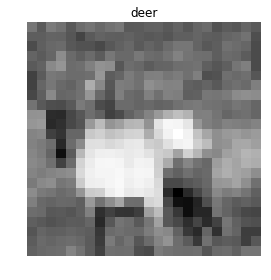

In [50]:
plt.figure()
plt.title(class_name)
img = np.reshape(data[3, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [51]:
# test out on test images
def read_test_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    
    filename = '{}/test_batch'.format(directory)
    batch_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, batch_data['data']))
        labels = np.hstack((labels, batch_data['labels']))
    else:
        data = batch_data['data']
        labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels

In [52]:
test_names, test_data, test_labels = read_test_data('cifar-10-batches-py')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(10000, 3072) (10000,)


In [53]:
test_class_num, test_class_name, test_class_confidence = predict(test_data[4])
print('Test Class Num', test_class_num)
print('Test Class Name', test_class_name)
print('Test Class Confidence', test_class_confidence)
print('Actual Class Label', test_labels[4])

Test Class Num 6
Test Class Name frog
Test Class Confidence 1.827078
Actual Class Label 6


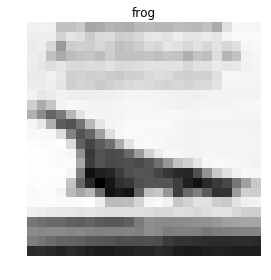

In [54]:
plt.figure()
plt.title(test_class_name)
img = np.reshape(test_data[3, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [59]:
def get_test_accuracy(test_data, test_names, test_labels):
    class_num, class_name, confidence = None, None, 0.
    with tf.Session() as sess:
        loaded_graph = tf.Graph()

        with tf.Session(graph=loaded_graph) as sess:
            # Load model
            loader = tf.train.import_meta_graph('./cifar10-cnn-tf1n-ia-dropout-reg-dense-'+str(epochs)+'epochs.ckpt' + '.meta')
            loader.restore(sess, './cifar10-cnn-tf1n-ia-dropout-reg-dense-'+str(epochs)+'epochs.ckpt')

            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
            loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
            loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
            
            test_logits_out = sess.run(loaded_logits, feed_dict={'input_x:0': test_data.reshape((test_data.shape[0], 24*24))})
 
        
            onehot_test_labels = tf.one_hot(test_labels, len(test_names), on_value=1., off_value=0., axis=-1)
            test_correct_pred = tf.equal(tf.argmax(test_logits_out, 1), tf.argmax(onehot_test_labels, 1))
            test_accuracy = tf.reduce_mean(tf.cast(test_correct_pred, tf.float32))

            print('Test accuracy %f' % (test_accuracy.eval()))  
            predictions = tf.argmax(test_logits_out, 1).eval()
            return (predictions, tf.cast(test_correct_pred, tf.float32).eval(), onehot_test_labels.eval())

    
predict_vals, test_correct_preds, onehot_test_lbls = get_test_accuracy(test_data, test_names, test_labels)
print(predict_vals)
print(predict_vals.shape)
print(test_correct_preds)
print(test_correct_preds.shape)
print(onehot_test_lbls.shape)

Test accuracy 0.640300
[3 8 1 ... 5 1 7]
(10000,)
[1. 1. 0. ... 1. 1. 1.]
(10000,)
(10000, 10)
1000


10


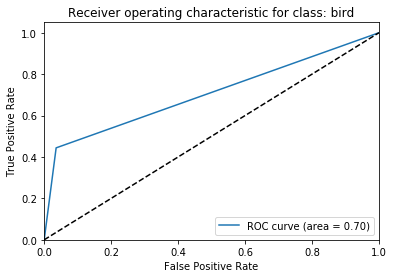

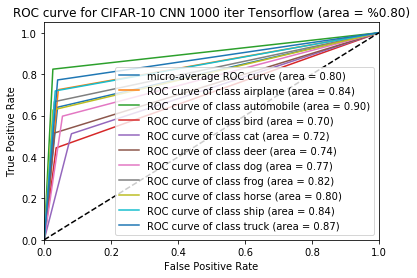

In [60]:
outcome_test = label_binarize(test_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
predictions_test = label_binarize(predict_vals, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = outcome_test.shape[1]
print(n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(outcome_test[:, i], predictions_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(outcome_test.ravel(), predictions_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for class: '+test_names[2])
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(test_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
roc_mean = np.mean(np.fromiter(roc_auc.values(), dtype=float))
plt.title('ROC curve for CIFAR-10 CNN '+str(epochs)+' iter Tensorflow (area = %{0:0.2f})'.format(roc_mean))
plt.legend(loc="lower right")
plt.show()

In [64]:
def predict_img_url(url):
    image = color.rgb2gray(imread(url))
    plt.figure()
    plt.title('URL from Internet')
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off')
    plt.tight_layout()
    new_size = 24,24
    image = resize(image, new_size, anti_aliasing=True)
    images = np.expand_dims(image, axis=0)
    im_data = images.astype(np.float32)
    prediction = predict(im_data[0])
    print(prediction)
    print("Cropped to 24x24")
    plt.figure()
    plt.title('Pic from Internet (24x24): '+str(prediction[1])) # prediction format is (class num,label,conf)
    plt.imshow(images[0], cmap='Greys_r')
    plt.axis('off')
    plt.tight_layout()
    return prediction


(0, 'airplane', 3.241142)
Cropped to 24x24
(0, 'airplane', 3.095353)
Cropped to 24x24
(8, 'ship', 2.510693)
Cropped to 24x24
(0, 'airplane', 3.6882248)
Cropped to 24x24
(0, 'airplane', 2.5342612)
Cropped to 24x24
(8, 'ship', 2.4955664)
Cropped to 24x24
(0, 'airplane', 2.6166708)
Cropped to 24x24
(0, 'airplane', 3.5596597)
Cropped to 24x24
[(0, 'airplane', 3.241142), (0, 'airplane', 3.095353), (8, 'ship', 2.510693), (0, 'airplane', 3.6882248), (0, 'airplane', 2.5342612), (8, 'ship', 2.4955664), (0, 'airplane', 2.6166708), (0, 'airplane', 3.5596597)]


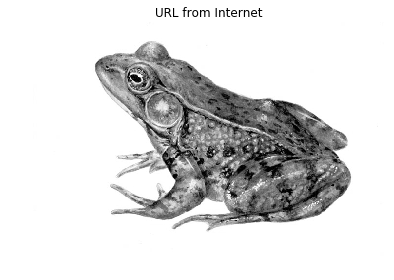

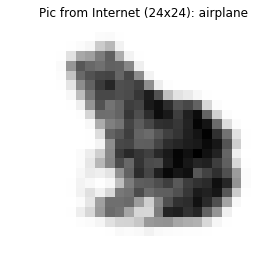

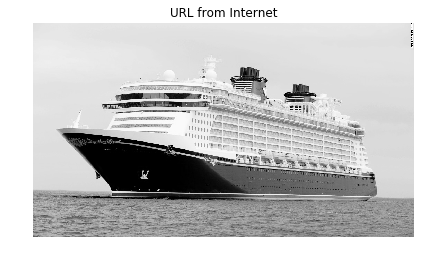

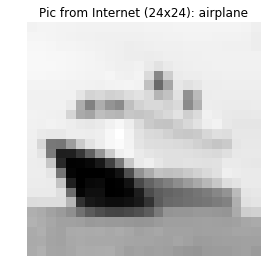

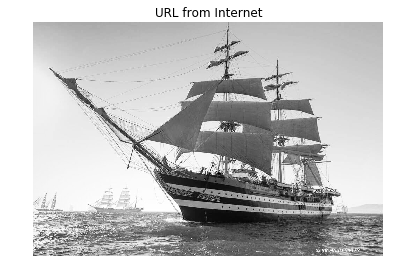

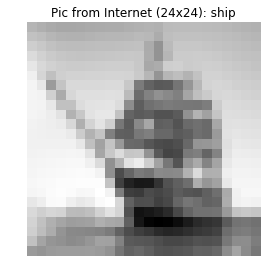

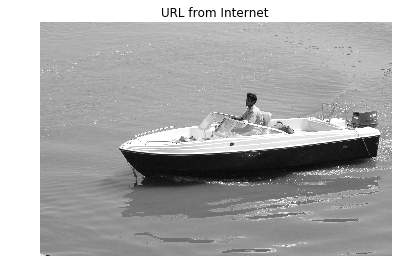

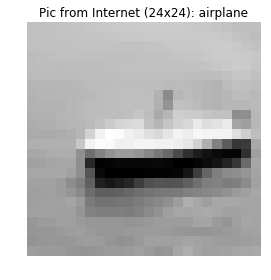

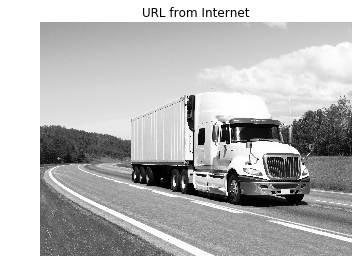

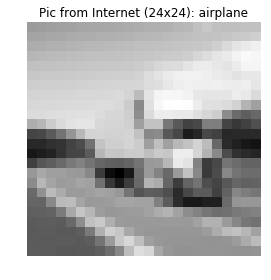

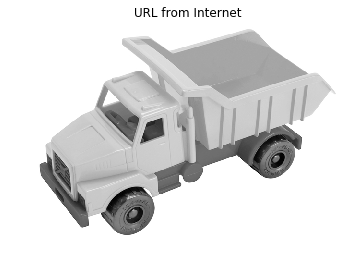

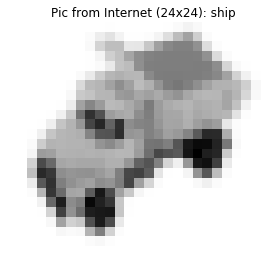

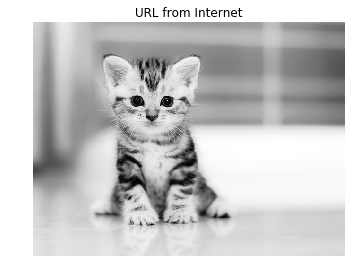

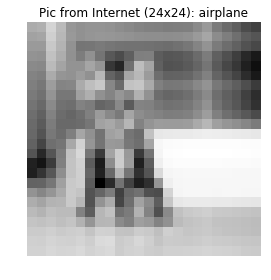

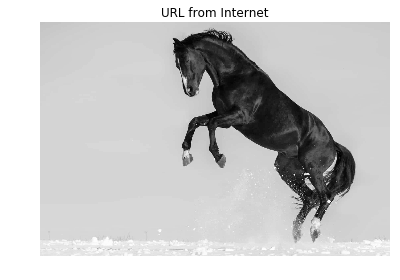

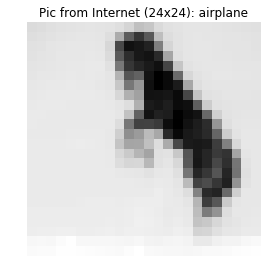

In [65]:
predict_urls = [
    'http://www.torontozoo.com/adoptapond/guide_images/Green%20Frog.jpg', #frog
    'https://cdn.cnn.com/cnnnext/dam/assets/160205192735-01-best-cruise-ships-disney-dream-super-169.jpg', #ship
    'https://www.sailboston.com/wp-content/uploads/2016/11/amerigo-vespucci.jpg', #ship
    'https://upload.wikimedia.org/wikipedia/commons/d/d9/Motorboat_at_Kankaria_lake.JPG', #ship
    'https://media.wired.com/photos/5b9c3d5e7d9d332cf364ad66/master/pass/AV-Trucks-187479297.jpg', #truck
    'https://images.schoolspecialty.com/images/1581176_ecommfullsize.jpg', #truck
    'https://img.purch.com/w/660/aHR0cDovL3d3dy5saXZlc2NpZW5jZS5jb20vaW1hZ2VzL2kvMDAwLzEwNC84MTkvb3JpZ2luYWwvY3V0ZS1raXR0ZW4uanBn', # cat
    'https://thehorse.com/wp-content/uploads/2017/01/iStock-510488648.jpg' #horse
]

predicted_labels = []
for url in predict_urls:
    pred = predict_img_url(url)
    predicted_labels.append(pred)

print(predicted_labels)